In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import glob
import nibabel as nb
import itertools
import json
import sys
import statsmodels.api as sm
from statsmodels.formula.api import ols, wls
from statsmodels.formula.api import mixedlm
from patsy.contrasts import Treatment

from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.iolib.table import (SimpleTable, default_txt_fmt)
from statsmodels.discrete.discrete_model import Probit, MNLogit
from statsmodels.tools import add_constant
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFdr
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import shutil, os

import seaborn as sns
sns.set(style="whitegrid")
import random
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
np.random.seed(1024)

In [2]:
# expt id would be what you did last.
exptid = '5_with_non_imaging_biomarkers_split_ratio_80_20'
base_dir = '/home/abhijit/Jyotirmay/my_thesis'
basic_feats = ['age', 'sex', 'bmi_numeric']
normalised_basic_feats = ['age_normalised', 'sex', 'bmi_numeric_normalised']
spleen_sample_cols = ['0_spleen','1_spleen','2_spleen','3_spleen','4_spleen','5_spleen','6_spleen','7_spleen','8_spleen','9_spleen']
liver_sample_cols = ['0_liver','1_liver','2_liver','3_liver','4_liver','5_liver','6_liver','7_liver','8_liver','9_liver']
vols_feat = ['seg_liver', 'seg_spleen']
iou_feats = ['iou_spleen', 'iou_liver', 'iou_mean']
cv_feats = ['cv', 'cvinv']
selected_model_feats = basic_feats + spleen_sample_cols + liver_sample_cols + vols_feat + iou_feats + cv_feats + ['volume_id', 'diabetes_status'] #+ ['iou_dot_seg_spleen_normalised', 'iou_dot_seg_liver_normalised']
selected_dataset_feats = basic_feats +  ['volume_id', 'diabetes_status'] + vols_feat
all_paths = [
#     {'full_bayesian': './projects/full_bayesian/reports/full_bayesian_KORA_v2/KORA/10_1571866968.4002764_concat_report_final.csv'},
    {'TRAIN_full_bayesian_0dot01': './projects/full_bayesian/reports/full_bayesian_KORA_v4/KORA/10_1575638974.364368_concat_report_final.csv'},
    {'TRAIN_hierarchical_quicknat': './projects/hierarchical_quicknat/reports/hierarchical_quicknat_KORA_v2/KORA/10_1575682785.7956946_concat_report_final.csv'},   
    {'TRAIN_MC_dropout_quicknat': './projects/MC_dropout_quicknat/reports/MC_dropout_quicknat_KORA_v2/KORA/10_1575691492.3282661_concat_report_final.csv'},
    {'TRAIN_probabilistic_quicknat': './projects/probabilistic_quicknat/reports/probabilistic_quicknat_KORA_v2/KORA/10_1575685569.8707192_concat_report_final.csv'},
#     {'PPUKB_MC_dropout_quicknat': './projects/MC_dropout_quicknat/reports/MC_dropout_quicknat_UKB_v2/UKB/0_0.0_concat_report_final_pp.csv'},
    {'TEST_full_bayesian_0dot01': './projects/full_bayesian/reports/full_bayesian_KORA_v4/KORA/10_1572514598.527084_concat_report_final.csv'},
    {'TEST_MC_dropout_quicknat': './projects/MC_dropout_quicknat/reports/MC_dropout_quicknat_KORA_v2/KORA/10_1572006141.7793334_concat_report_final.csv'}, 
    {'TEST_probabilistic_quicknat': './projects/probabilistic_quicknat/reports/probabilistic_quicknat_KORA_v2/KORA/10_1571996796.7963011_concat_report_final.csv'}, 
    {'TEST_hierarchical_quicknat': './projects/hierarchical_quicknat/reports/hierarchical_quicknat_KORA_v2/KORA/10_1571905560.9377904_concat_report_final.csv'},
    {'dataset_KORA_processed': './dataset_groups/whole_body_datasets/KORA/all_processed_True_concat_report_final.csv'},
    {'UKB_full_bayesian_0dot01': './projects/full_bayesian/reports/full_bayesian_UKB_v4/UKB/10_1574676555.7948809_concat_report_final_pp_final.csv'},
    {'UKB_MC_dropout_quicknat': './projects/MC_dropout_quicknat/reports/MC_dropout_quicknat_UKB_v2/UKB/0_0.0_concat_report_final_all.csv'},
    {'UKB_probabilistic_quicknat': './projects/probabilistic_quicknat/reports/probabilistic_quicknat_UKB_v2/UKB/10_1573834823.1121247_concat_report_final.csv'},
    {'UKB_hierarchical_quicknat': './projects/hierarchical_quicknat/reports/hierarchical_quicknat_UKB_v2/UKB/10_1574308007.2486243_concat_report_final.csv'},
    {'dataset_UKB_processed': './dataset_groups/whole_body_datasets/UKB/all_processed_True_concat_report_final.csv'}
]

train_report_paths = [
    {'full_bayesian': './projects/full_bayesian/reports/full_bayesian_KORA_v4/KORA/10_1575638974.364368_concat_report_final.csv'},
    {'dataset_KORA_processed': './dataset_groups/whole_body_datasets/KORA/all_processed_True_concat_report_final.csv'},
]

ukb_paths = [
    {'MC_dropout_quicknat': './projects/MC_dropout_quicknat/reports/MC_dropout_quicknat_UKB_v2/UKB/0_0.0_concat_report_final.csv'},
    {'probabilistic_quicknat': './projects/probabilistic_quicknat/reports/probabilistic_quicknat_UKB_v2/UKB/10_1573834823.1121247_concat_report_final.csv'}
]

model_report_paths = {key:val for d in all_paths for key,val in d.items()}  #all_paths
# ukb_model_report_paths = {key:val for d in ukb_paths for key,val in d.items()}

In [3]:
flatten = lambda l: [item for sublist in l for item in sublist]

def transform_to_categorical(df, categorical_features_list):
    for f in categorical_features_list:
        dfDummies = pd.get_dummies(df[f], prefix = f)
        df = pd.concat([df, dfDummies], axis=1)
    return df

def rename(df, cols_map=None):
    if cols_map is None:
        cols_map =  {'bmi-numeric':'bmi_numeric', 'blood-pressure-diastolic':'blood_pressure_diastolic', 'blood-pressure-systolic':'blood_pressure_systolic',
             'cholesterol-hdl':'cholesterol_hdl', 'cholesterol-ldl':'cholesterol_ldl', 'cholesterol-total':'cholesterol_total',
             'mri-liver-fat-artifacts':'mri_liver_fat_artifacts', 'mri-liver-fat-lobus-dexter':'mri_liver_fat_lobus_dexter', 
              'mri-liver-fat-lobus-sinister':'mri_liver_fat_lobus_sinister', 'mri-liver-fat-portal-vein':'mri_liver_fat_portal_vein',
             'meds-lipoprotein-lowering':'meds_lipoprotein_lowering', 'meds-antihypertensive':'meds_antihypertensive',
              'smoker_non-smoker':'smoker_non_smoker','alcohol-g/day':'alcohol_g_day'}
    df.rename(columns=cols_map, inplace=True)
    return df

def z_score_column_normalise(df, column_list):
    normalised_cols_map = {}
    for column in column_list:
        normalised_cols_map[column] = column+'_normalised'
#         df[normalised_cols_map[column]] = (df[column] - df[column].mean())/df[column].std(ddof=1)
        df[normalised_cols_map[column]] = (df[column] - df[column].min())/ (df[column].max() - df[column].min())
    return df, normalised_cols_map

def z_score_group_normalise(df, cols_to_normalise):
    normalised_cols_map = {}
    group_cols_value = df[cols_to_normalise].values
    mean, std = np.mean(group_cols_value), np.std(group_cols_value, ddof=1)
    for column in cols_to_normalise:
        normalised_cols_map[column] = 'normalised_'+column
        df[normalised_cols_map[column]] = (df[column] - mean)/std
    return df, normalised_cols_map

def pre_process_for_mlm(df, to_be_transpose_cols, value_name):
    cols = list(df.columns)
    cols_without_tobe_transposed_cols = list(set(cols) - set(to_be_transpose_cols))
    df = df.melt(id_vars=cols_without_tobe_transposed_cols, 
            value_vars=to_be_transpose_cols, 
            value_name=value_name)

    return df

def model_evaluation_matrics(file_paths_dict, cols_to_fetch):
    dicts = {}
    for model, path in file_paths_dict.items():
        if 'dataset' in model:
            continue
        df = pd.read_csv(path)
        dicts[model] = df[cols_to_fetch].iloc[1:].mean()
    return dicts

def individual_feature_stats(feats, df, target_col, categorical_feats=['diabetes_status', 'sex']):
    p_values = {}
    for f in feats:
        try:
            features_string = make_feature_string([f], categorical_feats)
            fii = ols(f'{target_col} ~ {features_string}', df).fit()
            feat_dict = fii.pvalues.to_dict()
            coeffs = fii.params
        
            for k, v in feat_dict.items():
                orig_key = k
                if k == 'Intercept':
                    k = f+'_Intercept'
                p_values[k] = v

                p_values[k+'_coeff'] = coeffs[orig_key]
            p_values['fitting_score'] = fii.rsquared
        except Exception as e:
            print(e)

    return p_values


def make_feature_string(feats, categorical_cols=[]):
    feat_str = '1+'
    for c_col in categorical_cols:
        if type(c_col) is tuple:
            if c_col[0] not in feats:
#                 print(f'{c_col} is not present in given feature list, SKIPPING IT!')
                continue
            feat_str += f'C({c_col[0]}, Treatment(reference={c_col[1]}))+'
            c_col = c_col[0]
        else:
            if c_col not in feats:
#                 print(f'{c_col} is not present in given feature list, SKIPPING IT!')
                continue
            feat_str += f'C({c_col}, Treatment)+'
        feats.remove(c_col)
    
    other_feats_str = '+'.join(feats)
    if other_feats_str is '':
        final_feat_str = feat_str[:-1]
    else:
        final_feat_str = feat_str + other_feats_str

    return final_feat_str
    
def normal_mixed_effect_model(df, target_col, features_string, group_col, L1_wt=None):
    if L1_wt is None:
        model = mixedlm(f'{target_col} ~ {features_string}', df, groups=df[group_col]).fit()
    else:
        model = mixedlm(f'{target_col} ~ {features_string}', df, groups=df[group_col]).fit_regularized(L1_wt=L1_wt)
    return model

def anova_test(ols_model):
    anova_stats = sm.stats.anova_lm(ols_model)
    return anova_stats

def df_from_nested_dicts(dicts):
    df = pd.concat({k+'_'+kk: pd.concat({kk:pd.DataFrame(vv, index=[0]).T}, axis=1) for k, v in dicts.items() for kk, vv in v.items()}, axis=1)
    return df

def df_from_nested_dicts_group(dicts):
    df = pd.concat({k+'_'+kk: pd.concat({kk:pd.DataFrame(vv, index=[0]).T}, axis=1) for k, v in dicts.items() for kk, vv in v.items()}, axis=1)
    return df

def highlight_significance(df, threshold=0.05):
    return df.style.applymap(lambda x: 'background-color : yellow' if x==True or x<threshold else '')


def discrete_group_feature_stats(feats, df, target_col, categorical_feats=['diabetes_status', 'sex'], 
                                 is_classification=False, l1mp=0.01):
    p_values = {}
#     try:
#             features_string = f'1+C({f}, Treatment)' if f in categorical_feats else f'1+{f}'
#         df['bmi_2'] = df['bmi_numeric'] ** 2
#         feats = feats + ['bmi_2']
    x = df[feats]
    y = df[target_col]

    x = add_constant(x)
    model = Probit(y, x)
    fii = model.fit_regularized(alpha=l1mp)
    predicted = fii.predict(x)
    feat_dict = fii.pvalues.to_dict()
    coeffs = fii.params

    for k, v in feat_dict.items():
        p_values[k] = v
        p_values[k+'_coeff'] = coeffs[k]

    p_values['aic'] = fii.aic
    p_values['bic'] = fii.bic
    p_values['psuedo_r2'] = fii.prsquared
#     except Exception as e:
#         print('ERROR:', e)

    return p_values, fii, (y, predicted)

# def weighted_group_feats(df, target_col, features_string, alpha_col):
#     alpha = df[alpha_col].values
#     model = wls(f'{target_col} ~ {features_string}', df, weights=(1/(1-alpha))).fit()
#     return model

def discrete_weighted_group_feats(df, target_col, feats, alpha_col, l1mp=0.01):
    p_values = {}
    alpha = df[alpha_col].values
#     df['bmi_2'] = df['bmi_numeric'] ** 2
#     feats = feats + ['bmi_2']
    x = df[feats]
    y = df[target_col]
    
    x = add_constant(x)
    fii = sm.GLM(y, x, family=sm.families.Binomial(sm.families.links.probit), missing='drop', var_weights=alpha).fit_regularized(alpha=l1mp*(1/alpha))
    predicted = fii.predict(x)
#     feat_dict = fii.pvalues.to_dict()
#     coeffs = fii.params

#     for k, v in feat_dict.items():
#         p_values[k] = v
#         p_values[k+'_coeff'] = coeffs[k]

#     p_values['aic'] = fii.aic
#     p_values['bic'] = fii.bic
#     sst_val = sum(map(lambda x: np.power(x,2),y-np.mean(y))) 
#     sse_val = sum(map(lambda x: np.power(x,2),fii.resid_response)) 
#     r2 = 1-(sse_val/sst_val)
#     p_values['psuedo_r2'] = r2
    return p_values, fii, (y, predicted)

def normal_group_fit(df, target_col, features_string):
    p_values = {}
    fii = ols(f'{target_col} ~ {features_string}', df).fit()
    y = df[target_col].values
    predicted = fii.predict(df)
    feat_dict = fii.pvalues.to_dict()
    coeffs = fii.params

    for k, v in feat_dict.items():
        p_values[k] = v
        p_values[k+'_coeff'] = coeffs[k]

    p_values['aic'] = fii.aic
    p_values['bic'] = fii.bic
    p_values['psuedo_r2'] = fii.rsquared
    return p_values, fii, (y, predicted)

def weighted_group_feats(df, target_col, features_string, alpha_col):
    p_values = {}
    alpha = df[alpha_col].values
    fii = wls(f'{target_col} ~ {features_string}', df, weights=alpha).fit()
    y = df[target_col].values
    predicted = fii.predict(df)
    feat_dict = fii.pvalues.to_dict()
    coeffs = fii.params
    
    for k, v in feat_dict.items():
        p_values[k] = v
        p_values[k+'_coeff'] = coeffs[k]

    p_values['aic'] = fii.aic
    p_values['bic'] = fii.bic
    p_values['psuedo_r2'] = fii.rsquared
    return p_values, fii, (y, predicted)

In [4]:
def normalise_iou(df):
    for iou_col in ['iou_spleen', 'iou_liver', 'iou_mean']:
        iou = df[iou_col]
#         iou = (iou - iou.mean())/iou.std(ddof=0)
        iou = (iou - iou.min()) / (iou.max() - iou.min())
        df[f'{iou_col}_normalised'] = iou
#     df['iou_mean_normalised'] = (df['iou_spleen_normalised'] + df['iou_liver_normalised']) / 2
    return df

In [42]:
def plot_pdf(good_pdf, bad_pdf, ax):
    ax.fill(x, good_pdf, "g", alpha=0.5)
    ax.fill(x, bad_pdf,"r", alpha=0.5)
    ax.set_xlim([0,1])
    ax.set_ylim([0,5])
    ax.set_title("Probability Distribution", fontsize=14)
    ax.set_ylabel('Counts', fontsize=12)
    ax.set_xlabel('P(X="bad")', fontsize=12)
    ax.legend(["good","bad"])

def auc_roc(y_yp, title):
    y, predicted = y_yp
    y_p = np.where(predicted > 0.5, 1, 0)
    labels = [0, 1]
    y_1_mask = np.where(y==1, True, False)
    y_0_mask = np.where(y==0, True, False)
    xs = [predicted[y_0_mask], predicted[y_1_mask]]

    fig, ax0 = plt.subplots(nrows=1, ncols=1)
    colors = ['red','blue']
    ax0.hist(xs, 10, normed=1, histtype='bar', color=colors, label=labels)
    ax0.legend(prop={'size': 10})
    ax0.set_title('bars with legend')
    plt.show()
    
   
    fpr, tpr, thresholds = metrics.roc_curve(y, predicted, pos_label=1)
    auc_score = metrics.roc_auc_score(y, predicted)
 
#     f1_score = metrics.f1_score(y, y_p, labels=labels)
    print(f'{title}: auc_score: {auc_score}')
#     plt.scatter(predicted, y)
#     plt.show()
    plt.plot(fpr, tpr)
    plt.show()
#     print(list(y))
#     print(predicted)
    
#     print(y_p)
    
    cm = confusion_matrix(y, y_p, labels)
    print(cm)
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     cax = ax.matshow(cm)
#     plt.title('Confusion matrix of the classifier')
#     fig.colorbar(cax)
#     ax.set_xticklabels([''] + labels)
#     ax.set_yticklabels([''] + labels)
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
#     plt.show()
    
#     unique_elements, counts_elements = np.unique(predicted, return_counts=True)
#     plt.hist(predicted, bins=20)
#     plt.bar(unique_elements, counts_elements)
#     plt.show()
    
#     print(disp)
#     disp.ax_.set_title(title)

#     print(title)
#     print(disp.confusion_matrix)
#     print(f'{title}:::  fpr: {fpr}, tpr: {tpr}, threshold: {thresholds}')
    return auc_score, 1

def regression_plot(y_yp, title=''):
    y, predicted = y_yp
    print(title)
    plt.scatter(predicted, y)
    plt.show()
    
def random_forest_evaluations(df, target_col, feats):
    y = df[target_col]
    x = df[feats]
    kfold_rf = model_selection.KFold(n_splits=10, random_state=10)
    model_rf = RandomForestClassifier(n_estimators=100, max_features=3)
    results_rf = model_selection.cross_val_score(model_rf, x, y, cv=kfold_rf)
    print('Random Forest Out:', results_rf.mean())
    return results_rf.mean()

def gradient_boosting_evaluations(feats, df, target_col, categorical_feats=['diabetes_status', 'sex'], 
                                 is_classification=False, l1mp=0.01):
    y = df[target_col]
    x = df[feats]
    x = add_constant(x)
    
#     kfold_rf = model_selection.KFold(n_splits=10, random_state=10)
#     model_rf = RandomForestClassifier(n_estimators=10)
#     results_rf = model_selection.cross_val_score(model_rf, x, y, cv=kfold_rf)
#     print('Gradient Boosting Out:', results_rf.mean())
    
#     auc, _ = auc_roc((y, y_p), 'ensemble')




    random_classifier = RandomForestClassifier()
    max_feats = x.shape[1]
    parameters = { 'max_features':[max_feats],'n_estimators':[500],'min_samples_leaf': [10,50,100,200,500]}

    random_grid = GridSearchCV(random_classifier, parameters, cv = 6)
    model_gb_fitted = random_grid.fit(x, y)
    y_p = model_gb_fitted.predict(x)
    
    return {}, model_gb_fitted, (y, y_p)

def weighted_gradient_boosting_evaluations(df, target_col, feats, alpha_col, l1mp=0.01):
    y = df[target_col]
    x = df[feats]
    x = add_constant(x)
    
    alpha = df[alpha_col].values
    
#     kfold_rf = model_selection.KFold(n_splits=10, random_state=10)
#     model_rf = RandomForestClassifier(n_estimators=100)
#     results_rf = model_selection.cross_val_score(model_rf, x, y, cv=kfold_rf)
#     print('Gradient Boosting Out:', results_rf.mean())
    random_classifier = RandomForestClassifier()
    max_feats = x.shape[1]
    parameters = { 'max_features':[max_feats],'n_estimators':[500],'min_samples_leaf': [10,50,100,200,500]}

    random_grid = GridSearchCV(random_classifier, parameters, cv = 6)
    model_gb_fitted = random_grid.fit(x, y, sample_weight=alpha)
    y_p = model_gb_fitted.predict(x)
#     auc, _ = auc_roc((y, y_p), 'ensemble')
    
    return {}, model_gb_fitted, (y, y_p)

def bagging_evaluations(df, target_col, feats):
    y = df[target_col]
    x = df[feats]
    kfold = model_selection.KFold(n_splits=10, random_state=10)
    model_1 = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, random_state=10)
    results_1 = model_selection.cross_val_score(model_1, x, y, cv=kfold)
    print('Bagging Out:', results_1.mean())
    return results_1.mean()

def sgd_evaluator(df, target_col, feats):
    y = df[target_col]
    x = df[feats]
    kfold_sgb = model_selection.KFold(n_splits=10, random_state=10)
    model_sgb = GradientBoostingClassifier(n_estimators=100, random_state=10)
    results_sgb = model_selection.cross_val_score(model_sgb, x, y, cv=kfold_sgb)
    
    y_p = model_sgb.fit(x, y).predict(x)
    print('model score: ', model_sgb.score(x, y))
    auc_roc((y, y_p), 'sgd')
    print('Stochastic Gradient out:', results_sgb)
    
    
    
    
    return results_sgb.mean()

def voting_classifier_evaluator(df, target_col, feats, weight_col=None, ensemble=None):
    y = df[target_col]
#     feats = ['age', 'bmi_numeric']
    if weight_col is None:
        x = df[feats]
        weights = None
    else:
        x = df[feats]
        weights = df[weight_col].values
    
    x = add_constant(x)
    
    X_train, X_test, y_train, y_test = x, x, y, y #train_test_split(x, y, test_size=0.33, random_state=10)

   
    if ensemble is None:
        estimators = []
    
#         mod_rf = RandomForestClassifier(n_estimators=100, max_features=3)
#         estimators.append(('rf', mod_rf))
        mod_bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, random_state=10)
        estimators.append(('bagging', mod_bagging))
        mod_sgd = GradientBoostingClassifier(n_estimators=100, random_state=10)
        estimators.append(('sgd', mod_sgd))
        mod_lr = LogisticRegression()
        estimators.append(('logistic', mod_lr))
        mod_dt = DecisionTreeClassifier()
        estimators.append(('cart', mod_dt))
        mod_sv = SVC()
        estimators.append(('svm', mod_sv))
      
        ensemble = VotingClassifier(estimators)
#         print(X_train.columns)
        ensemble.fit(X_train, y_train, sample_weight=weights)
    else:
       
        X_train, X_test, y_train, y_test = x, x, y, y
    
#     fig, axes = plt.subplots(1, 1, figsize=(14, 6))
#     if weights is None:
#         weights = np.ones(len(X_train))
#     plot_decision_function(ensemble, weights, axes, title, X_train.values, y_train.values)
#     print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
#         print(ensemble)
#     auc_roc((y_train, ensemble.predict(X_train)), 'ensemble')
#     print('ensemble score train set: ',ensemble.score(X_train, y_train))

#     print('here', weights.shape, ensemble.score(X_test, y_test, weights))
#     print('here2', ensemble.score(X_test, y_test))
    print(X_test.iloc[2])
    print(ensemble.predict(X_test), y_test.values)

    auc, _ = auc_roc((y_test, ensemble.predict(X_test)), 'ensemble')
#     print('ensemble score test set: ',ensemble.score(X_test, y_test))
#      kfold_vc = model_selection.KFold(n_splits=10, random_state=10)
#     results_vc = model_selection.cross_val_score(ensemble, X_test, y_test, cv=kfold_vc)
#     print('Voting Classifier out many mean:', results_vc.mean())
# 
    return 1, 1, ensemble, auc

def plot_decision_function(classifier, sample_weight, axis, title, X, y):
    # plot the decision function
    xx, yy = np.meshgrid(np.linspace(-4, 5, 500), np.linspace(-4, 5, 500))

    Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # plot the line, the points, and the nearest vectors to the plane
    axis.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.bone)
    axis.scatter(X[:, 0], X[:, 1], c=y, s=100 * sample_weight, alpha=0.9,
                 cmap=plt.cm.bone, edgecolors='black')

    axis.axis('off')
    axis.set_title(title)
    
def aggregate_model_outputs(df, target_col, feats, dicts, model, key, ensemble_model=None, weight_col=None):
#     dicts['rf'] = random_forest_evaluations(df, target_col, feats)
#     dicts[model][key]['bagging'] = bagging_evaluations(df, target_col, feats)
#     dicts[model][key]['sgd'] = sgd_evaluator(df, target_col, feats)
#     df['bmi_2'] = df['bmi_numeric'] **2
#     feats = feats + ['bmi_2']
    dicts[model][key]['v_scoring'],dicts[model][key]['v_scoring_with_weight'], ensemble_model, dicts[model][key]['v_auc'] = voting_classifier_evaluator(df, target_col, feats, weight_col, ensemble_model)
    
    return dicts, ensemble_model

def calculate_cv_and_cvinv(df):
    df['cv'] = df[liver_sample_cols].std(axis=1, ddof=1) / df[liver_sample_cols].mean(axis=1)
    df['cvinv'] = 1/df['cv']
    return df


def p2_train_test_split(path, train_vols=None):
    dfi = pd.read_csv(path)
#     dfi.loc[dfi['diabetes_status']==2, 'diabetes_status'] = 1
    if train_vols is None:
        diabetic_t_volumes = dfi[dfi['diabetes_status']!=0]['volume_id']
        non_diabetic_t_volumes = dfi[dfi['diabetes_status']==0]['volume_id']
        
        d_train_count = int(np.count_nonzero(diabetic_t_volumes) * 0.55)
        nd_train_count = int(np.count_nonzero(non_diabetic_t_volumes) * 0.55)

        d_vols = random.sample(list(diabetic_t_volumes), d_train_count)
        nd_vols = random.sample(list(non_diabetic_t_volumes), nd_train_count)

        train_vols = d_vols + nd_vols

    df_p2_train = dfi[dfi['volume_id'].isin(train_vols)]
    df_p2_test = dfi[~dfi['volume_id'].isin(train_vols)]
    
#     df_p2_train.loc[df_p2_train['diabetes_status']==2, 'diabetes_status'] = 1
#     df_p2_test.loc[df_p2_test['diabetes_status']==2, 'diabetes_status'] = 1
#     print(pd.unique(df_p2_train), pd.unique(df_p2_test.unique))
    return df_p2_train, df_p2_test, train_vols

In [43]:
cols_to_fetch = ['sncc', 'ged', 'iou_spleen', 'iou_liver', 'dice_spleen',
       'dice_liver', 'surface_distance_avg_spleen', 'surface_distance_avg_liver']
dicts = model_evaluation_matrics(model_report_paths, cols_to_fetch)
df_model_eval = pd.DataFrame.from_dict(dicts)
df_model_eval = df_model_eval.T
# df_model_eval.columns = cols_to_fetch
df_model_eval

,sncc,ged,iou_spleen,iou_liver,dice_spleen,dice_liver,surface_distance_avg_spleen,surface_distance_avg_liver
TEST_full_bayesian_0dot01,0.431056,0.205196,0.765032,0.834236,0.866607,0.913831,0.865609,0.802376
TRAIN_full_bayesian_0dot01,0.452115,0.184243,0.793901,0.855048,0.887566,0.930659,0.893639,0.836537
TEST_MC_dropout_quicknat,0.399977,0.172993,0.817894,0.871292,0.890937,0.932408,0.910217,0.857313
TRAIN_MC_dropout_quicknat,0.402907,0.157681,0.825572,0.887205,0.904725,0.944347,0.922485,0.888401
TEST_probabilistic_quicknat,0.162286,0.238688,0.986873,0.991927,0.865758,0.920266,0.863713,0.813608
TRAIN_probabilistic_quicknat,0.169849,0.215654,0.989576,0.993034,0.883133,0.931583,0.889205,0.844649
TEST_hierarchical_quicknat,0.172104,0.218123,0.983581,0.987958,0.877205,0.927393,0.889762,0.842803
TRAIN_hierarchical_quicknat,0.210593,0.198605,0.983958,0.990271,0.889754,0.939397,0.905928,0.870023
UKB_full_bayesian_0dot01,NaN,NaN,0.683044,0.746261,NaN,NaN,NaN,NaN
UKB_MC_dropout_quicknat,NaN,NaN,0.707228,0.777343,NaN,NaN,NaN,NaN


In [50]:
# model_report_paths = {'TEST_full_bayesian_0dot01': './phase_2/p2_full_bayesian_0dot01_train.csv',
#  'TRAIN_full_bayesian_0dot01': './phase_2/p2_full_bayesian_0dot01_test.csv',
#  'TEST_MC_dropout_quicknat': './phase_2/p2_MC_dropout_quicknat_train.csv', 
#  'TRAIN_MC_dropout_quicknat': './phase_2/p2_MC_dropout_quicknat_test.csv', 
#  'TEST_probabilistic_quicknat': './phase_2/p2_probabilistic_quicknat_train.csv', 
#  'TRAIN_probabilistic_quicknat': './phase_2/p2_probabilistic_quicknat_test.csv',
#  'TEST_hierarchical_quicknat': './phase_2/p2_hierarchical_quicknat_train.csv', 
#  'TRAIN_hierarchical_quicknat': './phase_2/p2_hierarchical_quicknat_test.csv', 
#  'dataset_KORA_processed': './dataset_groups/whole_body_datasets/KORA/all_processed_True_concat_report_final.csv',
#  'UKB_full_bayesian_0dot01': './projects/full_bayesian/reports/full_bayesian_UKB_v4/UKB/10_1574676555.7948809_concat_report_final_pp_final.csv',
#  'UKB_MC_dropout_quicknat': './projects/MC_dropout_quicknat/reports/MC_dropout_quicknat_UKB_v2/UKB/0_0.0_concat_report_final_all.csv', 
#  'UKB_probabilistic_quicknat': './projects/probabilistic_quicknat/reports/probabilistic_quicknat_UKB_v2/UKB/10_1573834823.1121247_concat_report_final.csv', 
#  'UKB_hierarchical_quicknat': './projects/hierarchical_quicknat/reports/hierarchical_quicknat_UKB_v2/UKB/10_1574308007.2486243_concat_report_final.csv', 
#  'dataset_UKB_processed': './dataset_groups/whole_body_datasets/UKB/all_processed_True_concat_report_final.csv'
#                      }



# shutil.copytree('./phase_2/', f'./expts/expt_{exptid}/')

new_model_report_paths = {}
train_vols = None
for model, path in model_report_paths.items():
    if 'TEST' in model:
        model_key = model[5:]
        if train_vols is None:
            p2_train, p2_test, train_vols = p2_train_test_split(path)
        else:
            p2_train, p2_test, train_vols = p2_train_test_split(path, train_vols)
        new_train_path = f'./phase_2/p2_{model_key}_train.csv'
        new_test_path = f'./phase_2/p2_{model_key}_test.csv'
        p2_train.loc[p2_train['diabetes_status']==2, 'diabetes_status'] = 1
        p2_test.loc[p2_test['diabetes_status']==2, 'diabetes_status'] = 1
        p2_train.to_csv(new_train_path, index=False)
        p2_test.to_csv(new_test_path, index=False)
        new_model_report_paths[f'TEST_{model_key}'] = new_train_path
        new_model_report_paths[f'TRAIN_{model_key}'] = new_test_path
    elif 'UKB' in model:
        new_model_report_paths[model] = model_report_paths[model]
    elif 'dataset' in model:
        new_model_report_paths[model] = model_report_paths[model]
    
model_report_paths = new_model_report_paths

print(model_report_paths, sep='')

{'TEST_full_bayesian_0dot01': './phase_2/p2_full_bayesian_0dot01_train.csv', 'TRAIN_full_bayesian_0dot01': './phase_2/p2_full_bayesian_0dot01_test.csv', 'TEST_MC_dropout_quicknat': './phase_2/p2_MC_dropout_quicknat_train.csv', 'TRAIN_MC_dropout_quicknat': './phase_2/p2_MC_dropout_quicknat_test.csv', 'TEST_probabilistic_quicknat': './phase_2/p2_probabilistic_quicknat_train.csv', 'TRAIN_probabilistic_quicknat': './phase_2/p2_probabilistic_quicknat_test.csv', 'TEST_hierarchical_quicknat': './phase_2/p2_hierarchical_quicknat_train.csv', 'TRAIN_hierarchical_quicknat': './phase_2/p2_hierarchical_quicknat_test.csv', 'dataset_KORA_processed': './dataset_groups/whole_body_datasets/KORA/all_processed_True_concat_report_final.csv', 'UKB_full_bayesian_0dot01': './projects/full_bayesian/reports/full_bayesian_UKB_v4/UKB/10_1574676555.7948809_concat_report_final_pp_final.csv', 'UKB_MC_dropout_quicknat': './projects/MC_dropout_quicknat/reports/MC_dropout_quicknat_UKB_v2/UKB/0_0.0_concat_report_final_a

In [51]:
p2_train.diabetes_status.unique()

array([0, 1])

In [47]:
df_model_eval[['dice_spleen', 'dice_liver']].mean(axis=1)

TEST_full_bayesian_0dot01       0.890219
TRAIN_full_bayesian_0dot01      0.909113
TEST_MC_dropout_quicknat        0.911672
TRAIN_MC_dropout_quicknat       0.924536
TEST_probabilistic_quicknat     0.893012
TRAIN_probabilistic_quicknat    0.907358
TEST_hierarchical_quicknat      0.902299
TRAIN_hierarchical_quicknat     0.914575
UKB_full_bayesian_0dot01             NaN
UKB_MC_dropout_quicknat              NaN
UKB_probabilistic_quicknat           NaN
UKB_hierarchical_quicknat            NaN
dtype: float64

# Post Process reports

In [48]:
dfs_train = {}
common_vols = None

for model, path in model_report_paths.items():
    if 'dataset' in model:
        continue
    if 'TRAIN' not in model:
        continue
    print(model)
    df = pd.read_csv(path)
    df = calculate_cv_and_cvinv(df)
    df = rename(df)
    
    dfs_train[model] = df
    vols = df[(df['iou_liver']>0.51) & (df['iou_liver'] != 1.0)].volume_id.values
    if common_vols is None:
        common_vols = vols
    else:
        common_vols = np.intersect1d(common_vols, vols)
    print(common_vols.shape)

df_dataset = pd.read_csv(model_report_paths['dataset_KORA_processed'])
df_dataset = rename(df_dataset)
dfs_train['dataset_KORA_processed']  = df_dataset

for model, df in dfs_train.items():
    if 'dataset' in model:
        selected_feats = selected_dataset_feats
    else:
        selected_feats = selected_model_feats #+ ['iou_spleen_normalised', 'iou_liver_normalised', 'iou_mean_normalised']
     
        
    df = df[df.volume_id.isin(common_vols)][selected_feats]
    df['seg_spleen_bmi_normalised'] = df['seg_spleen'] / df['bmi_numeric']
    df['seg_liver_bmi_normalised'] = df['seg_liver'] / df['bmi_numeric']
    df['age2'] = df['age'] ** 2
    df['bmi2'] = df['bmi_numeric'] ** 2
    df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver', 'age', 'bmi_numeric','seg_liver_bmi_normalised', 'seg_spleen_bmi_normalised'])
    df, normalised_cols = z_score_column_normalise(df, ['seg_spleen_bmi_normalised', 'seg_liver_bmi_normalised'])
    if 'dataset' not in model:
        df['iou_dot_seg_spleen'] = df['iou_spleen'] * df['seg_spleen']
        df['iou_dot_seg_liver'] = df['iou_liver'] * df['seg_liver']
        df, _ =  z_score_column_normalise(df, ['iou_dot_seg_spleen', 'iou_dot_seg_liver'])
        df, _ = z_score_column_normalise(df, ['0_liver', '1_liver', '2_liver', '3_liver', '4_liver',
           '5_liver', '6_liver', '7_liver', '8_liver', '9_liver'])
        df = normalise_iou(df)
#         print(df[])
    dfs_train[model] = df
    print('model shape:', dfs_train[model].shape)

## Change pre-diabetic state to diabetic
for model, df in dfs_train.items():
    df.loc[df['diabetes_status']==2, 'diabetes_status'] = 1
    dfs_train[model] = df
    dfs_train[model].to_csv(f'final_feats_TRAIN_{model}.csv', index=False)

print(dfs_train.keys())

TRAIN_full_bayesian_0dot01
(38,)
TRAIN_MC_dropout_quicknat
(38,)
TRAIN_probabilistic_quicknat
(38,)
TRAIN_hierarchical_quicknat
(38,)
model shape: (38, 59)
model shape: (38, 59)
model shape: (38, 59)
model shape: (38, 59)
model shape: (38, 17)
dict_keys(['TRAIN_full_bayesian_0dot01', 'TRAIN_MC_dropout_quicknat', 'TRAIN_probabilistic_quicknat', 'TRAIN_hierarchical_quicknat', 'dataset_KORA_processed'])


In [49]:
for model, df in dfs_train.items():
    print(df['diabetes_status'].unique())

[0 1]
[0 1]
[0 1]
[0 1]
[0 1]


In [10]:
dfs = {}
common_vols = None

for model, path in model_report_paths.items():
    if 'dataset' in model:
        continue
    if 'TEST' not in model:
        continue
    print(model)
    df = pd.read_csv(path)
    df = calculate_cv_and_cvinv(df)
    df = rename(df)
    dfs[model] = df
    vols = df[(df['iou_liver']>0.51) & (df['iou_liver'] != 1.0)].volume_id.values
    if common_vols is None:
        common_vols = vols
    else:
        common_vols = np.intersect1d(common_vols, vols)
    print(common_vols.shape)

df_dataset = pd.read_csv(model_report_paths['dataset_KORA_processed'])
df_dataset = rename(df_dataset)
dfs['dataset_KORA_processed']  = df_dataset

for model, df in dfs.items():
    if 'dataset' in model:
        selected_feats = selected_dataset_feats
    else:
        selected_feats = selected_model_feats #+ ['iou_spleen_normalised', 'iou_liver_normalised', 'iou_mean_normalised']
     
        
    df = df[df.volume_id.isin(common_vols)][selected_feats]
    df['seg_spleen_bmi_normalised'] = df['seg_spleen'] / df['bmi_numeric']
    df['seg_liver_bmi_normalised'] = df['seg_liver'] / df['bmi_numeric']
    df['age2'] = df['age'] ** 2
    df['bmi2'] = df['bmi_numeric'] ** 2
    df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver', 'age', 'bmi_numeric','seg_liver_bmi_normalised', 'seg_spleen_bmi_normalised'])
    df, normalised_cols = z_score_column_normalise(df, ['seg_spleen_bmi_normalised', 'seg_liver_bmi_normalised'])
    if 'dataset' not in model:
        df['iou_dot_seg_spleen'] = df['iou_spleen'] * df['seg_spleen']
        df['iou_dot_seg_liver'] = df['iou_liver'] * df['seg_liver']
        df, _ =  z_score_column_normalise(df, ['iou_dot_seg_spleen', 'iou_dot_seg_liver'])
        df, _ = z_score_column_normalise(df, ['0_liver', '1_liver', '2_liver', '3_liver', '4_liver',
           '5_liver', '6_liver', '7_liver', '8_liver', '9_liver'])
        df = normalise_iou(df)
#         print(df[])
    dfs[model] = df
    print('model shape:', dfs[model].shape)

## Change pre-diabetic state to diabetic
for model, df in dfs.items():
    df.loc[df['diabetes_status']==2, 'diabetes_status'] = 1
    dfs[model] = df
    dfs[model].to_csv(f'final_feats_TEST_{model}.csv', index=False)
    
print(dfs.keys())

TEST_full_bayesian_0dot01
(81,)
TEST_MC_dropout_quicknat
(81,)
TEST_probabilistic_quicknat
(81,)
TEST_hierarchical_quicknat
(81,)
model shape: (81, 59)
model shape: (81, 59)
model shape: (81, 59)
model shape: (81, 59)
model shape: (81, 17)
dict_keys(['TEST_full_bayesian_0dot01', 'TEST_MC_dropout_quicknat', 'TEST_probabilistic_quicknat', 'TEST_hierarchical_quicknat', 'dataset_KORA_processed'])


In [11]:
dfs_ukb = {}
common_vols = None

for model, path in model_report_paths.items():
    if 'dataset' in model:
        continue
    if 'UKB' not in model:
        continue
    print(model)
    df = pd.read_csv(path)
    df = calculate_cv_and_cvinv(df)
    df = rename(df)
    df = df.fillna(0)
    df.drop_duplicates(subset ="volume_id", inplace = True)
    dfs_ukb[model] = df
    vols = df[(df['iou_liver']>0.51) & (df['iou_spleen'] != 1.0) & (df['iou_liver'] != 1.0)].volume_id.values
    if common_vols is None:
        common_vols = vols
    else:
        common_vols = np.intersect1d(common_vols, vols)
    print(common_vols.shape)

df_dataset = pd.read_csv(model_report_paths['dataset_UKB_processed'])

# common_vols = np.intersect1d(common_vols, df_dataset.volume_id.values)
df_dataset = rename(df_dataset)

dfs_ukb['dataset_UKB_processed']  = df_dataset

for model, df in dfs_ukb.items():
    if 'dataset' in model:
        selected_feats = selected_dataset_feats
        df = df[selected_feats]
    else:
        selected_feats = selected_model_feats #+ ['iou_spleen_normalised', 'iou_liver_normalised', 'iou_mean_normalised']
        df = df[df.volume_id.isin(common_vols)][selected_feats]
        
    df['seg_spleen_bmi_normalised'] = df['seg_spleen'] / df['bmi_numeric']
    df['seg_liver_bmi_normalised'] = df['seg_liver'] / df['bmi_numeric']
    df['age2'] = df['age'] ** 2
    df['bmi2'] = df['bmi_numeric'] ** 2
    df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver', 'age', 'bmi_numeric'])
    df, normalised_cols = z_score_column_normalise(df, ['seg_spleen_bmi_normalised', 'seg_liver_bmi_normalised'])
    if 'dataset' not in model:
        df['iou_dot_seg_spleen'] = df['iou_spleen'] * df['seg_spleen']
        df['iou_dot_seg_liver'] = df['iou_liver'] * df['seg_liver']
        df, _ =  z_score_column_normalise(df, ['iou_dot_seg_spleen', 'iou_dot_seg_liver'])
        df, _ = z_score_column_normalise(df, ['0_liver', '1_liver', '2_liver', '3_liver', '4_liver',
       '5_liver', '6_liver', '7_liver', '8_liver', '9_liver'])
        df = normalise_iou(df)
    dfs_ukb[model] = df
    print(f'model shape of {model}:', dfs_ukb[model].shape)
    print(dfs_ukb[model].columns)
# df_dataset = pd.read_csv(model_report_paths['dataset_KORA_processed'])
# df_dataset = rename(df_dataset)
# dfs['dataset_KORA_processed'] = df[df.volume_id.isin(common_vols)][selected_dataset_feats]
# print(dfs['dataset_KORA_processed'].shape)

## Change pre-diabetic state to diabetic
for model, df in dfs_ukb.items():
    df.loc[df['diabetes_status']==2, 'diabetes_status'] = 1
    dfs_ukb[model] = df
    dfs_ukb[model].to_csv(f'final_feats_UKB_{model}.csv', index=False)
    
print(dfs_ukb.keys())

UKB_full_bayesian_0dot01
(14698,)
UKB_MC_dropout_quicknat
(13985,)
UKB_probabilistic_quicknat
(13982,)
UKB_hierarchical_quicknat
(13969,)
model shape of UKB_full_bayesian_0dot01: (13969, 59)
Index(['age', 'sex', 'bmi_numeric', '0_spleen', '1_spleen', '2_spleen',
       '3_spleen', '4_spleen', '5_spleen', '6_spleen', '7_spleen', '8_spleen',
       '9_spleen', '0_liver', '1_liver', '2_liver', '3_liver', '4_liver',
       '5_liver', '6_liver', '7_liver', '8_liver', '9_liver', 'seg_liver',
       'seg_spleen', 'iou_spleen', 'iou_liver', 'iou_mean', 'cv', 'cvinv',
       'volume_id', 'diabetes_status', 'seg_spleen_bmi_normalised',
       'seg_liver_bmi_normalised', 'age2', 'bmi2', 'seg_spleen_normalised',
       'seg_liver_normalised', 'age_normalised', 'bmi_numeric_normalised',
       'seg_spleen_bmi_normalised_normalised',
       'seg_liver_bmi_normalised_normalised', 'iou_dot_seg_spleen',
       'iou_dot_seg_liver', 'iou_dot_seg_spleen_normalised',
       'iou_dot_seg_liver_normalised', 

# Equations

Eq-1: Diabetes_status = a0 +a1*age + a2*sex + a3*BMI

Eq-2: Diabetes_status = a0 +a1*age + a2*sex + a3*BMI + a4*seg_<spleen|liver>

Eq-3: Diabetes_status = a0 +a1*age + a2*sex + a3*BMI + a4*seg_<spleen|liver> + a5*iou_<spleen|liver>

Eq-4: Diabetes_status = a0 +a1*age + a2*sex + a3*BMI + a4*(iou_<spleen|liver> * seg_<spleen|liver>)

Eq-4: (Diabetes_status == a0 +a1*age + a2*sex + a3*BMI + a4*seg_<spleen|liver>) * iou_<spleen|liver>

// Eq-5: Diabetes_status = a0 +a1*age + a2*sex + a3*BMI +  a4*seg_<spleen|liver>)i

# Group features (eq 1, eq 2, eq 3 and eq 4)

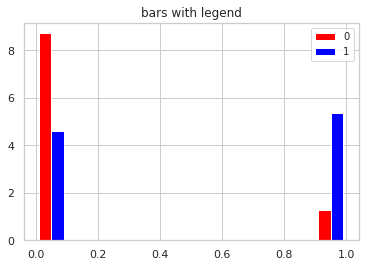

TEST_full_bayesian_0dot01_csv_features: auc_score: 0.7055944055944057


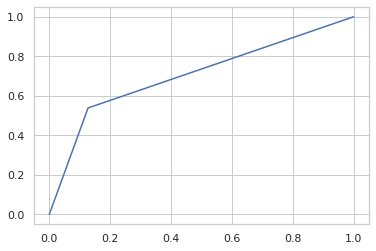

[[48  7]
 [12 14]]
['seg_liver_normalised', 'age', 'sex', 'bmi_numeric']


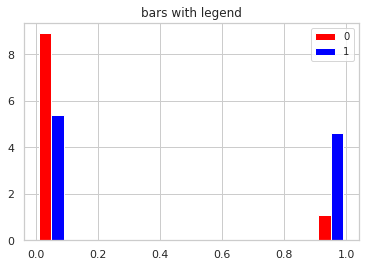

TEST_full_bayesian_0dot01_liver_with_seg_volumes: auc_score: 0.6762237762237763


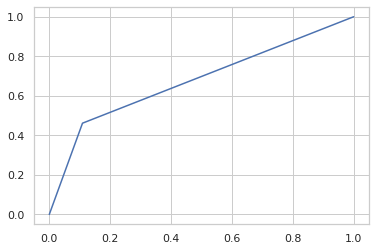

[[49  6]
 [14 12]]


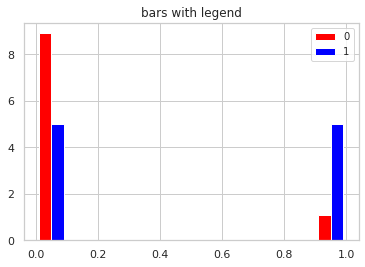

TEST_full_bayesian_0dot01_liver_with_seg_iou: auc_score: 0.6954545454545454


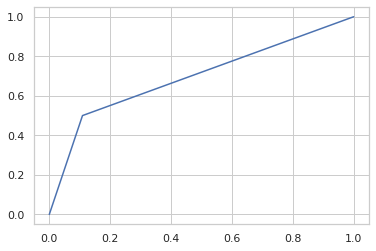

[[49  6]
 [13 13]]


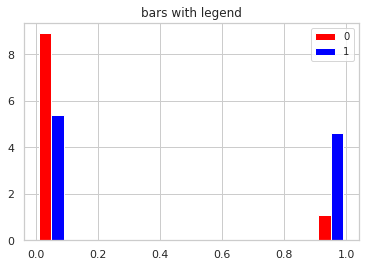

TEST_full_bayesian_0dot01_liver_with_seg_dot_iou: auc_score: 0.6762237762237763


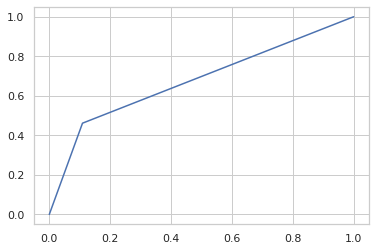

[[49  6]
 [14 12]]


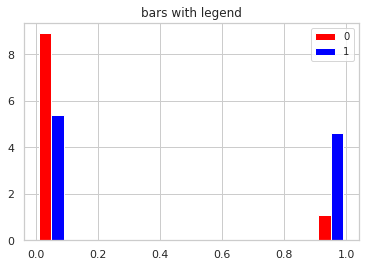

TEST_full_bayesian_0dot01_liver_with_seg_reg_iou: auc_score: 0.6762237762237763


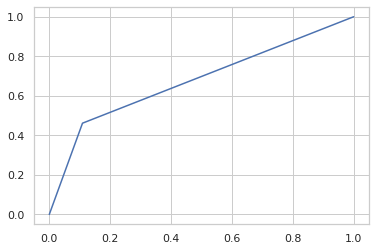

[[49  6]
 [14 12]]


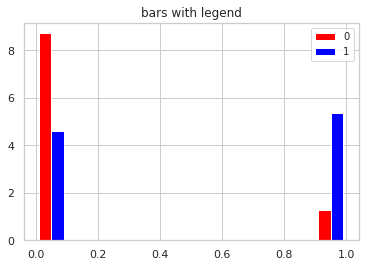

TEST_MC_dropout_quicknat_csv_features: auc_score: 0.7055944055944057


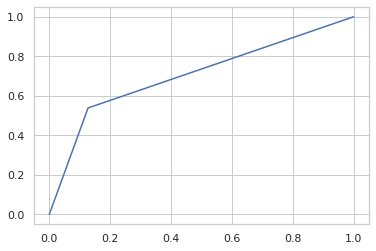

[[48  7]
 [12 14]]
['seg_liver_normalised', 'age', 'sex', 'bmi_numeric']


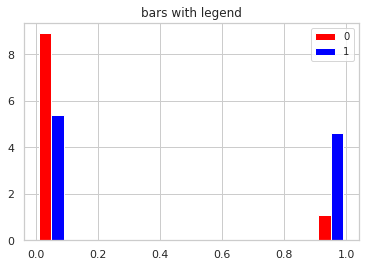

TEST_MC_dropout_quicknat_liver_with_seg_volumes: auc_score: 0.6762237762237763


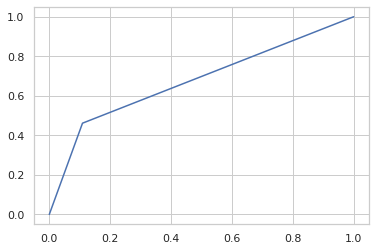

[[49  6]
 [14 12]]


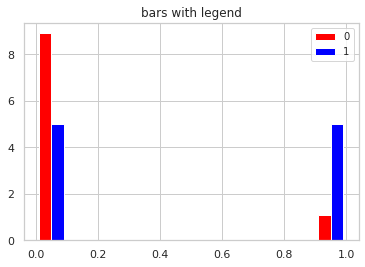

TEST_MC_dropout_quicknat_liver_with_seg_iou: auc_score: 0.6954545454545454


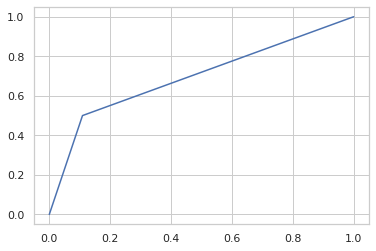

[[49  6]
 [13 13]]


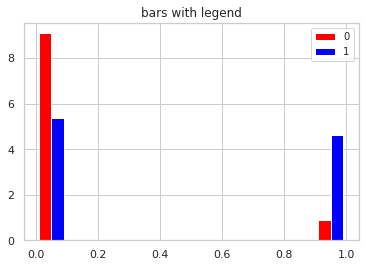

TEST_MC_dropout_quicknat_liver_with_seg_dot_iou: auc_score: 0.6853146853146853


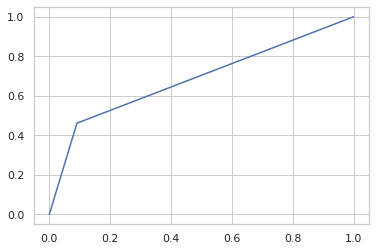

[[50  5]
 [14 12]]


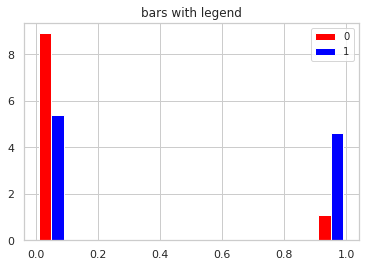

TEST_MC_dropout_quicknat_liver_with_seg_reg_iou: auc_score: 0.6762237762237763


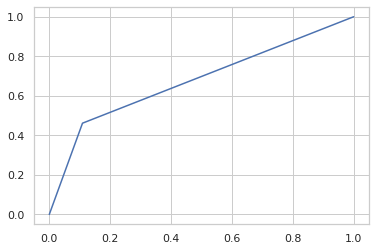

[[49  6]
 [14 12]]


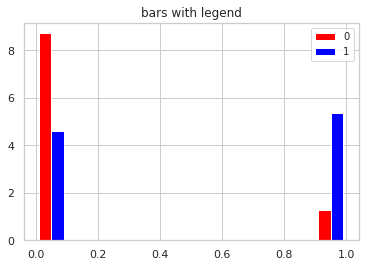

TEST_probabilistic_quicknat_csv_features: auc_score: 0.7055944055944057


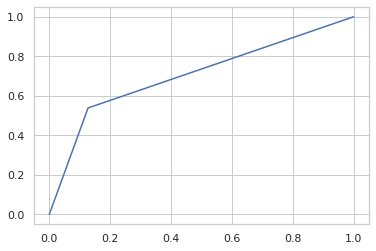

[[48  7]
 [12 14]]
['seg_liver_normalised', 'age', 'sex', 'bmi_numeric']


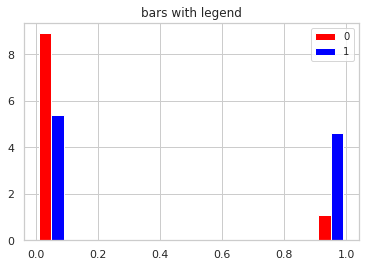

TEST_probabilistic_quicknat_liver_with_seg_volumes: auc_score: 0.6762237762237763


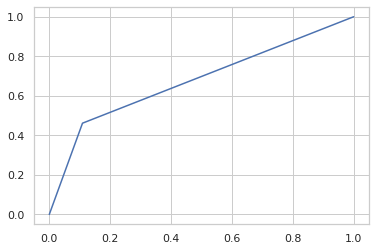

[[49  6]
 [14 12]]


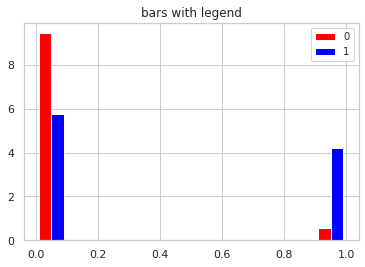

TEST_probabilistic_quicknat_liver_with_seg_iou: auc_score: 0.6842657342657342


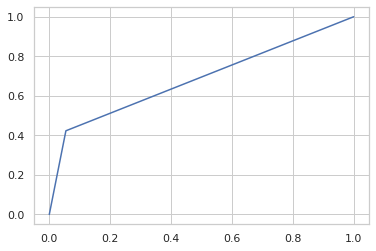

[[52  3]
 [15 11]]


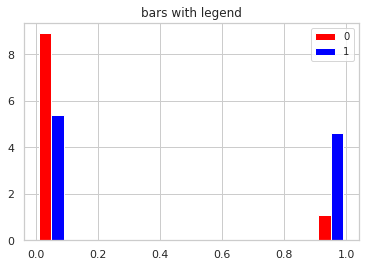

TEST_probabilistic_quicknat_liver_with_seg_dot_iou: auc_score: 0.6762237762237763


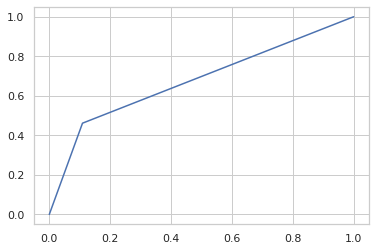

[[49  6]
 [14 12]]


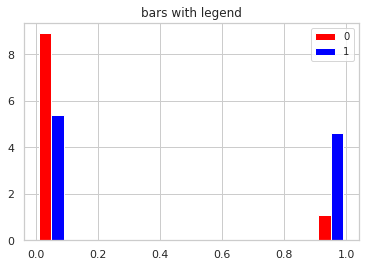

TEST_probabilistic_quicknat_liver_with_seg_reg_iou: auc_score: 0.6762237762237763


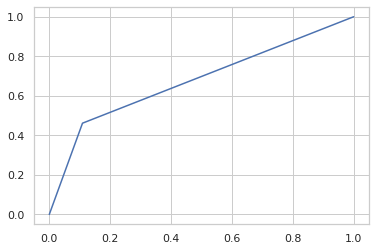

[[49  6]
 [14 12]]


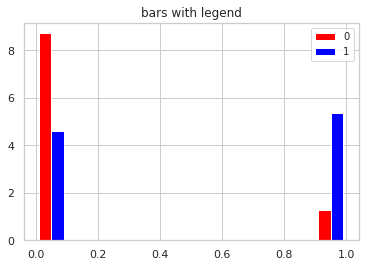

TEST_hierarchical_quicknat_csv_features: auc_score: 0.7055944055944057


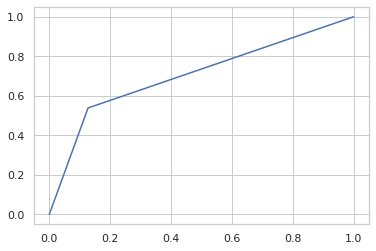

[[48  7]
 [12 14]]
['seg_liver_normalised', 'age', 'sex', 'bmi_numeric']


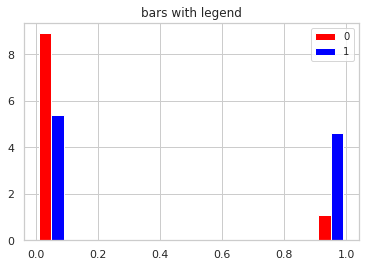

TEST_hierarchical_quicknat_liver_with_seg_volumes: auc_score: 0.6762237762237763


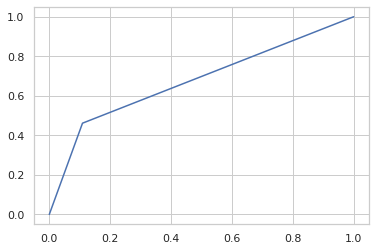

[[49  6]
 [14 12]]


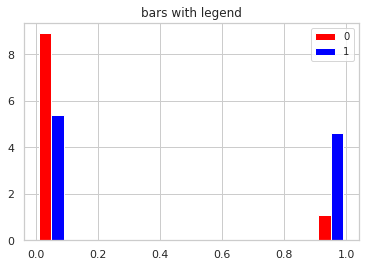

TEST_hierarchical_quicknat_liver_with_seg_iou: auc_score: 0.6762237762237763


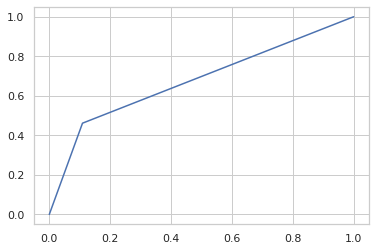

[[49  6]
 [14 12]]


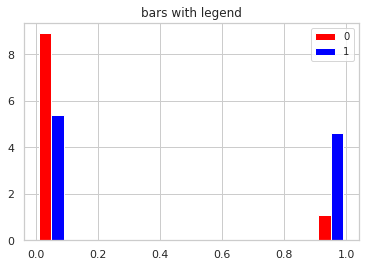

TEST_hierarchical_quicknat_liver_with_seg_dot_iou: auc_score: 0.6762237762237763


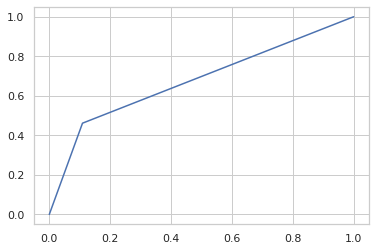

[[49  6]
 [14 12]]


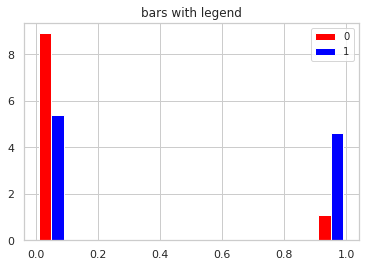

TEST_hierarchical_quicknat_liver_with_seg_reg_iou: auc_score: 0.6762237762237763


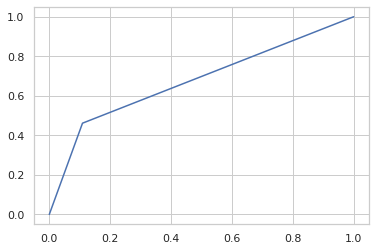

[[49  6]
 [14 12]]


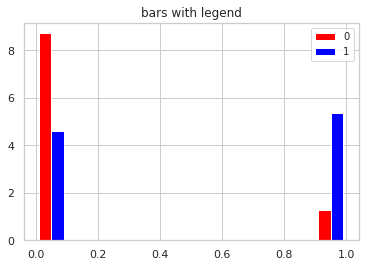

dataset_KORA_processed_csv_features: auc_score: 0.7055944055944057


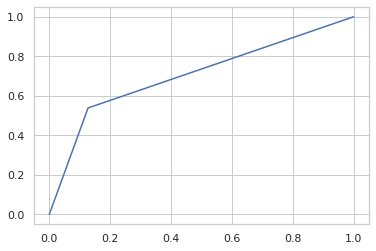

[[48  7]
 [12 14]]
['seg_liver_normalised', 'age', 'sex', 'bmi_numeric']


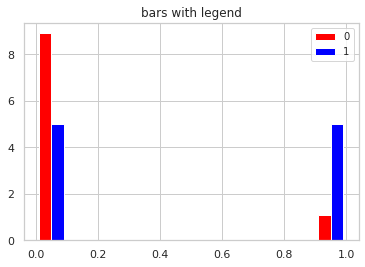

dataset_KORA_processed_liver_with_seg_volumes: auc_score: 0.6954545454545454


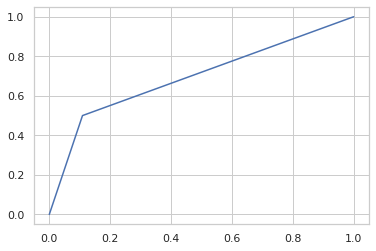

[[49  6]
 [13 13]]


,,,auc,f1
TEST_full_bayesian_0dot01_diabetes_status,diabetes_status,0,0.705594,1
TEST_full_bayesian_0dot01_diabetes_status_with_liver_seg_volumes,diabetes_status_with_liver_seg_volumes,0,0.676224,1
TEST_full_bayesian_0dot01_diabetes_status_with_liver_seg_and_iou,diabetes_status_with_liver_seg_and_iou,0,0.695455,1
TEST_full_bayesian_0dot01_diabetes_status_with_liver_seg_dot_iou,diabetes_status_with_liver_seg_dot_iou,0,0.676224,1
TEST_full_bayesian_0dot01_diabetes_status_with_liver_regularised_seg_volumes,diabetes_status_with_liver_regularised_seg_volumes,0,0.676224,1
TEST_MC_dropout_quicknat_diabetes_status,diabetes_status,0,0.705594,1
TEST_MC_dropout_quicknat_diabetes_status_with_liver_seg_volumes,diabetes_status_with_liver_seg_volumes,0,0.676224,1
TEST_MC_dropout_quicknat_diabetes_status_with_liver_seg_and_iou,diabetes_status_with_liver_seg_and_iou,0,0.695455,1
TEST_MC_dropout_quicknat_diabetes_status_with_liver_seg_dot_iou,diabetes_status_with_liver_seg_dot_iou,0,0.685315,1
TEST_MC_dropout_quicknat_diabetes_status_with_liver_regularised_seg_volumes,diabetes_status_with_liver_regularised_seg_volumes,0,0.676224,1


In [24]:
#feats = basic_feats
# basic_feats = [] #basic_feats
dicts = {}
anova_test_dicts = {}
global_kora_models = {}
# basic_feats = normalised_basic_feats
for model, df in dfs.items():
#     
#     df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver'])
#     df = df.fillna(0)

    dicts[model] = {}
    global_kora_models[model] = {}
    target_col = 'diabetes_status'
 
#   Equation 1 process
    p_values, statsmodel, y_yp = gradient_boosting_evaluations(basic_feats, df, target_col, ['sex'], True)
#     print(y_yp)
    auc_score, f1_score = auc_roc(y_yp, f'{model}_csv_features')
    dicts[model][target_col] = p_values
    dicts[model][target_col]['auc'] = auc_score
    dicts[model][target_col]['f1'] = f1_score
#     dicts, global_kora_models[model]['normal'] = aggregate_model_outputs(df, target_col, basic_feats, dicts, model, target_col)
    global_kora_models[model]['normal'] = statsmodel
#     for organ in ['spleen', 'liver']:
    organ = 'liver'
#     Equation 2 process

    feats = [ f'seg_{organ}_normalised'] + basic_feats
    print(feats)
    
    p_values, statsmodel, y_yp = gradient_boosting_evaluations(feats, df, target_col, ['sex'], True)
    auc_score, f1_score = auc_roc(y_yp, f'{model}_{organ}_with_seg_volumes')
    dicts[model][target_col+f'_with_{organ}_seg_volumes'] = p_values
    dicts[model][target_col+f'_with_{organ}_seg_volumes']['auc'] = auc_score
    dicts[model][target_col+f'_with_{organ}_seg_volumes']['f1'] = f1_score
#     dicts, global_kora_models[model][f'{organ}_seg'] = aggregate_model_outputs(df, target_col, feats, dicts, model, target_col+f'_with_{organ}_seg_volumes')
    global_kora_models[model][f'{organ}_seg'] = statsmodel
    if 'dataset' in model:
        continue

#     Equation 3 process
    feats =  [ f'seg_{organ}_normalised', f'iou_{organ}'] + basic_feats
    p_values, statsmodel, y_yp = gradient_boosting_evaluations(feats, df, target_col, ['sex'], True)
    auc_score, f1_score = auc_roc(y_yp, f'{model}_{organ}_with_seg_iou')
    dicts[model][target_col+f'_with_{organ}_seg_and_iou'] = p_values
    dicts[model][target_col+f'_with_{organ}_seg_and_iou']['auc'] = auc_score
    dicts[model][target_col+f'_with_{organ}_seg_and_iou']['f1'] = f1_score
#     dicts, global_kora_models[model][f'{organ}_seg_iou'] = aggregate_model_outputs(df, target_col, feats, dicts, model,target_col+f'_with_{organ}_seg_and_iou')
    global_kora_models[model][f'{organ}_seg_iou'] = statsmodel
#     Equation 3.1 process
    feats =  [f'seg_{organ}_normalised' , f'iou_dot_seg_{organ}_normalised'] + basic_feats
    p_values, statsmodel, y_yp = gradient_boosting_evaluations(feats, df, target_col, ['sex'], True)
    auc_score, f1_score = auc_roc(y_yp, f'{model}_{organ}_with_seg_dot_iou')
    dicts[model][target_col+f'_with_{organ}_seg_dot_iou'] = p_values
    dicts[model][target_col+f'_with_{organ}_seg_dot_iou']['auc'] = auc_score
    dicts[model][target_col+f'_with_{organ}_seg_dot_iou']['f1'] = f1_score
#     dicts, global_kora_models[model][f'{organ}_seg_dot_iou'] = aggregate_model_outputs(df, target_col, feats, dicts, model, target_col+f'_with_{organ}_seg_dot_iou')
    global_kora_models[model][f'{organ}_seg_dot_iou'] = statsmodel


#     Equation 4 process
    feats = [ f'seg_{organ}'] + basic_feats
    p_values, statsmodel, y_yp = weighted_gradient_boosting_evaluations(df, target_col, feats, f'iou_{organ}')
    auc_score, f1_score = auc_roc(y_yp, f'{model}_{organ}_with_seg_reg_iou')
    dicts[model][target_col+f'_with_{organ}_regularised_seg_volumes'] = p_values
    dicts[model][target_col+f'_with_{organ}_regularised_seg_volumes']['auc'] = auc_score
    dicts[model][target_col+f'_with_{organ}_regularised_seg_volumes']['f1'] = f1_score
#     dicts, global_kora_models[model][f'{organ}_seg_reg_iou'] = aggregate_model_outputs(df, target_col, feats,  dicts, model, target_col+f'_with_{organ}_regularised_seg_volumes',None,  f'iou_mean')
    global_kora_models[model][f'{organ}_seg_reg_iou'] =  statsmodel

    
p_value_df_ka = df_from_nested_dicts(dicts).T
p_value_df_styler_ka = highlight_significance(p_value_df_ka, 0.05)
p_value_df_styler_ka

In [25]:
p_value_df_ka[['auc' ]]

,,,auc
TEST_full_bayesian_0dot01_diabetes_status,diabetes_status,0,0.705594
TEST_full_bayesian_0dot01_diabetes_status_with_liver_seg_volumes,diabetes_status_with_liver_seg_volumes,0,0.676224
TEST_full_bayesian_0dot01_diabetes_status_with_liver_seg_and_iou,diabetes_status_with_liver_seg_and_iou,0,0.695455
TEST_full_bayesian_0dot01_diabetes_status_with_liver_seg_dot_iou,diabetes_status_with_liver_seg_dot_iou,0,0.676224
TEST_full_bayesian_0dot01_diabetes_status_with_liver_regularised_seg_volumes,diabetes_status_with_liver_regularised_seg_volumes,0,0.676224
TEST_MC_dropout_quicknat_diabetes_status,diabetes_status,0,0.705594
TEST_MC_dropout_quicknat_diabetes_status_with_liver_seg_volumes,diabetes_status_with_liver_seg_volumes,0,0.676224
TEST_MC_dropout_quicknat_diabetes_status_with_liver_seg_and_iou,diabetes_status_with_liver_seg_and_iou,0,0.695455
TEST_MC_dropout_quicknat_diabetes_status_with_liver_seg_dot_iou,diabetes_status_with_liver_seg_dot_iou,0,0.685315
TEST_MC_dropout_quicknat_diabetes_status_with_liver_regularised_seg_volumes,diabetes_status_with_liver_regularised_seg_volumes,0,0.676224


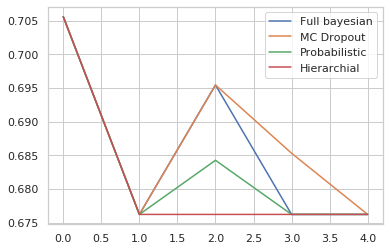

In [26]:
vals = p_value_df_ka[['auc']].values[:-2].reshape(4,-1)
vals = vals.T

plt.plot(vals[:, 0], label='Full bayesian')
plt.plot(vals[:, 1], label='MC Dropout')
plt.plot(vals[:, 2], label='Probabilistic')
plt.plot(vals[:, 3], label='Hierarchial')

plt.legend()
plt.show()

#0-base, 1-seg, 2-seg_iou, 3-seg_dot_iou, 4-seg_reg_iou

TEST_full_bayesian_0dot01
const           1.0
age            58.0
sex             1.0
bmi_numeric    34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 1 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


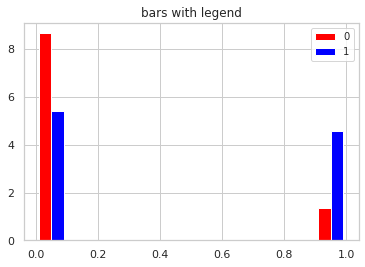

ensemble: auc_score: 0.6625


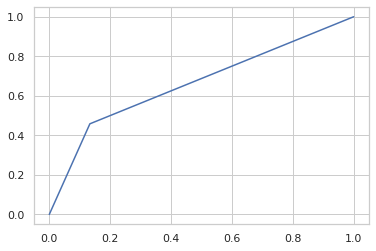

[[39  6]
 [13 11]]
const                    1.000000
seg_liver_normalised     0.471301
age                     58.000000
sex                      1.000000
bmi_numeric             34.400000
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


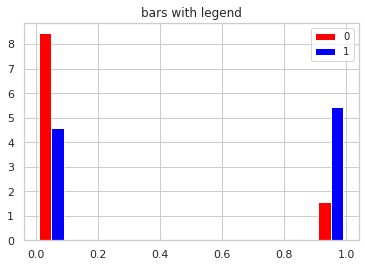

ensemble: auc_score: 0.6930555555555555


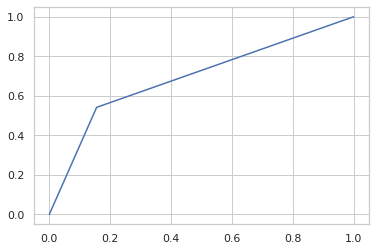

[[38  7]
 [11 13]]
const                    1.000000
seg_liver_normalised     0.471301
iou_liver                0.820428
age                     58.000000
sex                      1.000000
bmi_numeric             34.400000
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


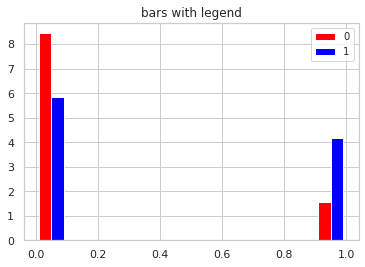

ensemble: auc_score: 0.6305555555555556


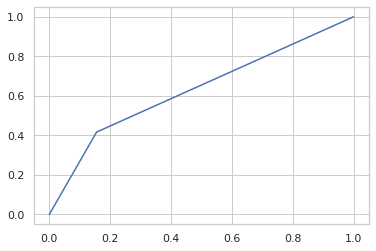

[[38  7]
 [14 10]]
const                            1.000000
seg_liver_normalised             0.471301
iou_dot_seg_liver_normalised     0.626995
age                             58.000000
sex                              1.000000
bmi_numeric                     34.400000
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


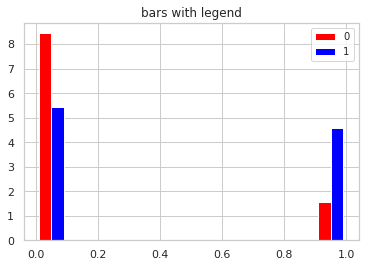

ensemble: auc_score: 0.6513888888888888


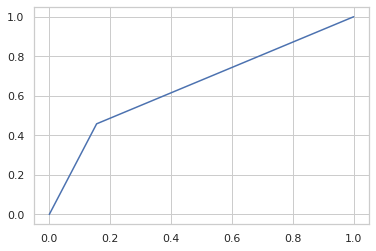

[[38  7]
 [13 11]]
const                1.0
seg_liver      1830540.0
age                 58.0
sex                  1.0
bmi_numeric         34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


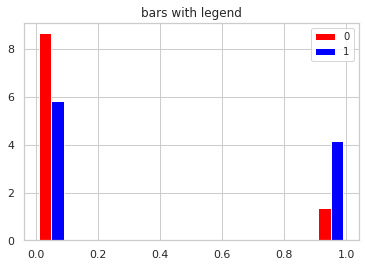

ensemble: auc_score: 0.6416666666666667


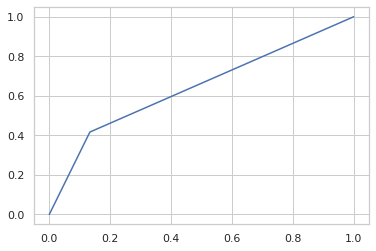

[[39  6]
 [14 10]]
const               1.0
0_liver        152439.0
age                58.0
sex                 1.0
bmi_numeric        34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


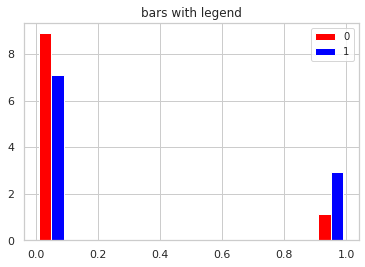

ensemble: auc_score: 0.5902777777777778


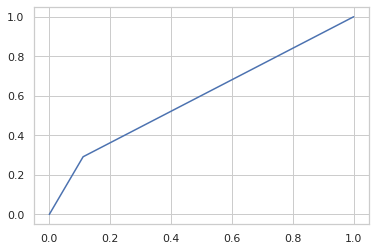

[[40  5]
 [17  7]]
const               1.0
1_liver        153508.0
age                58.0
sex                 1.0
bmi_numeric        34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


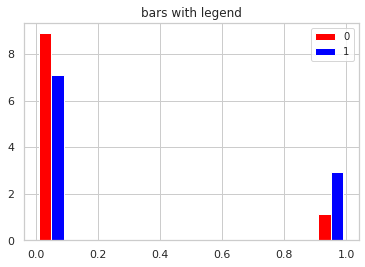

ensemble: auc_score: 0.5902777777777778


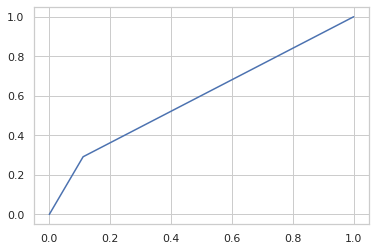

[[40  5]
 [17  7]]
const               1.0
2_liver        151281.0
age                58.0
sex                 1.0
bmi_numeric        34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


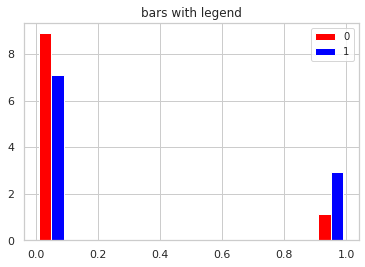

ensemble: auc_score: 0.5902777777777778


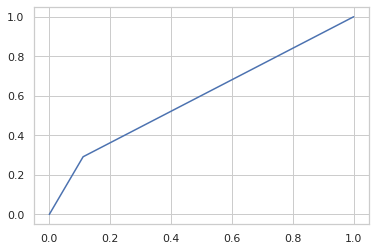

[[40  5]
 [17  7]]
const               1.0
3_liver        153655.0
age                58.0
sex                 1.0
bmi_numeric        34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


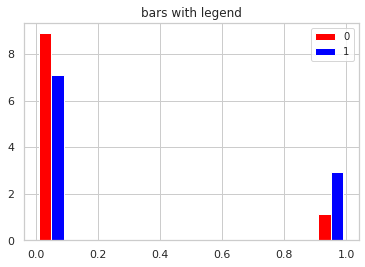

ensemble: auc_score: 0.5902777777777778


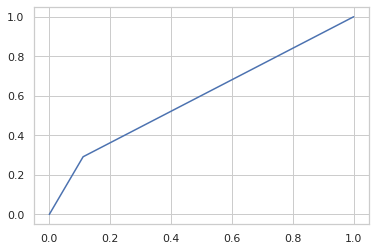

[[40  5]
 [17  7]]
const               1.0
4_liver        153018.0
age                58.0
sex                 1.0
bmi_numeric        34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


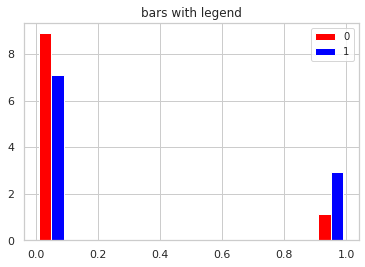

ensemble: auc_score: 0.5902777777777778


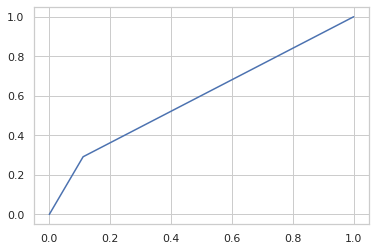

[[40  5]
 [17  7]]
const               1.0
5_liver        153420.0
age                58.0
sex                 1.0
bmi_numeric        34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


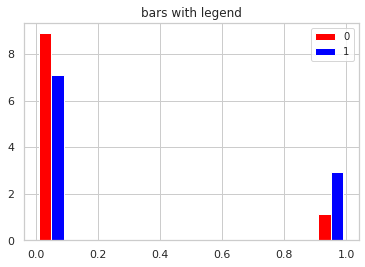

ensemble: auc_score: 0.5902777777777778


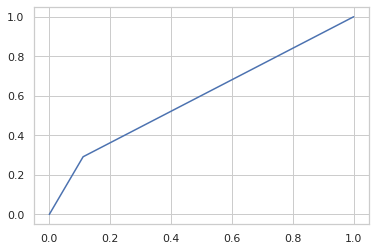

[[40  5]
 [17  7]]
const               1.0
6_liver        152172.0
age                58.0
sex                 1.0
bmi_numeric        34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


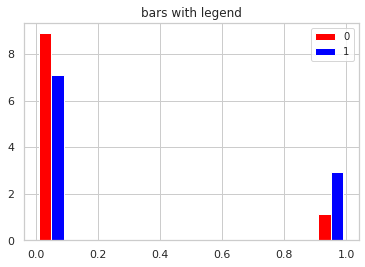

ensemble: auc_score: 0.5902777777777778


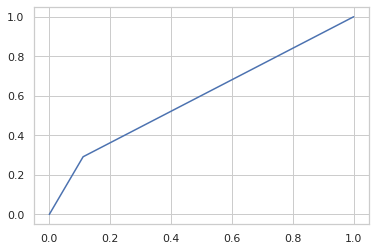

[[40  5]
 [17  7]]
const               1.0
7_liver        153294.0
age                58.0
sex                 1.0
bmi_numeric        34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


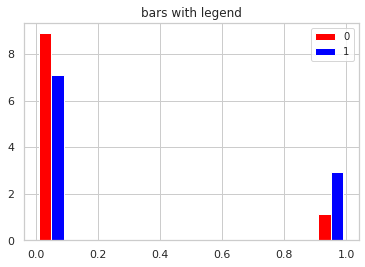

ensemble: auc_score: 0.5902777777777778


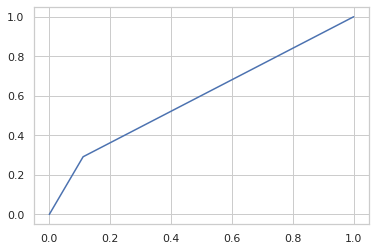

[[40  5]
 [17  7]]
const               1.0
8_liver        152572.0
age                58.0
sex                 1.0
bmi_numeric        34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


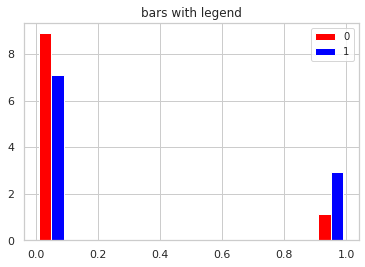

ensemble: auc_score: 0.5902777777777778


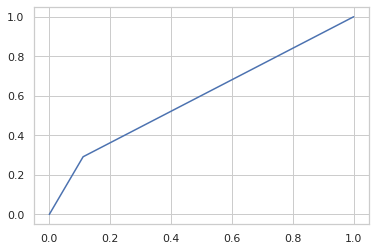

[[40  5]
 [17  7]]
const               1.0
9_liver        153241.0
age                58.0
sex                 1.0
bmi_numeric        34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


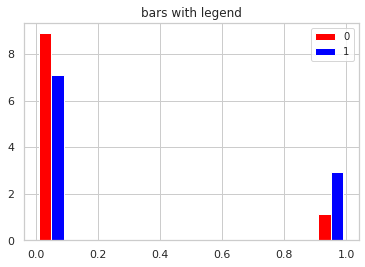

ensemble: auc_score: 0.5902777777777778


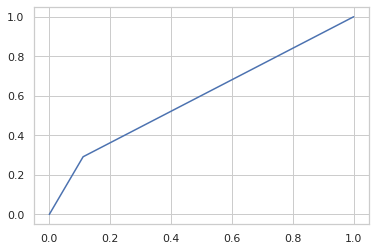

[[40  5]
 [17  7]]
TEST_MC_dropout_quicknat
const           1.0
age            58.0
sex             1.0
bmi_numeric    34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


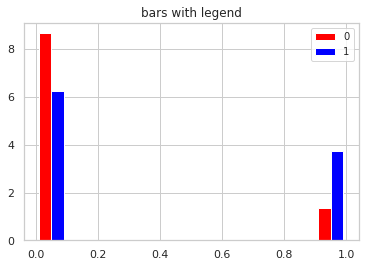

ensemble: auc_score: 0.6208333333333333


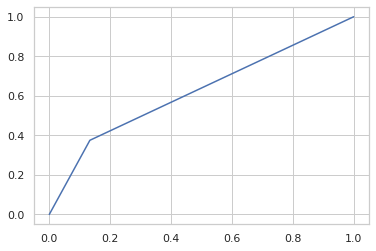

[[39  6]
 [15  9]]
const                    1.000000
seg_liver_normalised     0.358252
age                     58.000000
sex                      1.000000
bmi_numeric             34.400000
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


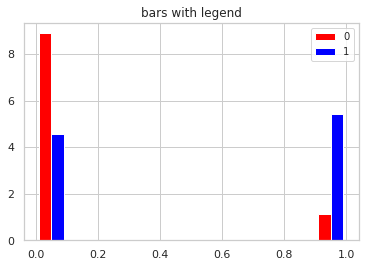

ensemble: auc_score: 0.7152777777777777


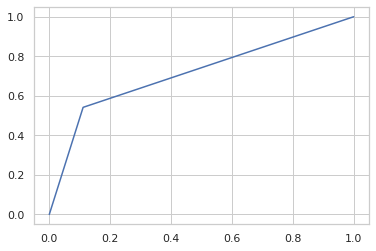

[[40  5]
 [11 13]]
const                    1.000000
seg_liver_normalised     0.358252
iou_liver                0.862040
age                     58.000000
sex                      1.000000
bmi_numeric             34.400000
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


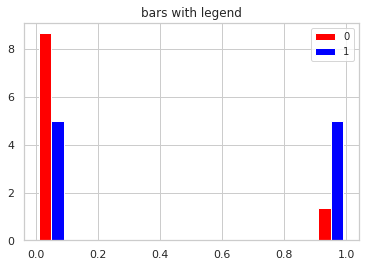

ensemble: auc_score: 0.6833333333333333


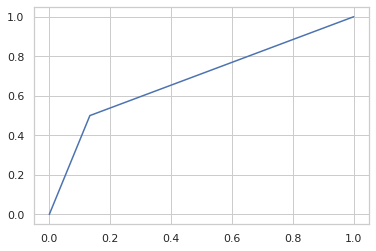

[[39  6]
 [12 12]]
const                            1.000000
seg_liver_normalised             0.358252
iou_dot_seg_liver_normalised     0.377707
age                             58.000000
sex                              1.000000
bmi_numeric                     34.400000
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


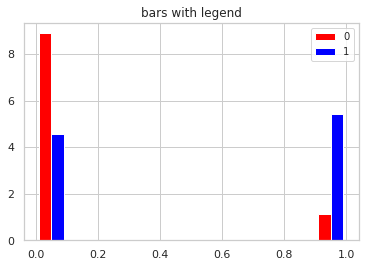

ensemble: auc_score: 0.7152777777777777


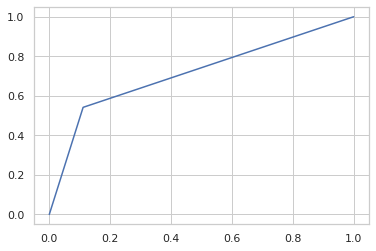

[[40  5]
 [11 13]]
const                1.0
seg_liver      1796208.0
age                 58.0
sex                  1.0
bmi_numeric         34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


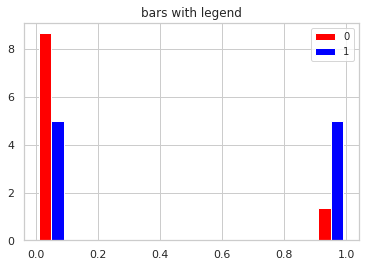

ensemble: auc_score: 0.6833333333333333


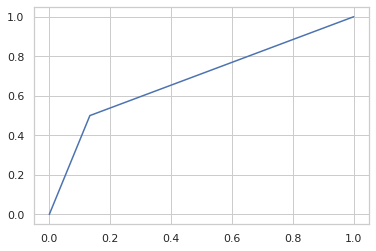

[[39  6]
 [12 12]]
const                1.0
0_liver        1785324.0
age                 58.0
sex                  1.0
bmi_numeric         34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


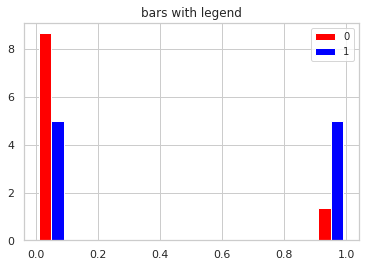

ensemble: auc_score: 0.6833333333333333


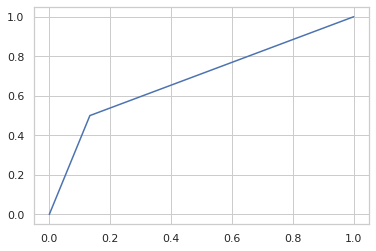

[[39  6]
 [12 12]]
const                1.0
1_liver        1804164.0
age                 58.0
sex                  1.0
bmi_numeric         34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


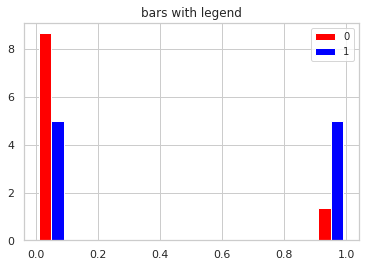

ensemble: auc_score: 0.6833333333333333


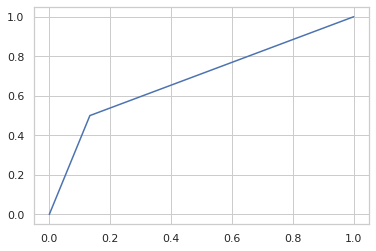

[[39  6]
 [12 12]]
const                1.0
2_liver        1804560.0
age                 58.0
sex                  1.0
bmi_numeric         34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


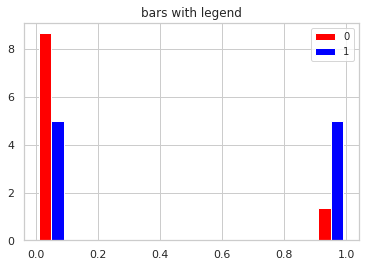

ensemble: auc_score: 0.6833333333333333


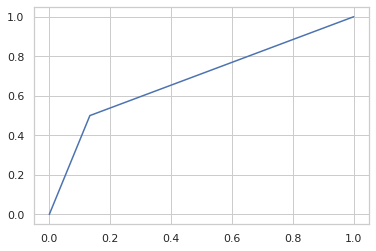

[[39  6]
 [12 12]]
const                1.0
3_liver        1790496.0
age                 58.0
sex                  1.0
bmi_numeric         34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


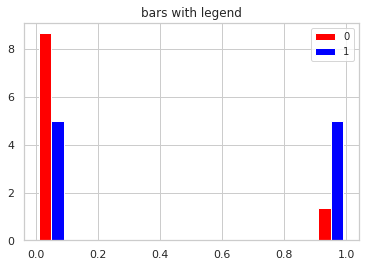

ensemble: auc_score: 0.6833333333333333


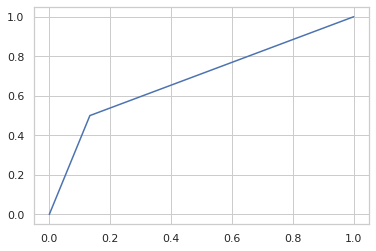

[[39  6]
 [12 12]]
const                1.0
4_liver        1802832.0
age                 58.0
sex                  1.0
bmi_numeric         34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


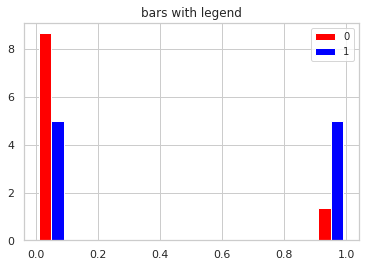

ensemble: auc_score: 0.6833333333333333


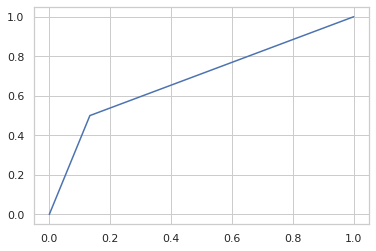

[[39  6]
 [12 12]]
const                1.0
5_liver        1790160.0
age                 58.0
sex                  1.0
bmi_numeric         34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


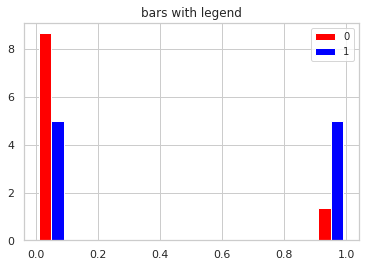

ensemble: auc_score: 0.6833333333333333


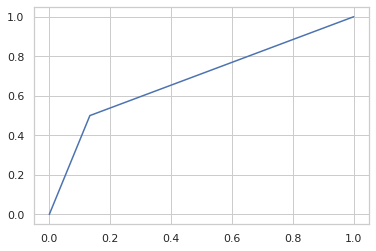

[[39  6]
 [12 12]]
const                1.0
6_liver        1796460.0
age                 58.0
sex                  1.0
bmi_numeric         34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


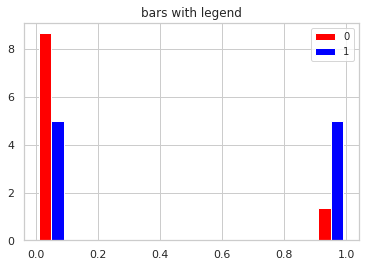

ensemble: auc_score: 0.6833333333333333


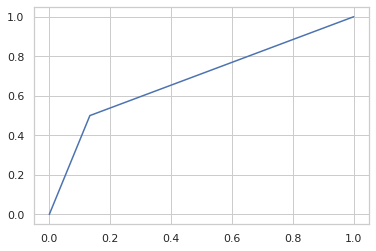

[[39  6]
 [12 12]]
const                1.0
7_liver        1787316.0
age                 58.0
sex                  1.0
bmi_numeric         34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


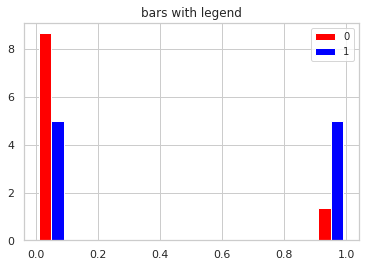

ensemble: auc_score: 0.6833333333333333


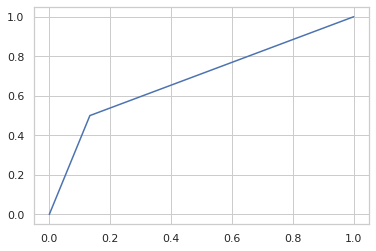

[[39  6]
 [12 12]]
const                1.0
8_liver        1801092.0
age                 58.0
sex                  1.0
bmi_numeric         34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


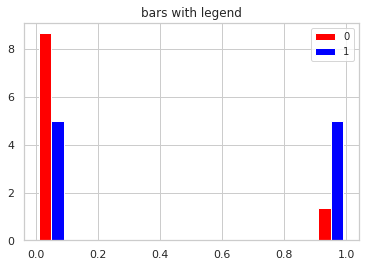

ensemble: auc_score: 0.6833333333333333


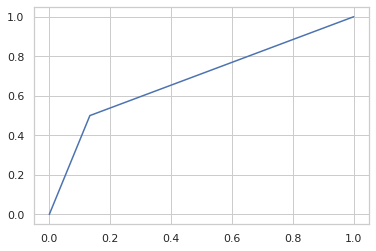

[[39  6]
 [12 12]]
const                1.0
9_liver        1797012.0
age                 58.0
sex                  1.0
bmi_numeric         34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


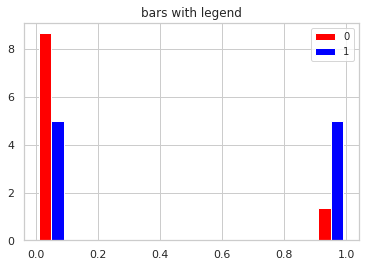

ensemble: auc_score: 0.6833333333333333


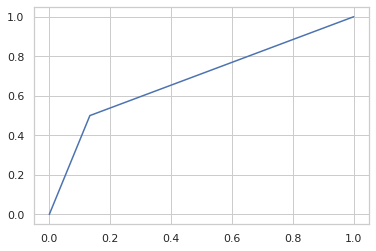

[[39  6]
 [12 12]]
TEST_probabilistic_quicknat
const           1.0
age            58.0
sex             1.0
bmi_numeric    34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


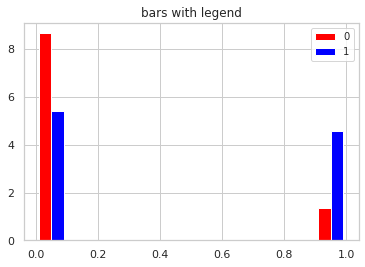

ensemble: auc_score: 0.6625


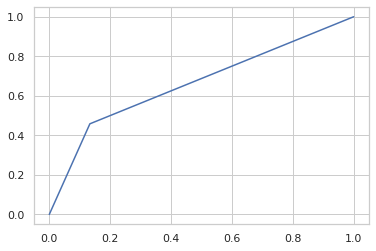

[[39  6]
 [13 11]]
const                    1.000000
seg_liver_normalised     0.506703
age                     58.000000
sex                      1.000000
bmi_numeric             34.400000
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


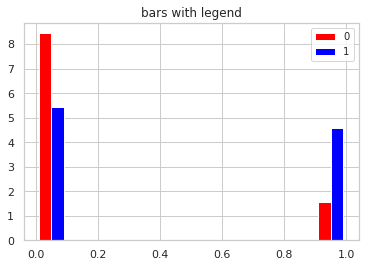

ensemble: auc_score: 0.6513888888888888


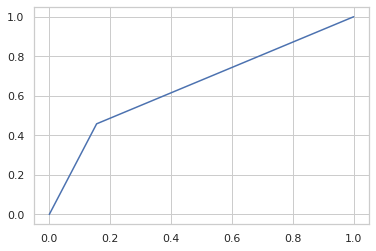

[[38  7]
 [13 11]]
const                    1.000000
seg_liver_normalised     0.506703
iou_liver                0.991304
age                     58.000000
sex                      1.000000
bmi_numeric             34.400000
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


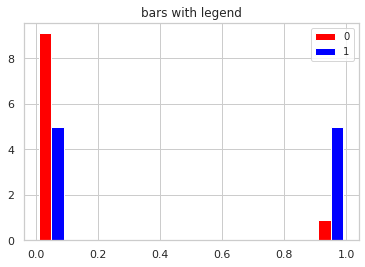

ensemble: auc_score: 0.7055555555555556


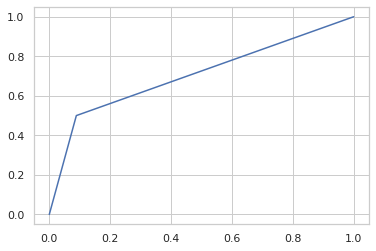

[[41  4]
 [12 12]]
const                            1.000000
seg_liver_normalised             0.506703
iou_dot_seg_liver_normalised     0.515149
age                             58.000000
sex                              1.000000
bmi_numeric                     34.400000
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


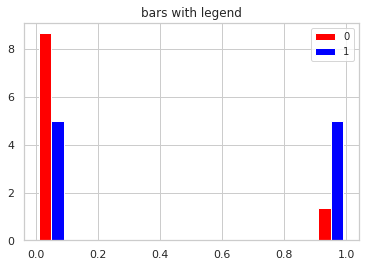

ensemble: auc_score: 0.6833333333333333


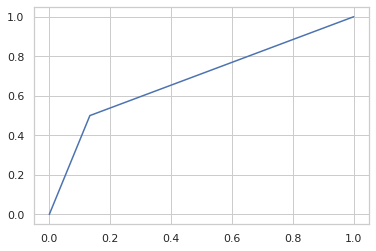

[[39  6]
 [12 12]]
const                1.0
seg_liver      1765512.0
age                 58.0
sex                  1.0
bmi_numeric         34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


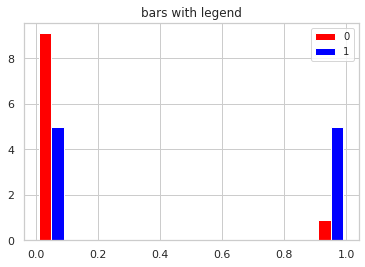

ensemble: auc_score: 0.7055555555555556


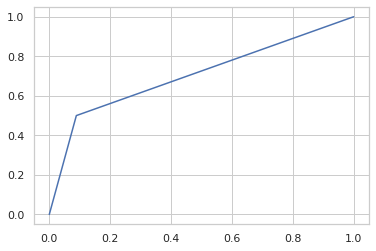

[[41  4]
 [12 12]]
const                1.0
0_liver        1766472.0
age                 58.0
sex                  1.0
bmi_numeric         34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


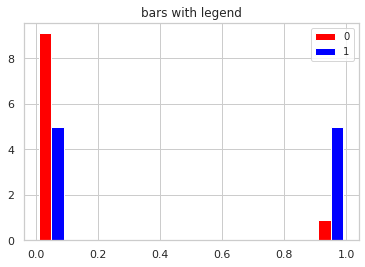

ensemble: auc_score: 0.7055555555555556


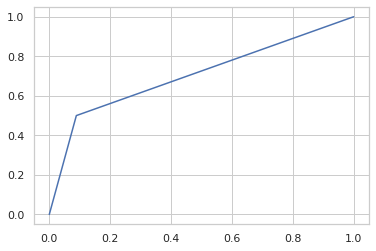

[[41  4]
 [12 12]]
const                1.0
1_liver        1766448.0
age                 58.0
sex                  1.0
bmi_numeric         34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


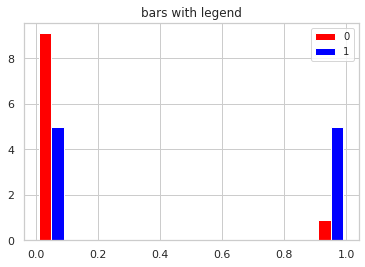

ensemble: auc_score: 0.7055555555555556


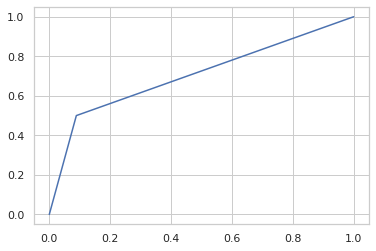

[[41  4]
 [12 12]]
const                1.0
2_liver        1766028.0
age                 58.0
sex                  1.0
bmi_numeric         34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


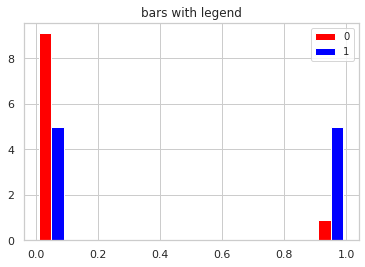

ensemble: auc_score: 0.7055555555555556


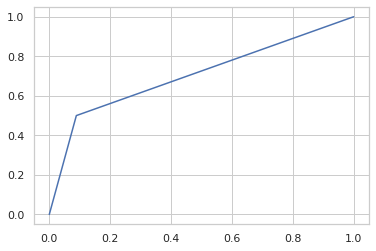

[[41  4]
 [12 12]]
const                1.0
3_liver        1765788.0
age                 58.0
sex                  1.0
bmi_numeric         34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


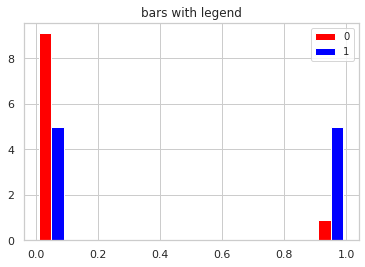

ensemble: auc_score: 0.7055555555555556


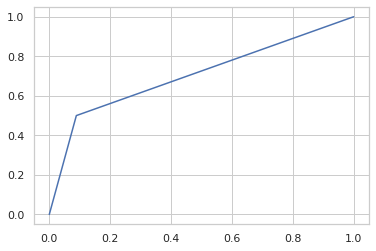

[[41  4]
 [12 12]]
const                1.0
4_liver        1765560.0
age                 58.0
sex                  1.0
bmi_numeric         34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


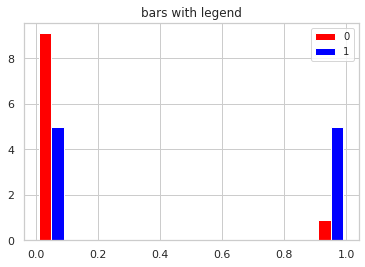

ensemble: auc_score: 0.7055555555555556


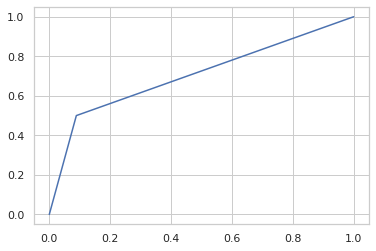

[[41  4]
 [12 12]]
const                1.0
5_liver        1764756.0
age                 58.0
sex                  1.0
bmi_numeric         34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


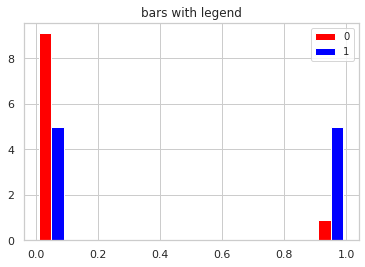

ensemble: auc_score: 0.7055555555555556


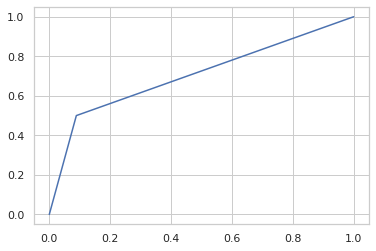

[[41  4]
 [12 12]]
const                1.0
6_liver        1765824.0
age                 58.0
sex                  1.0
bmi_numeric         34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


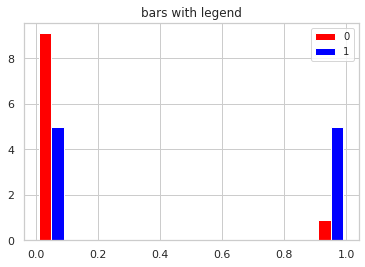

ensemble: auc_score: 0.7055555555555556


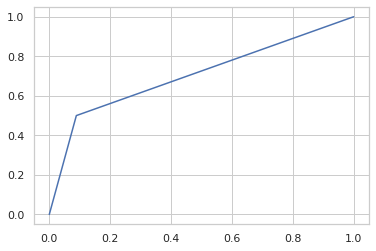

[[41  4]
 [12 12]]
const                1.0
7_liver        1764480.0
age                 58.0
sex                  1.0
bmi_numeric         34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


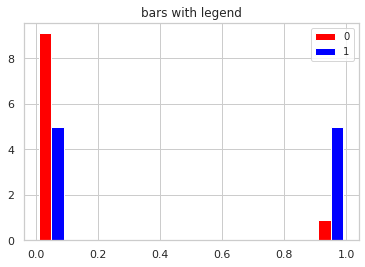

ensemble: auc_score: 0.7055555555555556


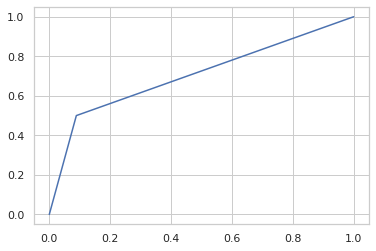

[[41  4]
 [12 12]]
const                1.0
8_liver        1762908.0
age                 58.0
sex                  1.0
bmi_numeric         34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


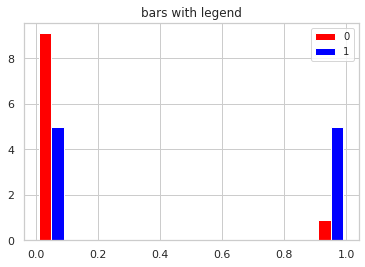

ensemble: auc_score: 0.7055555555555556


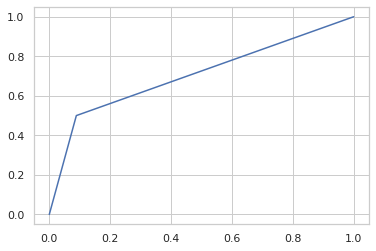

[[41  4]
 [12 12]]
const                1.0
9_liver        1765836.0
age                 58.0
sex                  1.0
bmi_numeric         34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


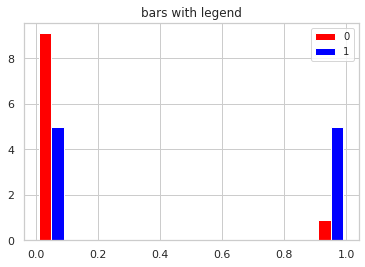

ensemble: auc_score: 0.7055555555555556


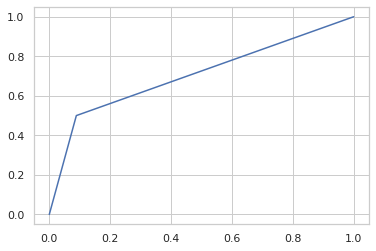

[[41  4]
 [12 12]]
TEST_hierarchical_quicknat
const           1.0
age            58.0
sex             1.0
bmi_numeric    34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 1 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


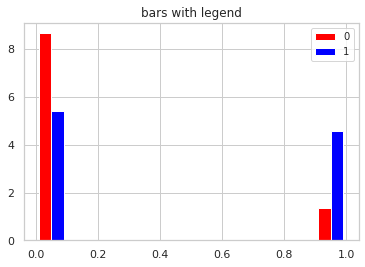

ensemble: auc_score: 0.6625


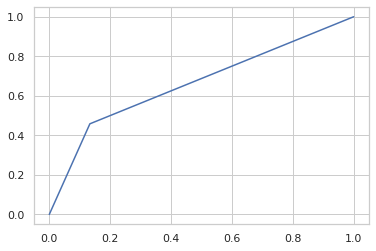

[[39  6]
 [13 11]]
const                    1.000000
seg_liver_normalised     0.407188
age                     58.000000
sex                      1.000000
bmi_numeric             34.400000
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


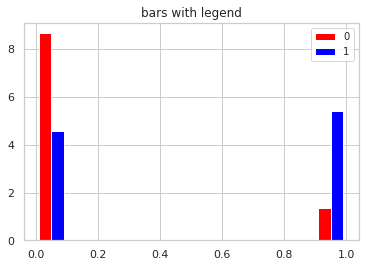

ensemble: auc_score: 0.7041666666666666


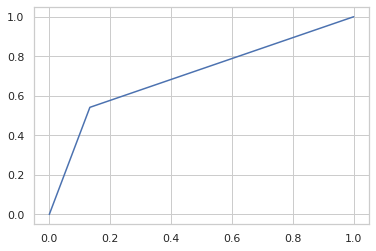

[[39  6]
 [11 13]]
const                    1.000000
seg_liver_normalised     0.407188
iou_liver                0.987869
age                     58.000000
sex                      1.000000
bmi_numeric             34.400000
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


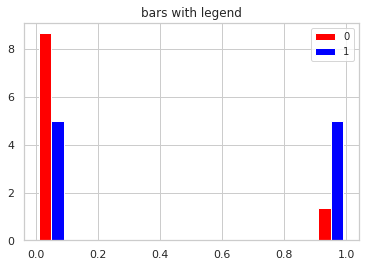

ensemble: auc_score: 0.6833333333333333


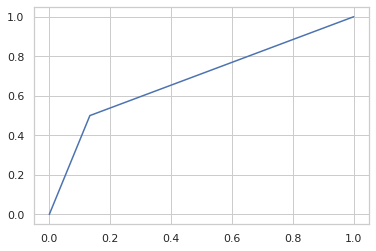

[[39  6]
 [12 12]]
const                            1.000000
seg_liver_normalised             0.407188
iou_dot_seg_liver_normalised     0.415651
age                             58.000000
sex                              1.000000
bmi_numeric                     34.400000
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


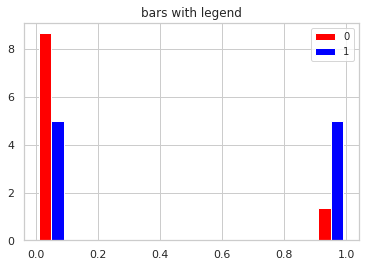

ensemble: auc_score: 0.6833333333333333


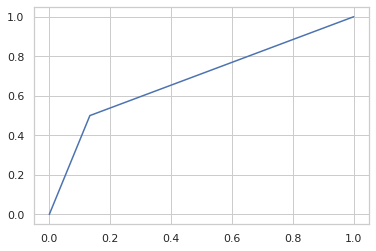

[[39  6]
 [12 12]]
const                1.0
seg_liver      1814784.0
age                 58.0
sex                  1.0
bmi_numeric         34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


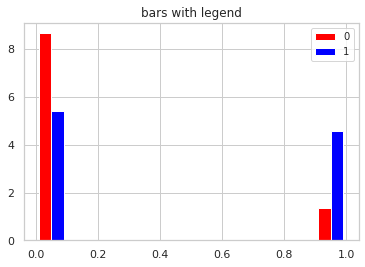

ensemble: auc_score: 0.6625


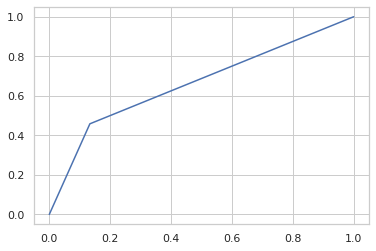

[[39  6]
 [13 11]]
const               1.0
0_liver        151304.0
age                58.0
sex                 1.0
bmi_numeric        34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


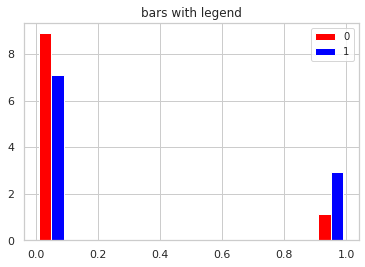

ensemble: auc_score: 0.5902777777777778


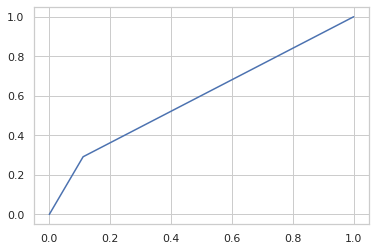

[[40  5]
 [17  7]]
const               1.0
1_liver        151176.0
age                58.0
sex                 1.0
bmi_numeric        34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


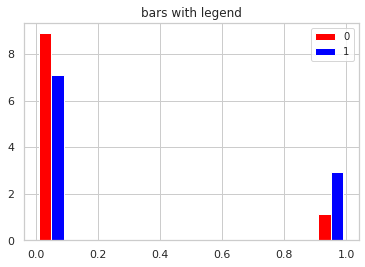

ensemble: auc_score: 0.5902777777777778


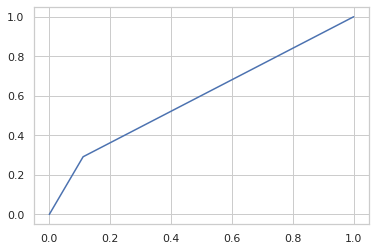

[[40  5]
 [17  7]]
const               1.0
2_liver        151228.0
age                58.0
sex                 1.0
bmi_numeric        34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


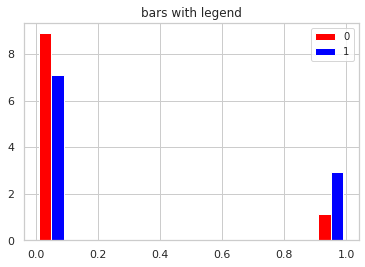

ensemble: auc_score: 0.5902777777777778


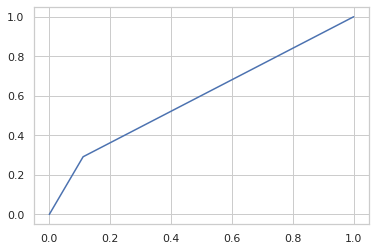

[[40  5]
 [17  7]]
const               1.0
3_liver        151195.0
age                58.0
sex                 1.0
bmi_numeric        34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


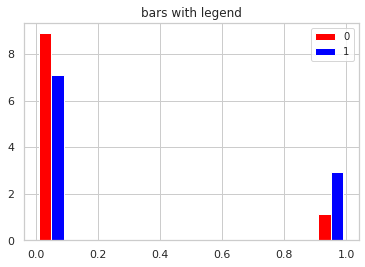

ensemble: auc_score: 0.5902777777777778


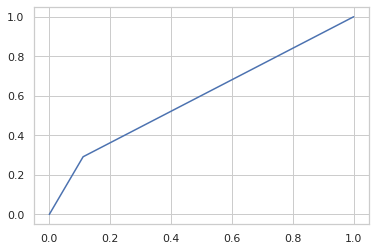

[[40  5]
 [17  7]]
const               1.0
4_liver        151163.0
age                58.0
sex                 1.0
bmi_numeric        34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


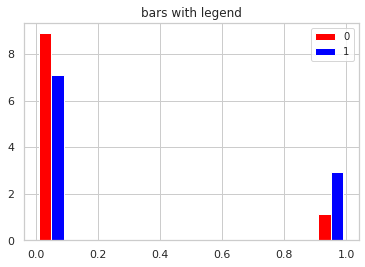

ensemble: auc_score: 0.5902777777777778


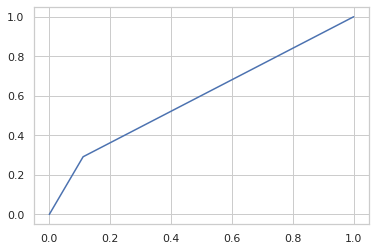

[[40  5]
 [17  7]]
const               1.0
5_liver        151197.0
age                58.0
sex                 1.0
bmi_numeric        34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


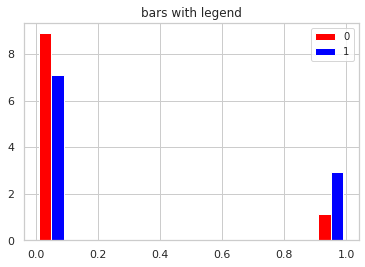

ensemble: auc_score: 0.5902777777777778


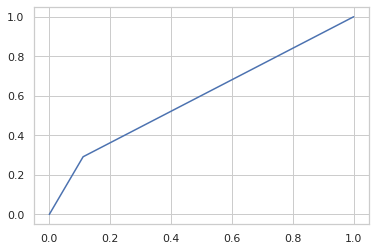

[[40  5]
 [17  7]]
const               1.0
6_liver        151257.0
age                58.0
sex                 1.0
bmi_numeric        34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


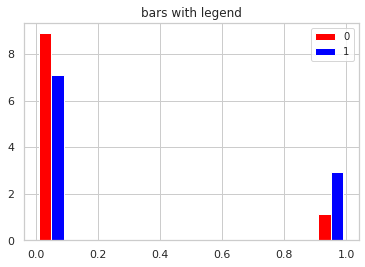

ensemble: auc_score: 0.5902777777777778


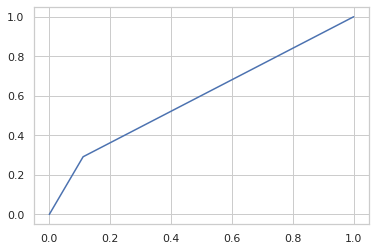

[[40  5]
 [17  7]]
const               1.0
7_liver        151201.0
age                58.0
sex                 1.0
bmi_numeric        34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


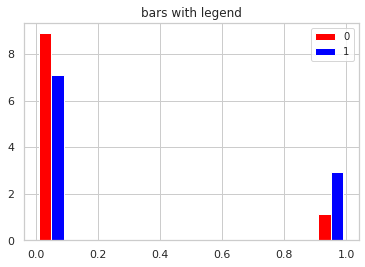

ensemble: auc_score: 0.5902777777777778


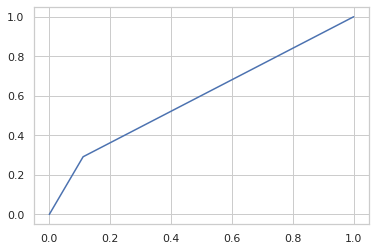

[[40  5]
 [17  7]]
const               1.0
8_liver        151290.0
age                58.0
sex                 1.0
bmi_numeric        34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


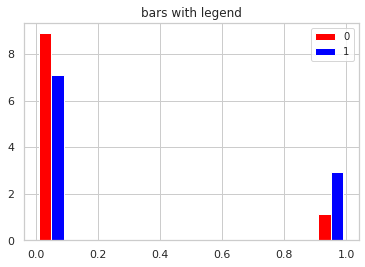

ensemble: auc_score: 0.5902777777777778


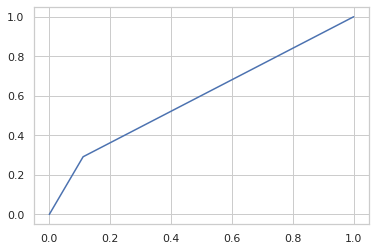

[[40  5]
 [17  7]]
const               1.0
9_liver        151304.0
age                58.0
sex                 1.0
bmi_numeric        34.4
Name: 2, dtype: float64
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]


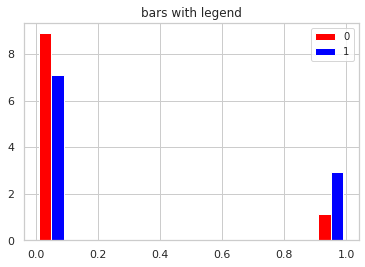

ensemble: auc_score: 0.5902777777777778


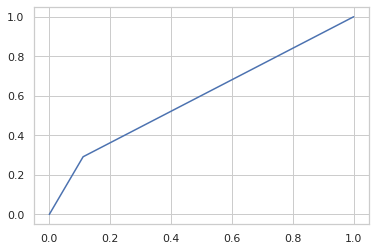

[[40  5]
 [17  7]]
dataset_KORA_processed
const           1.00
age            62.00
sex             0.00
bmi_numeric    22.48
Name: 18, dtype: float64
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 1 0 1 1 0 1 0 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0] [0 1 1 1 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0 1 1 0
 1 1 0 0 0 0 1 0 0 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0]


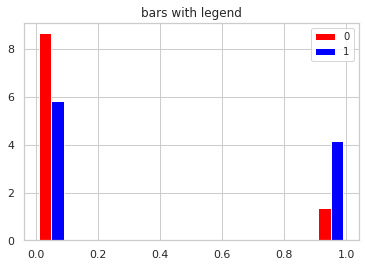

ensemble: auc_score: 0.6416666666666667


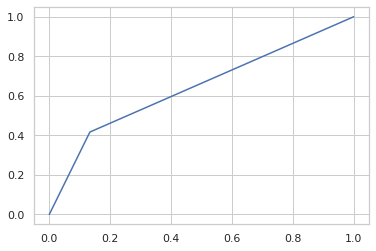

[[39  6]
 [14 10]]
const                    1.000000
seg_liver_normalised     0.143171
age                     62.000000
sex                      0.000000
bmi_numeric             22.480000
Name: 18, dtype: float64
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0] [0 1 1 1 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0 1 1 0
 1 1 0 0 0 0 1 0 0 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0]


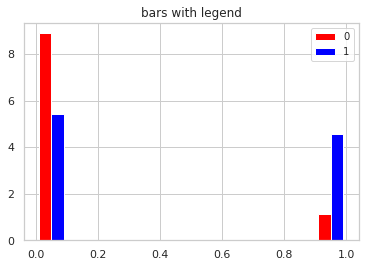

ensemble: auc_score: 0.6736111111111109


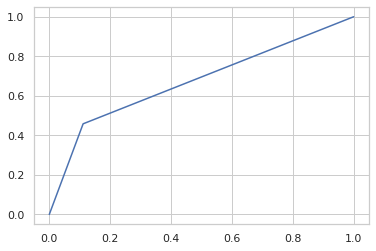

[[40  5]
 [13 11]]


,,,v_scoring,v_scoring_with_weight,v_auc
TRAIN_full_bayesian_0dot01_diabetes_status,diabetes_status,0,1,1,0.6625
TRAIN_full_bayesian_0dot01_diabetes_status_liver_with_seg_volumes,diabetes_status_liver_with_seg_volumes,0,1,1,0.693056
TRAIN_full_bayesian_0dot01_diabetes_status_liver_with_seg_and_iou,diabetes_status_liver_with_seg_and_iou,0,1,1,0.630556
TRAIN_full_bayesian_0dot01_diabetes_status_liver_with_seg_dot_iou,diabetes_status_liver_with_seg_dot_iou,0,1,1,0.651389
TRAIN_full_bayesian_0dot01_diabetes_status_liver_seg_reg_iou,diabetes_status_liver_seg_reg_iou,0,1,1,0.641667
TRAIN_full_bayesian_0dot01_diabetes_status_liver_seg_reg_iou_sampled,diabetes_status_liver_seg_reg_iou_sampled,0,1,1,0.590278
TRAIN_MC_dropout_quicknat_diabetes_status,diabetes_status,0,1,1,0.620833
TRAIN_MC_dropout_quicknat_diabetes_status_liver_with_seg_volumes,diabetes_status_liver_with_seg_volumes,0,1,1,0.715278
TRAIN_MC_dropout_quicknat_diabetes_status_liver_with_seg_and_iou,diabetes_status_liver_with_seg_and_iou,0,1,1,0.683333
TRAIN_MC_dropout_quicknat_diabetes_status_liver_with_seg_dot_iou,diabetes_status_liver_with_seg_dot_iou,0,1,1,0.715278


In [27]:
# feats = [] #basic_feats
dicts = {}
anova_test_dicts = {}
# basic_feats = normalised_basic_feats
for model, df in dfs_train.items():
#     
#     df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver'])
#     df = df.fillna(0)
#     print(model)
#     if 'UKB' not in model:
# #         print('dataset cannot be processed!')
#         continue

    
#     print(df.columns)
#     break
    dicts[model] = {}
    k_mod = 'TEST' + model[5:]
    if 'dataset' in model:
        k_mod = model
        
    print(k_mod)
#     continue
    target_col = 'diabetes_status'
#     try:
#     Equation 1 process
#     p_values, statsmodel, y_yp = discrete_group_feature_stats(basic_feats, df, target_col, ['sex'], True)
#         auc_score, f1_score = auc_roc(y_yp, f'{model}_csv_feats')
    dicts[model][target_col] = {} #p_values
#         dicts[model][target_col]['auc'] = auc_score
#         dicts[model][target_col]['f1'] = f1_score
    dicts, _ = aggregate_model_outputs(df, target_col, basic_feats, dicts, model, target_col, global_kora_models[k_mod]['normal'])

#     Equation 2 process
#     for organ in ['spleen', 'liver']:
    organ = 'liver'
    feats = [ f'seg_{organ}_normalised'] + basic_feats
#         p_values, statsmodel, y_yp = discrete_group_feature_stats(feats, df, target_col, ['sex'], True)
#         auc_score, f1_score = auc_roc(y_yp, f'{model}_{organ}_seg')
    dicts[model][target_col+f'_{organ}_with_seg_volumes'] = {} #p_values
#         dicts[model][target_col+f'_{organ}_with_seg_volumes']['auc'] = auc_score
#         dicts[model][target_col+f'_{organ}_with_seg_volumes']['f1'] = f1_score
    dicts, _ = aggregate_model_outputs(df, target_col, feats, dicts, model, target_col+f'_{organ}_with_seg_volumes', global_kora_models[k_mod][f'{organ}_seg'])

    if 'dataset' in model:
        continue
        
#     Equation 3 process
    feats =  [ f'seg_{organ}_normalised', f'iou_{organ}'] + basic_feats
#         p_values, statsmodel, y_yp = discrete_group_feature_stats(feats, df, target_col, ['sex'], True)
#         auc_score, f1_score = auc_roc(y_yp, f'{model}_{organ}_seg_iou')
    dicts[model][target_col+f'_{organ}_with_seg_and_iou'] = {} #p_values
#         dicts[model][target_col+f'_{organ}_with_seg_and_iou']['auc'] = auc_score
#         dicts[model][target_col+f'_{organ}_with_seg_and_iou']['f1'] = f1_score
    dicts, _ = aggregate_model_outputs(df, target_col, feats, dicts, model, target_col+f'_{organ}_with_seg_and_iou', global_kora_models[k_mod][f'{organ}_seg_iou'])

    feats = [ f'seg_{organ}_normalised',   f'iou_dot_seg_{organ}_normalised'] + basic_feats
#         p_values, statsmodel, y_yp = discrete_group_feature_stats(feats, df, target_col, ['sex'], True)
#         auc_score, f1_score = auc_roc(y_yp, f'{model}_{organ}_seg_dot_iou')
    dicts[model][target_col+f'_{organ}_with_seg_dot_iou'] = {} #p_values
#         dicts[model][target_col+f'_{organ}_with_seg_dot_iou']['auc'] = auc_score
#         dicts[model][target_col+f'_{organ}_with_seg_dot_iou']['f1'] = f1_score
    dicts, _ = aggregate_model_outputs(df, target_col, feats, dicts, model, target_col+f'_{organ}_with_seg_dot_iou', global_kora_models[k_mod][f'{organ}_seg_dot_iou'])


    #     Equation 4.0 process
    
    feats = [ f'seg_{organ}'] + basic_feats
#         p_values, statsmodel, y_yp = discrete_weighted_group_feats(df, target_col, feats, f'iou_mean')
#         auc_score, f1_score = auc_roc(y_yp, f'{model}_{organ}_csv_feats')
    dicts[model][target_col+f'_{organ}_seg_reg_iou'] = {} #p_values
#         dicts[model][target_col+f'_{organ}_seg_reg_iou']['auc'] = auc_score
#         dicts[model][target_col+f'_{organ}_seg_reg_iou']['f1'] = f1_score
    dicts, _ = aggregate_model_outputs(df, target_col, feats, dicts, model, target_col+f'_{organ}_seg_reg_iou', global_kora_models[k_mod][f'{organ}_seg_reg_iou'], f'iou_{organ}')
    aucs = []
    for i in range(10):
        
        feats =[ f'{i}_{organ}'] + basic_feats
    #         p_values, statsmodel, y_yp = discrete_weighted_group_feats(df, target_col, feats, f'iou_mean')
    #         auc_score, f1_score = auc_roc(y_yp, f'{model}_{organ}_csv_feats')
        dicts[model][target_col+f'_{organ}_seg_reg_iou_sampled'] = {} #p_values
    #         dicts[model][target_col+f'_{organ}_seg_reg_iou']['auc'] = auc_score
    #         dicts[model][target_col+f'_{organ}_seg_reg_iou']['f1'] = f1_score
        dicts, _ = aggregate_model_outputs(df, target_col, feats, dicts, model, target_col+f'_{organ}_seg_reg_iou_sampled', global_kora_models[k_mod][f'{organ}_seg_reg_iou'], f'iou_{organ}')
        aucs = aucs+ [dicts[model][target_col+f'_{organ}_seg_reg_iou_sampled']['v_auc']]
    dicts[model][target_col+f'_{organ}_seg_reg_iou_sampled']['v_auc'] = np.mean(aucs)
    
    # #     Equation 4.1 process
#     feats = basic_feats + [ 'seg_spleen_normalised']
#     p_values, statsmodel = discrete_weighted_group_feats(df, target_col, feats, 'iou_spleen')
#     dicts[model][target_col+'_reg_iou_spleen'] = p_values

    #     #     Equation 4.2 process
    #     feats = basic_feats + [ 'seg_liver_normalised']
    #     p_values, statsmodel = discrete_weighted_group_feats(df, target_col, feats, 'iou_liver')
    #     dicts[model][target_col+'_reg_iou_liver'] = p_values
#     except Exception as e:
#         print('ERRROR::', e)
#         continue

p_value_df_a = df_from_nested_dicts(dicts).T
p_value_df_styler_a = highlight_significance(p_value_df_a, 0.05)
p_value_df_styler_a

In [28]:
p_value_df_a[['v_auc' ]]

,,,v_auc
TRAIN_full_bayesian_0dot01_diabetes_status,diabetes_status,0,0.662500
TRAIN_full_bayesian_0dot01_diabetes_status_liver_with_seg_volumes,diabetes_status_liver_with_seg_volumes,0,0.693056
TRAIN_full_bayesian_0dot01_diabetes_status_liver_with_seg_and_iou,diabetes_status_liver_with_seg_and_iou,0,0.630556
TRAIN_full_bayesian_0dot01_diabetes_status_liver_with_seg_dot_iou,diabetes_status_liver_with_seg_dot_iou,0,0.651389
TRAIN_full_bayesian_0dot01_diabetes_status_liver_seg_reg_iou,diabetes_status_liver_seg_reg_iou,0,0.641667
TRAIN_full_bayesian_0dot01_diabetes_status_liver_seg_reg_iou_sampled,diabetes_status_liver_seg_reg_iou_sampled,0,0.590278
TRAIN_MC_dropout_quicknat_diabetes_status,diabetes_status,0,0.620833
TRAIN_MC_dropout_quicknat_diabetes_status_liver_with_seg_volumes,diabetes_status_liver_with_seg_volumes,0,0.715278
TRAIN_MC_dropout_quicknat_diabetes_status_liver_with_seg_and_iou,diabetes_status_liver_with_seg_and_iou,0,0.683333
TRAIN_MC_dropout_quicknat_diabetes_status_liver_with_seg_dot_iou,diabetes_status_liver_with_seg_dot_iou,0,0.715278


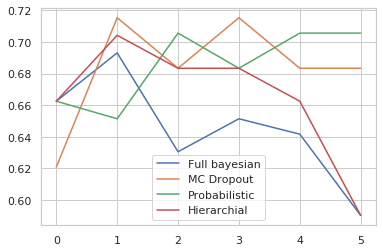

In [29]:
valk = p_value_df_a[['v_auc']].values[:-2].reshape(4,-1)
valk = valk.T
# print(valk[:, 0])
# plt.Axes.set_xlabel='0-base, 1-seg, 2-seg_iou, 3-seg_dot_iou, 4-seg_reg_iou'
plt.plot(valk[:, 0], label='Full bayesian')
plt.plot(valk[:, 1], label='MC Dropout')
plt.plot(valk[:, 2], label='Probabilistic')
plt.plot(valk[:, 3], label='Hierarchial')

plt.legend()
plt.show()

#0-base, 1-seg, 2-seg_iou, 3-seg_dot_iou, 4-seg_reg_iou

UKB_full_bayesian_0dot01
TEST_full_bayesian_0dot01
const           1.0000
age            73.0000
sex             1.0000
bmi_numeric    34.9778
Name: 2, dtype: float64
[0 0 1 ... 0 0 0] [0 0 0 ... 0 1 0]


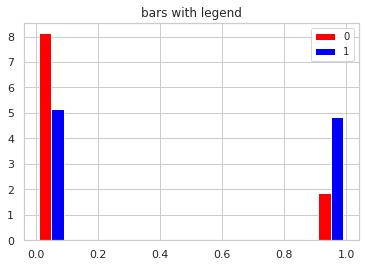

ensemble: auc_score: 0.6489249219292533


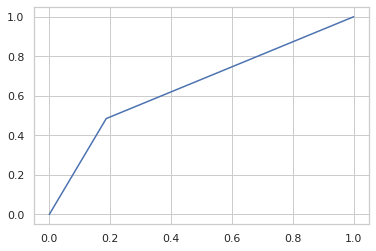

[[10789  2483]
 [  359   338]]
const                    1.000000
seg_liver_normalised     0.102883
age                     73.000000
sex                      1.000000
bmi_numeric             34.977800
Name: 2, dtype: float64
[0 0 1 ... 0 0 0] [0 0 0 ... 0 1 0]


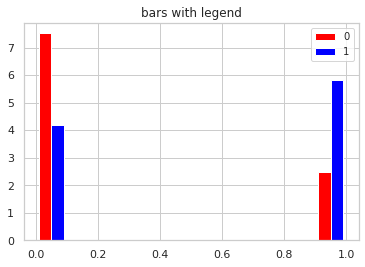

ensemble: auc_score: 0.6664726789141097


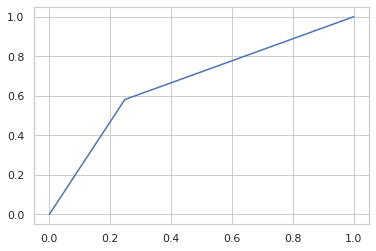

[[9979 3293]
 [ 292  405]]
const                    1.000000
seg_liver_normalised     0.102883
iou_liver                0.543722
age                     73.000000
sex                      1.000000
bmi_numeric             34.977800
Name: 2, dtype: float64
[0 0 1 ... 0 0 0] [0 0 0 ... 0 1 0]


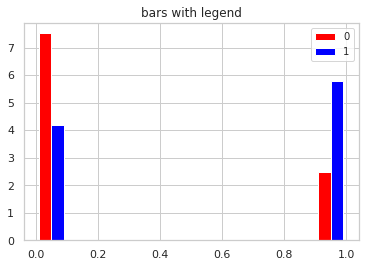

ensemble: auc_score: 0.6658306653936659


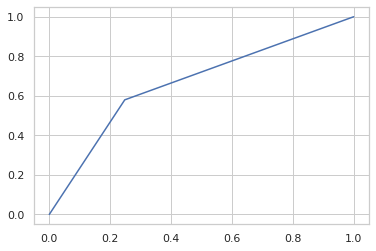

[[9981 3291]
 [ 293  404]]
const                            1.000000
seg_liver_normalised             0.102883
iou_dot_seg_liver_normalised     0.069259
age                             73.000000
sex                              1.000000
bmi_numeric                     34.977800
Name: 2, dtype: float64
[0 0 1 ... 0 0 0] [0 0 0 ... 0 1 0]


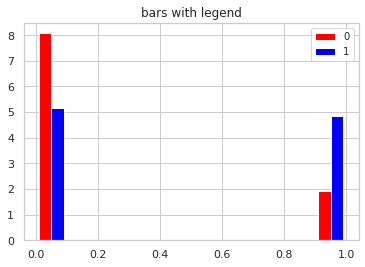

ensemble: auc_score: 0.6463254644247325


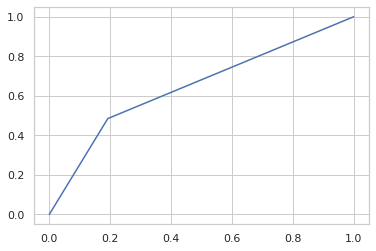

[[10720  2552]
 [  359   338]]
const               1.0000
seg_liver      232440.0000
age                73.0000
sex                 1.0000
bmi_numeric        34.9778
Name: 2, dtype: float64
[0 0 1 ... 0 0 0] [0 0 0 ... 0 1 0]


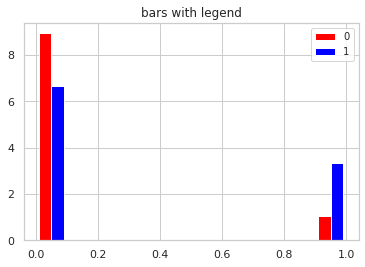

ensemble: auc_score: 0.6132705243258155


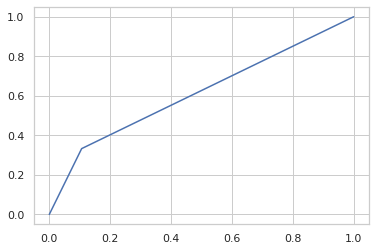

[[11861  1411]
 [  465   232]]
const               1.0000
0_liver        238752.0000
age                73.0000
sex                 1.0000
bmi_numeric        34.9778
Name: 2, dtype: float64
[0 0 1 ... 0 0 0] [0 0 0 ... 0 1 0]


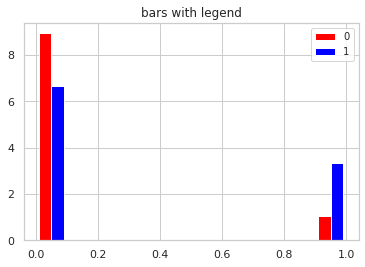

ensemble: auc_score: 0.6131951777314816


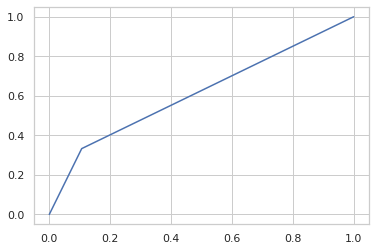

[[11859  1413]
 [  465   232]]
const               1.0000
1_liver        256956.0000
age                73.0000
sex                 1.0000
bmi_numeric        34.9778
Name: 2, dtype: float64
[0 0 1 ... 0 0 0] [0 0 0 ... 0 1 0]


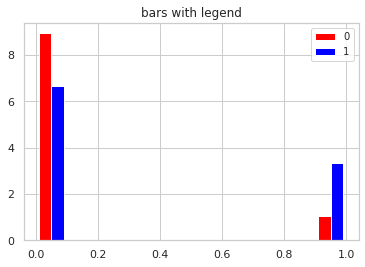

ensemble: auc_score: 0.6132705243258155


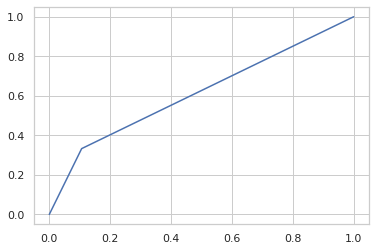

[[11861  1411]
 [  465   232]]
const               1.0000
2_liver        234096.0000
age                73.0000
sex                 1.0000
bmi_numeric        34.9778
Name: 2, dtype: float64
[0 0 1 ... 0 0 0] [0 0 0 ... 0 1 0]


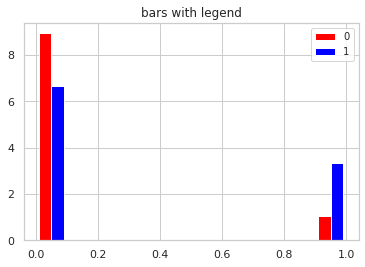

ensemble: auc_score: 0.6139125378462592


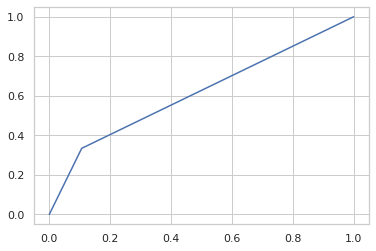

[[11859  1413]
 [  464   233]]
const               1.0000
3_liver        241728.0000
age                73.0000
sex                 1.0000
bmi_numeric        34.9778
Name: 2, dtype: float64
[0 0 1 ... 0 0 0] [0 0 0 ... 0 1 0]


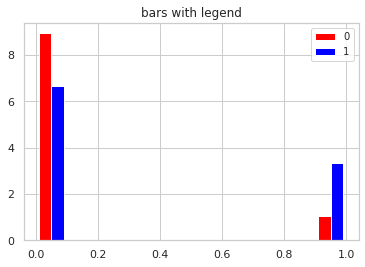

ensemble: auc_score: 0.6131575044343146


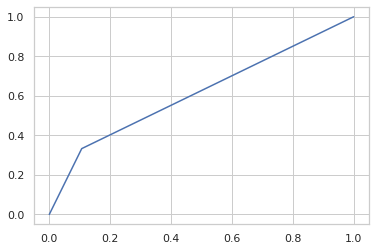

[[11858  1414]
 [  465   232]]
const               1.0000
4_liver        245220.0000
age                73.0000
sex                 1.0000
bmi_numeric        34.9778
Name: 2, dtype: float64
[0 0 1 ... 0 0 0] [0 0 0 ... 0 1 0]


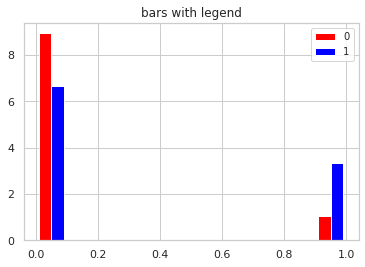

ensemble: auc_score: 0.6131575044343146


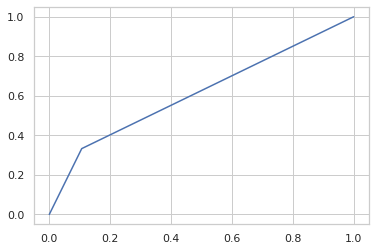

[[11858  1414]
 [  465   232]]
const               1.0000
5_liver        267144.0000
age                73.0000
sex                 1.0000
bmi_numeric        34.9778
Name: 2, dtype: float64
[0 0 1 ... 0 0 0] [0 0 0 ... 0 1 0]


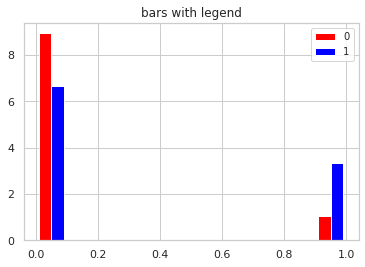

ensemble: auc_score: 0.6132328510286487


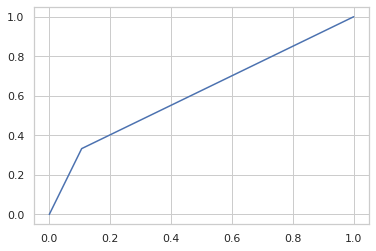

[[11860  1412]
 [  465   232]]
const               1.0000
6_liver        241644.0000
age                73.0000
sex                 1.0000
bmi_numeric        34.9778
Name: 2, dtype: float64
[0 0 1 ... 0 0 0] [0 0 0 ... 0 1 0]


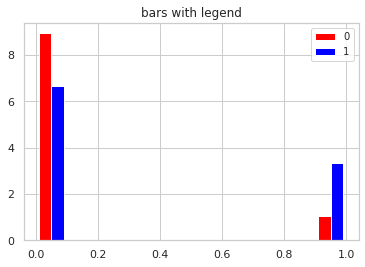

ensemble: auc_score: 0.6138748645490922


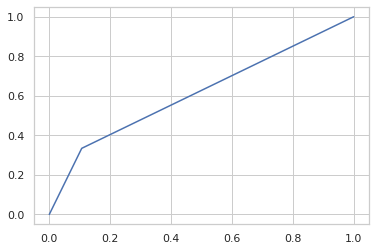

[[11858  1414]
 [  464   233]]
const               1.0000
7_liver        250044.0000
age                73.0000
sex                 1.0000
bmi_numeric        34.9778
Name: 2, dtype: float64
[0 0 1 ... 0 0 0] [0 0 0 ... 0 1 0]


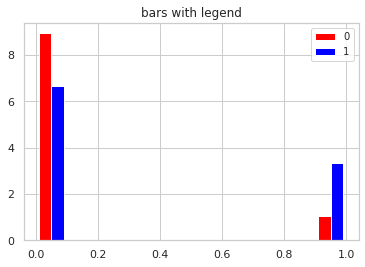

ensemble: auc_score: 0.6139125378462592


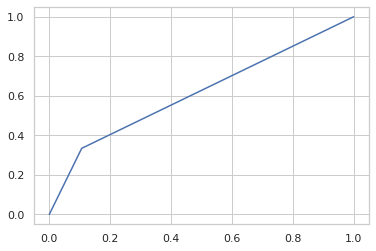

[[11859  1413]
 [  464   233]]
const               1.0000
8_liver        251736.0000
age                73.0000
sex                 1.0000
bmi_numeric        34.9778
Name: 2, dtype: float64
[0 0 1 ... 0 0 0] [0 0 0 ... 0 1 0]


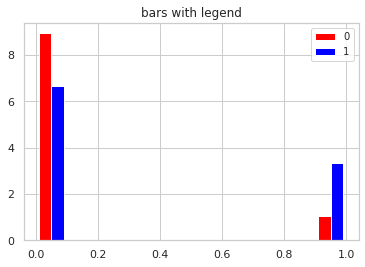

ensemble: auc_score: 0.6139502111434262


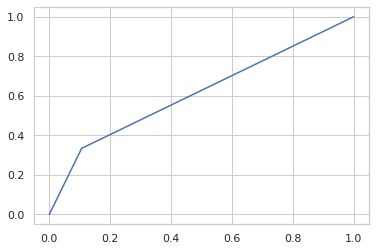

[[11860  1412]
 [  464   233]]
const               1.0000
9_liver        257112.0000
age                73.0000
sex                 1.0000
bmi_numeric        34.9778
Name: 2, dtype: float64
[0 0 1 ... 0 0 0] [0 0 0 ... 0 1 0]


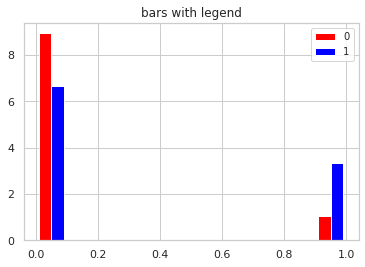

ensemble: auc_score: 0.6131198311371476


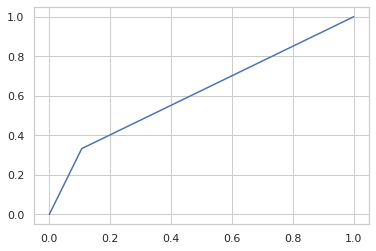

[[11857  1415]
 [  465   232]]
UKB_MC_dropout_quicknat
TEST_MC_dropout_quicknat
const           1.0000
age            64.0000
sex             0.0000
bmi_numeric    23.3275
Name: 5, dtype: float64
[0 0 0 ... 0 0 0] [0. 0. 0. ... 0. 0. 0.]


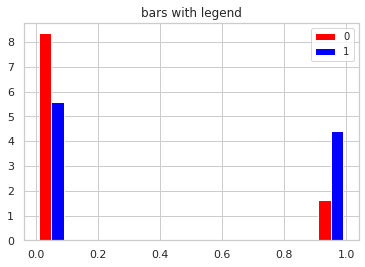

ensemble: auc_score: 0.6386684343388482


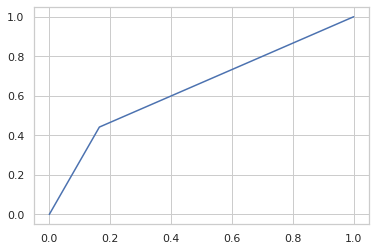

[[11088  2184]
 [  389   308]]
const                    1.00000
seg_liver_normalised     0.26783
age                     64.00000
sex                      0.00000
bmi_numeric             23.32750
Name: 5, dtype: float64
[0 0 0 ... 0 0 0] [0. 0. 0. ... 0. 0. 0.]


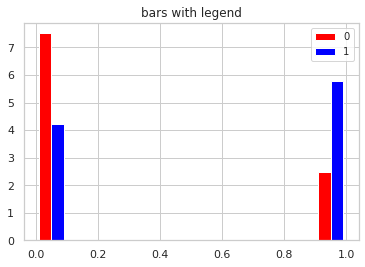

ensemble: auc_score: 0.6649626120902205


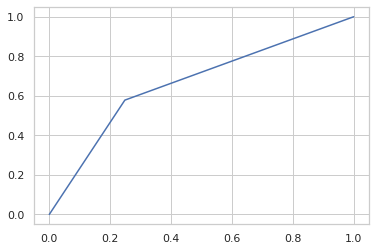

[[9977 3295]
 [ 294  403]]
const                    1.00000
seg_liver_normalised     0.26783
iou_liver                0.73854
age                     64.00000
sex                      0.00000
bmi_numeric             23.32750
Name: 5, dtype: float64
[0 0 0 ... 0 0 0] [0. 0. 0. ... 0. 0. 0.]


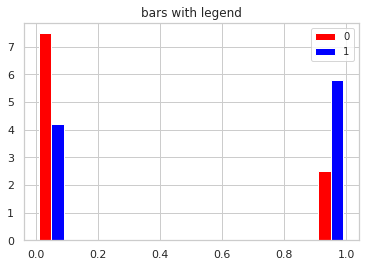

ensemble: auc_score: 0.6641730403183194


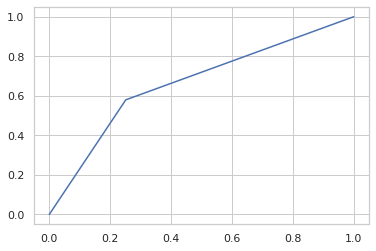

[[9937 3335]
 [ 293  404]]
const                            1.000000
seg_liver_normalised             0.267830
iou_dot_seg_liver_normalised     0.267643
age                             64.000000
sex                              0.000000
bmi_numeric                     23.327500
Name: 5, dtype: float64
[0 0 0 ... 0 0 0] [0. 0. 0. ... 0. 0. 0.]


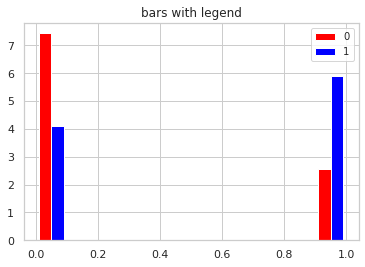

ensemble: auc_score: 0.6666327769144089


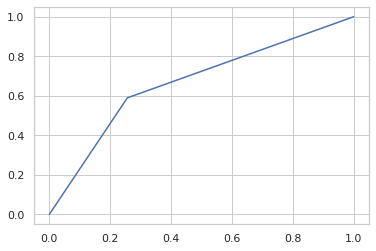

[[9869 3403]
 [ 286  411]]
const               1.0000
seg_liver      708264.0000
age                64.0000
sex                 0.0000
bmi_numeric        23.3275
Name: 5, dtype: float64
[0 0 0 ... 0 0 0] [0. 0. 0. ... 0. 0. 0.]


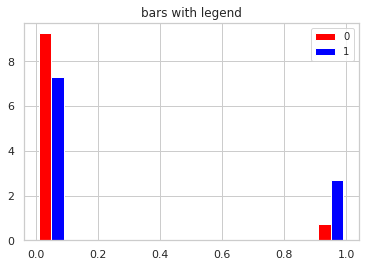

ensemble: auc_score: 0.5985105372806734


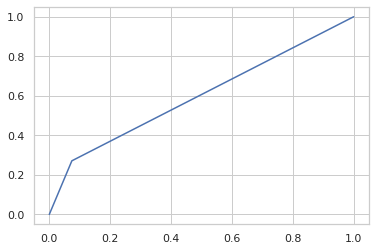

[[12288   984]
 [  508   189]]
const               1.0000
0_liver        692268.0000
age                64.0000
sex                 0.0000
bmi_numeric        23.3275
Name: 5, dtype: float64
[0 0 0 ... 0 0 0] [0. 0. 0. ... 0. 0. 0.]


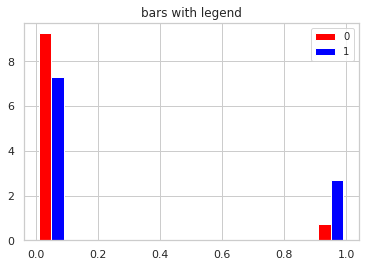

ensemble: auc_score: 0.5983975173891725


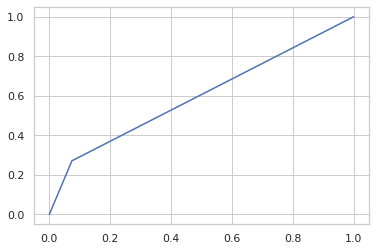

[[12285   987]
 [  508   189]]
const               1.0000
1_liver        722472.0000
age                64.0000
sex                 0.0000
bmi_numeric        23.3275
Name: 5, dtype: float64
[0 0 0 ... 0 0 0] [0. 0. 0. ... 0. 0. 0.]


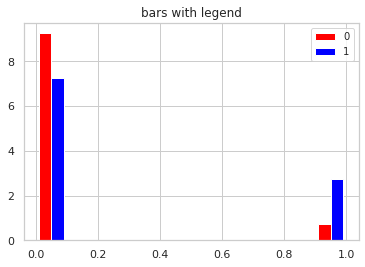

ensemble: auc_score: 0.5991902240982839


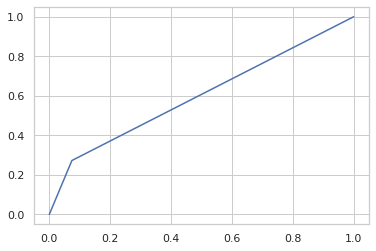

[[12287   985]
 [  507   190]]
const               1.0000
2_liver        714108.0000
age                64.0000
sex                 0.0000
bmi_numeric        23.3275
Name: 5, dtype: float64
[0 0 0 ... 0 0 0] [0. 0. 0. ... 0. 0. 0.]


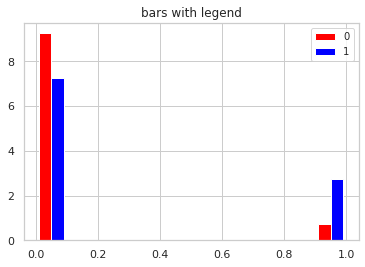

ensemble: auc_score: 0.5990018576124491


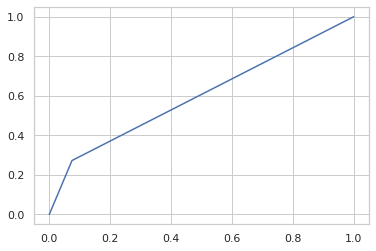

[[12282   990]
 [  507   190]]
const               1.0000
3_liver        709968.0000
age                64.0000
sex                 0.0000
bmi_numeric        23.3275
Name: 5, dtype: float64
[0 0 0 ... 0 0 0] [0. 0. 0. ... 0. 0. 0.]


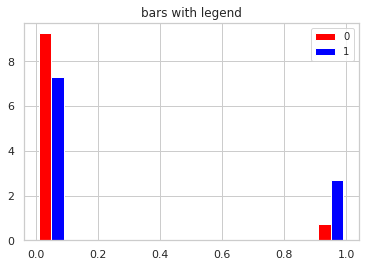

ensemble: auc_score: 0.5982844974976715


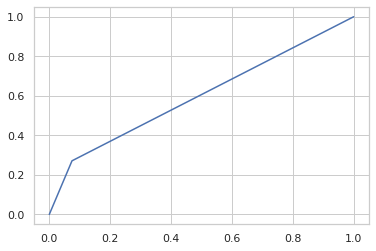

[[12282   990]
 [  508   189]]
const               1.0000
4_liver        721824.0000
age                64.0000
sex                 0.0000
bmi_numeric        23.3275
Name: 5, dtype: float64
[0 0 0 ... 0 0 0] [0. 0. 0. ... 0. 0. 0.]


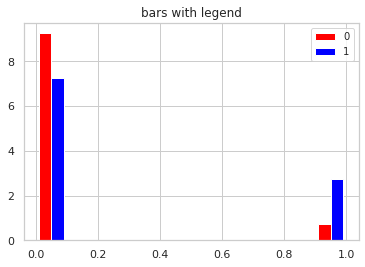

ensemble: auc_score: 0.599152550801117


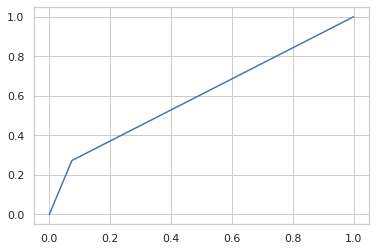

[[12286   986]
 [  507   190]]
const               1.0000
5_liver        715668.0000
age                64.0000
sex                 0.0000
bmi_numeric        23.3275
Name: 5, dtype: float64
[0 0 0 ... 0 0 0] [0. 0. 0. ... 0. 0. 0.]


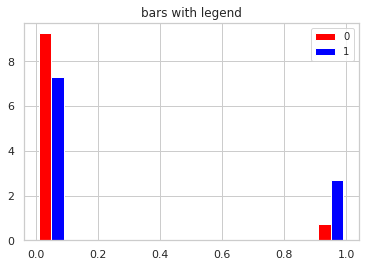

ensemble: auc_score: 0.5977555038687287


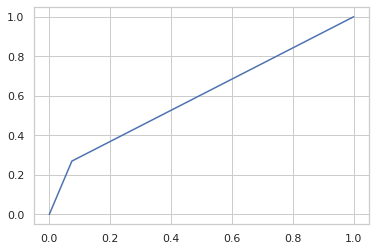

[[12287   985]
 [  509   188]]
const               1.0000
6_liver        704928.0000
age                64.0000
sex                 0.0000
bmi_numeric        23.3275
Name: 5, dtype: float64
[0 0 0 ... 0 0 0] [0. 0. 0. ... 0. 0. 0.]


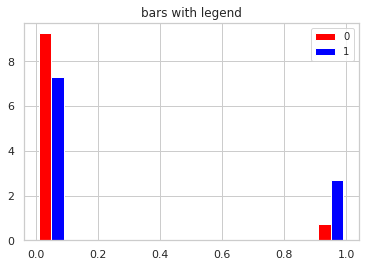

ensemble: auc_score: 0.5985105372806734


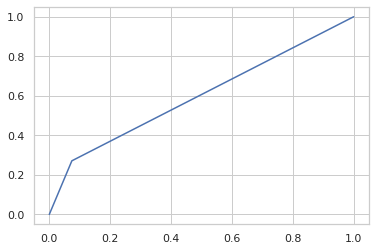

[[12288   984]
 [  508   189]]
const               1.0000
7_liver        712440.0000
age                64.0000
sex                 0.0000
bmi_numeric        23.3275
Name: 5, dtype: float64
[0 0 0 ... 0 0 0] [0. 0. 0. ... 0. 0. 0.]


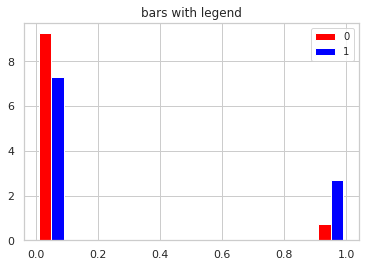

ensemble: auc_score: 0.5984728639835063


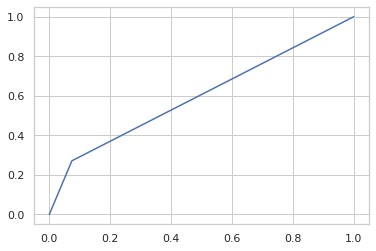

[[12287   985]
 [  508   189]]
const               1.0000
8_liver        714000.0000
age                64.0000
sex                 0.0000
bmi_numeric        23.3275
Name: 5, dtype: float64
[0 0 0 ... 0 0 0] [0. 0. 0. ... 0. 0. 0.]


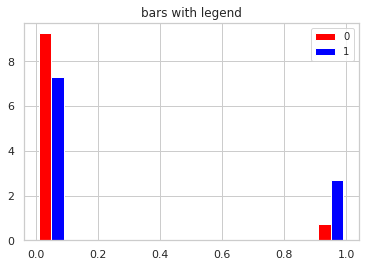

ensemble: auc_score: 0.5984728639835063


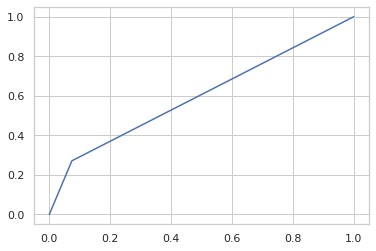

[[12287   985]
 [  508   189]]
const               1.0000
9_liver        721248.0000
age                64.0000
sex                 0.0000
bmi_numeric        23.3275
Name: 5, dtype: float64
[0 0 0 ... 0 0 0] [0. 0. 0. ... 0. 0. 0.]


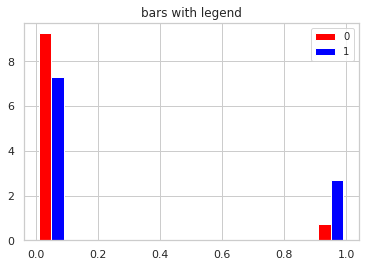

ensemble: auc_score: 0.5984351906863394


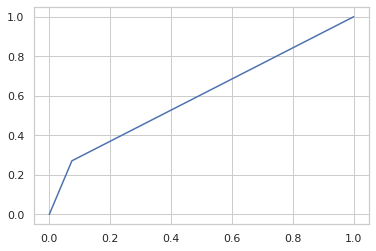

[[12286   986]
 [  508   189]]
UKB_probabilistic_quicknat
TEST_probabilistic_quicknat
const           1.0000
age            48.0000
sex             0.0000
bmi_numeric    20.3376
Name: 2, dtype: float64
[0 1 0 ... 0 0 0] [0. 0. 0. ... 0. 1. 0.]


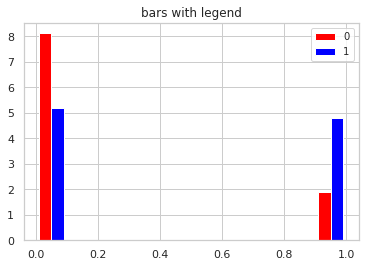

ensemble: auc_score: 0.6462077421274159


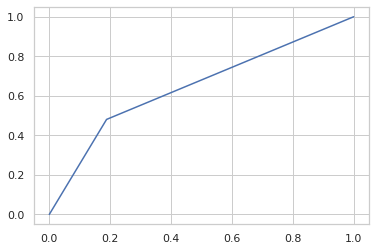

[[10774  2498]
 [  362   335]]
const                    1.000000
seg_liver_normalised     0.253821
age                     48.000000
sex                      0.000000
bmi_numeric             20.337600
Name: 2, dtype: float64
[0 1 0 ... 0 0 0] [0. 0. 0. ... 0. 1. 0.]


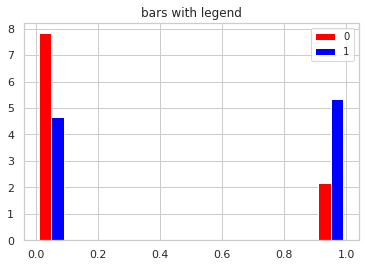

ensemble: auc_score: 0.6589632070796828


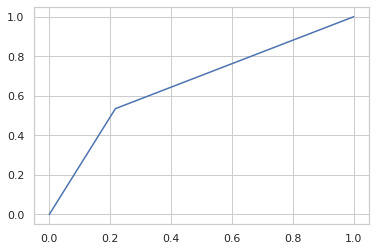

[[10389  2883]
 [  324   373]]
const                    1.000000
seg_liver_normalised     0.253821
iou_liver                0.987928
age                     48.000000
sex                      0.000000
bmi_numeric             20.337600
Name: 2, dtype: float64
[0 1 0 ... 0 0 0] [0. 0. 0. ... 0. 1. 0.]


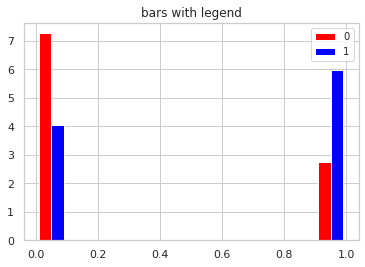

ensemble: auc_score: 0.6607620124307828


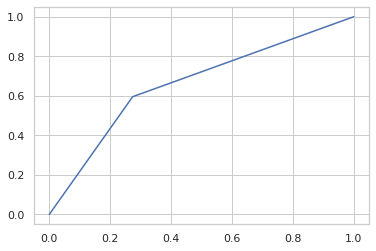

[[9637 3635]
 [ 282  415]]
const                            1.000000
seg_liver_normalised             0.253821
iou_dot_seg_liver_normalised     0.255741
age                             48.000000
sex                              0.000000
bmi_numeric                     20.337600
Name: 2, dtype: float64
[0 1 0 ... 0 0 0] [0. 0. 0. ... 0. 1. 0.]


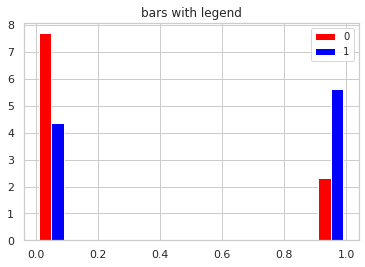

ensemble: auc_score: 0.6669059488568506


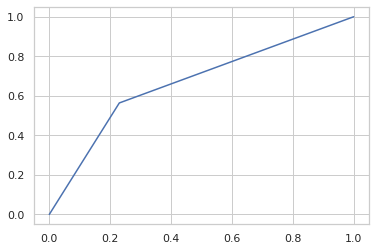

[[10219  3053]
 [  304   393]]
const               1.0000
seg_liver      662364.0000
age                48.0000
sex                 0.0000
bmi_numeric        20.3376
Name: 2, dtype: float64
[0 1 0 ... 0 0 0] [0. 0. 0. ... 0. 1. 0.]


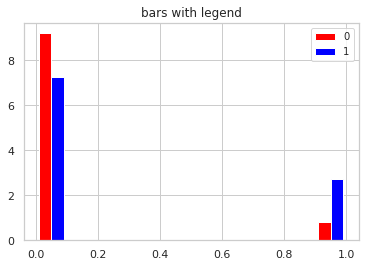

ensemble: auc_score: 0.5965154199994291


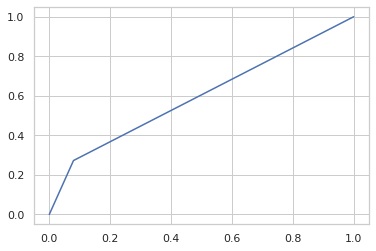

[[12216  1056]
 [  507   190]]
const               1.0000
0_liver        662136.0000
age                48.0000
sex                 0.0000
bmi_numeric        20.3376
Name: 2, dtype: float64
[0 1 0 ... 0 0 0] [0. 0. 0. ... 0. 1. 0.]


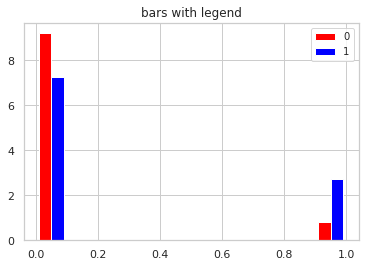

ensemble: auc_score: 0.5965154199994291


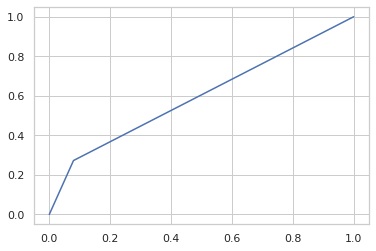

[[12216  1056]
 [  507   190]]
const               1.0000
1_liver        662580.0000
age                48.0000
sex                 0.0000
bmi_numeric        20.3376
Name: 2, dtype: float64
[0 1 0 ... 0 0 0] [0. 0. 0. ... 0. 1. 0.]


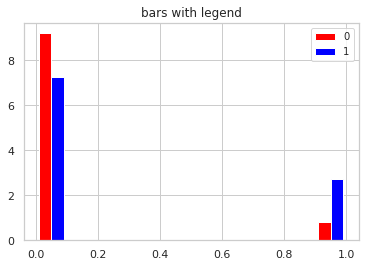

ensemble: auc_score: 0.5965154199994291


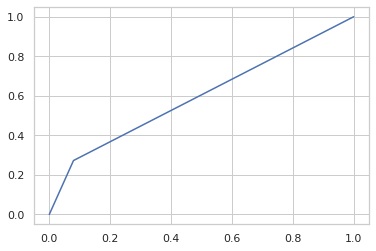

[[12216  1056]
 [  507   190]]
const               1.0000
2_liver        662556.0000
age                48.0000
sex                 0.0000
bmi_numeric        20.3376
Name: 2, dtype: float64
[0 1 0 ... 0 0 0] [0. 0. 0. ... 0. 1. 0.]


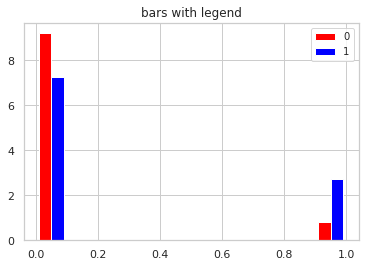

ensemble: auc_score: 0.5965154199994291


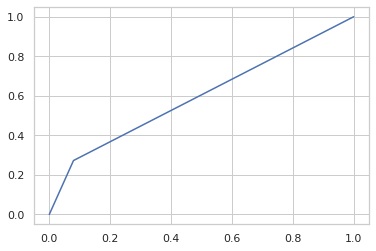

[[12216  1056]
 [  507   190]]
const               1.0000
3_liver        662460.0000
age                48.0000
sex                 0.0000
bmi_numeric        20.3376
Name: 2, dtype: float64
[0 1 0 ... 0 0 0] [0. 0. 0. ... 0. 1. 0.]


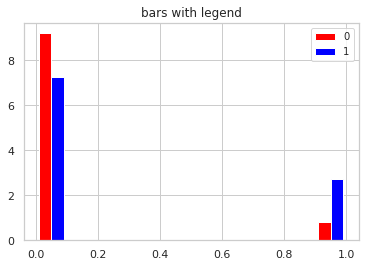

ensemble: auc_score: 0.5965154199994291


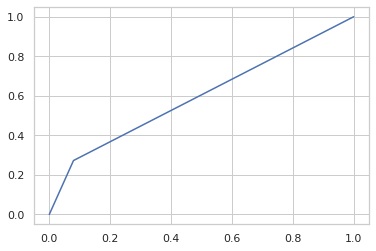

[[12216  1056]
 [  507   190]]
const               1.0000
4_liver        661872.0000
age                48.0000
sex                 0.0000
bmi_numeric        20.3376
Name: 2, dtype: float64
[0 1 0 ... 0 0 0] [0. 0. 0. ... 0. 1. 0.]


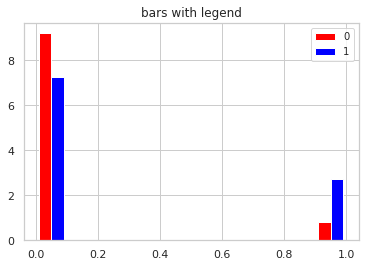

ensemble: auc_score: 0.5965154199994291


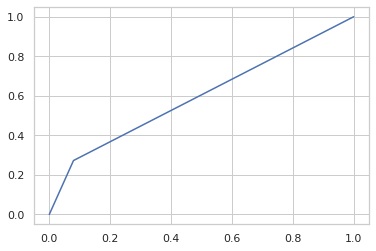

[[12216  1056]
 [  507   190]]
const               1.0000
5_liver        662304.0000
age                48.0000
sex                 0.0000
bmi_numeric        20.3376
Name: 2, dtype: float64
[0 1 0 ... 0 0 0] [0. 0. 0. ... 0. 1. 0.]


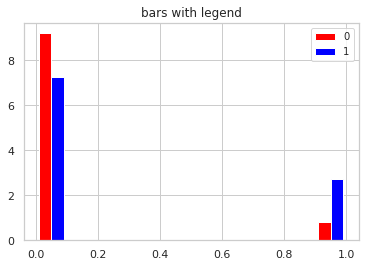

ensemble: auc_score: 0.5965154199994291


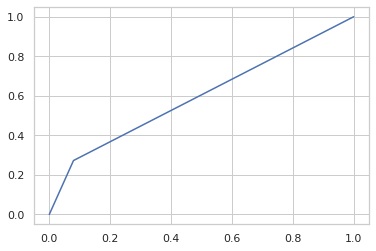

[[12216  1056]
 [  507   190]]
const               1.0000
6_liver        662748.0000
age                48.0000
sex                 0.0000
bmi_numeric        20.3376
Name: 2, dtype: float64
[0 1 0 ... 0 0 0] [0. 0. 0. ... 0. 1. 0.]


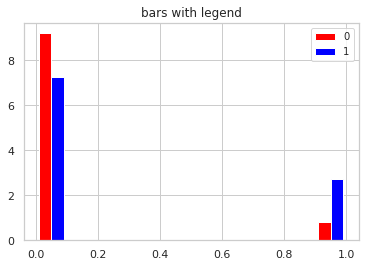

ensemble: auc_score: 0.5965154199994291


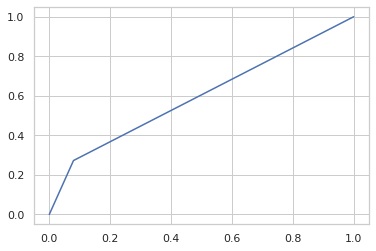

[[12216  1056]
 [  507   190]]
const               1.0000
7_liver        661668.0000
age                48.0000
sex                 0.0000
bmi_numeric        20.3376
Name: 2, dtype: float64
[0 1 0 ... 0 0 0] [0. 0. 0. ... 0. 1. 0.]


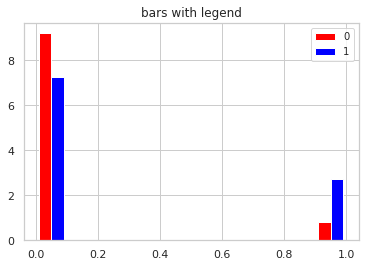

ensemble: auc_score: 0.5965154199994291


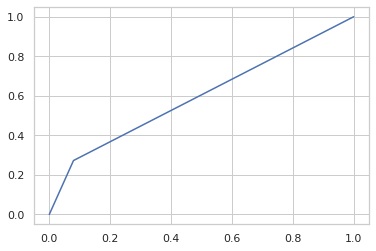

[[12216  1056]
 [  507   190]]
const               1.0000
8_liver        662148.0000
age                48.0000
sex                 0.0000
bmi_numeric        20.3376
Name: 2, dtype: float64
[0 1 0 ... 0 0 0] [0. 0. 0. ... 0. 1. 0.]


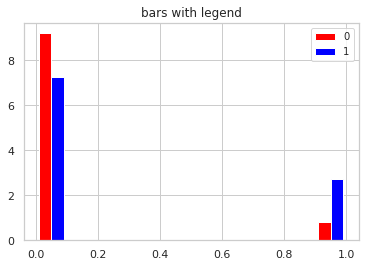

ensemble: auc_score: 0.5965154199994291


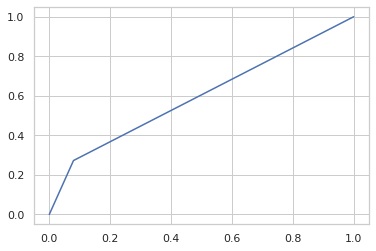

[[12216  1056]
 [  507   190]]
const               1.0000
9_liver        662268.0000
age                48.0000
sex                 0.0000
bmi_numeric        20.3376
Name: 2, dtype: float64
[0 1 0 ... 0 0 0] [0. 0. 0. ... 0. 1. 0.]


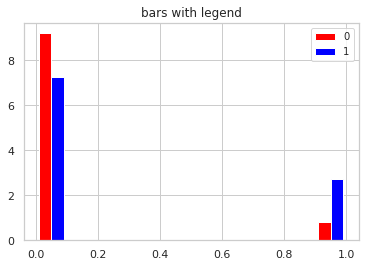

ensemble: auc_score: 0.5965154199994291


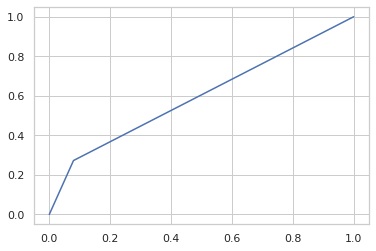

[[12216  1056]
 [  507   190]]
UKB_hierarchical_quicknat
TEST_hierarchical_quicknat
const           1.0000
age            65.0000
sex             0.0000
bmi_numeric    31.6621
Name: 4, dtype: float64
[0 0 1 ... 0 0 1] [0. 0. 0. ... 0. 0. 0.]


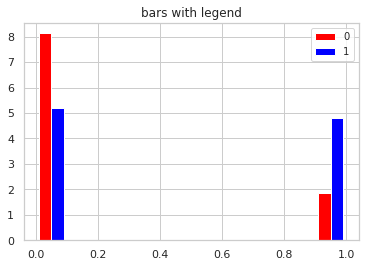

ensemble: auc_score: 0.6464322144418125


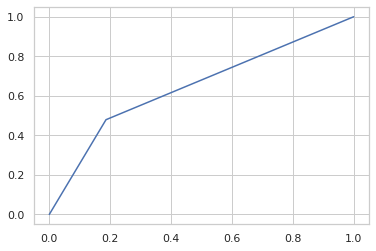

[[10799  2473]
 [  363   334]]
const                    1.000000
seg_liver_normalised     0.469378
age                     65.000000
sex                      0.000000
bmi_numeric             31.662100
Name: 4, dtype: float64
[0 0 1 ... 0 0 1] [0. 0. 0. ... 0. 0. 0.]


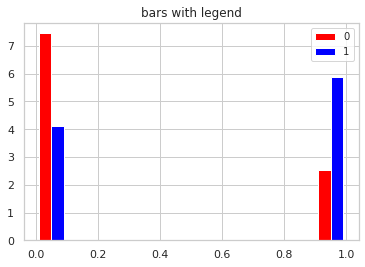

ensemble: auc_score: 0.667800649126585


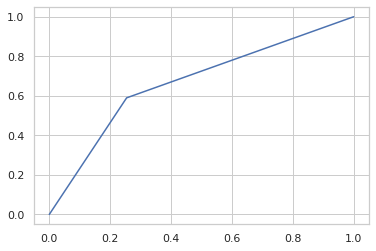

[[9900 3372]
 [ 286  411]]
const                    1.000000
seg_liver_normalised     0.469378
iou_liver                0.976811
age                     65.000000
sex                      0.000000
bmi_numeric             31.662100
Name: 4, dtype: float64
[0 0 1 ... 0 0 1] [0. 0. 0. ... 0. 0. 0.]


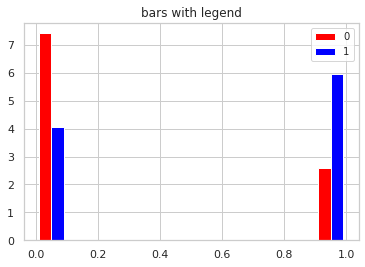

ensemble: auc_score: 0.6676923316408997


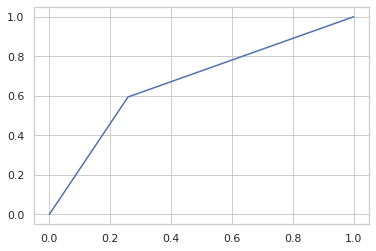

[[9840 3432]
 [ 283  414]]
const                            1.000000
seg_liver_normalised             0.469378
iou_dot_seg_liver_normalised     0.466340
age                             65.000000
sex                              0.000000
bmi_numeric                     31.662100
Name: 4, dtype: float64
[0 0 1 ... 0 0 1] [0. 0. 0. ... 0. 0. 0.]


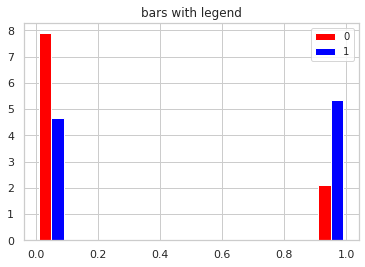

ensemble: auc_score: 0.6614857505212643


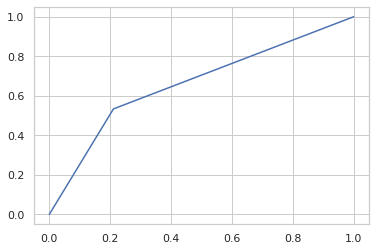

[[10475  2797]
 [  325   372]]
const          1.000000e+00
seg_liver      1.142064e+06
age            6.500000e+01
sex            0.000000e+00
bmi_numeric    3.166210e+01
Name: 4, dtype: float64
[0 0 1 ... 0 0 1] [0. 0. 0. ... 0. 0. 0.]


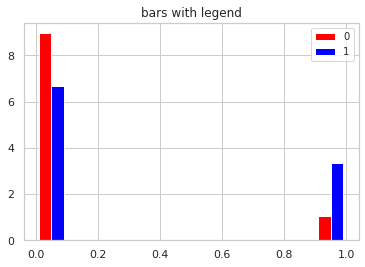

ensemble: auc_score: 0.6145890897266594


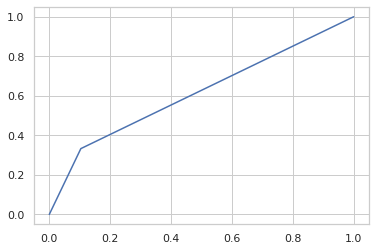

[[11896  1376]
 [  465   232]]
const          1.000000e+00
0_liver        1.141152e+06
age            6.500000e+01
sex            0.000000e+00
bmi_numeric    3.166210e+01
Name: 4, dtype: float64
[0 0 1 ... 0 0 1] [0. 0. 0. ... 0. 0. 0.]


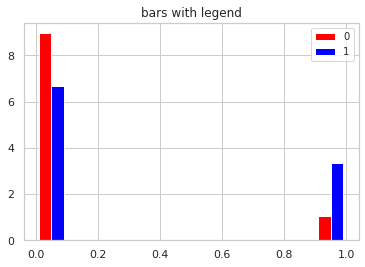

ensemble: auc_score: 0.6145890897266594


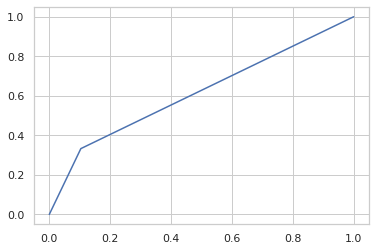

[[11896  1376]
 [  465   232]]
const          1.000000e+00
1_liver        1.144176e+06
age            6.500000e+01
sex            0.000000e+00
bmi_numeric    3.166210e+01
Name: 4, dtype: float64
[0 0 1 ... 0 0 1] [0. 0. 0. ... 0. 0. 0.]


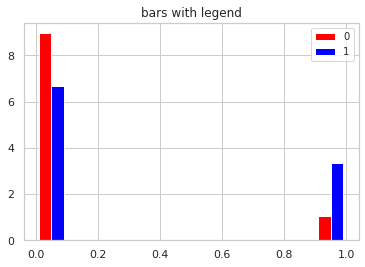

ensemble: auc_score: 0.6145890897266594


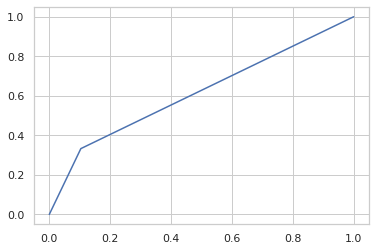

[[11896  1376]
 [  465   232]]
const          1.000000e+00
2_liver        1.141848e+06
age            6.500000e+01
sex            0.000000e+00
bmi_numeric    3.166210e+01
Name: 4, dtype: float64
[0 0 1 ... 0 0 1] [0. 0. 0. ... 0. 0. 0.]


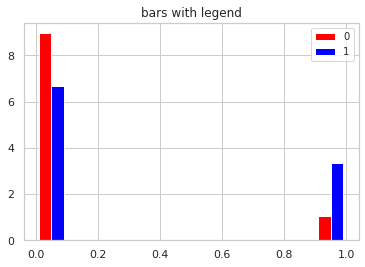

ensemble: auc_score: 0.6145890897266594


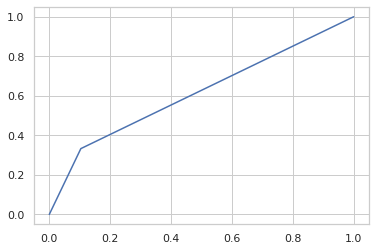

[[11896  1376]
 [  465   232]]
const          1.000000e+00
3_liver        1.142928e+06
age            6.500000e+01
sex            0.000000e+00
bmi_numeric    3.166210e+01
Name: 4, dtype: float64
[0 0 1 ... 0 0 1] [0. 0. 0. ... 0. 0. 0.]


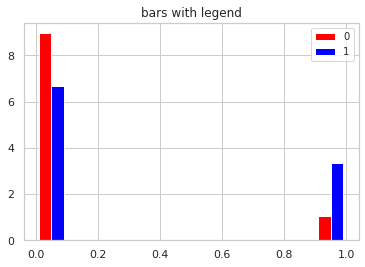

ensemble: auc_score: 0.6145890897266594


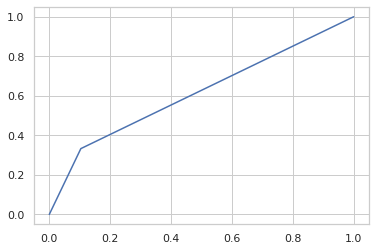

[[11896  1376]
 [  465   232]]
const          1.000000e+00
4_liver        1.142868e+06
age            6.500000e+01
sex            0.000000e+00
bmi_numeric    3.166210e+01
Name: 4, dtype: float64
[0 0 1 ... 0 0 1] [0. 0. 0. ... 0. 0. 0.]


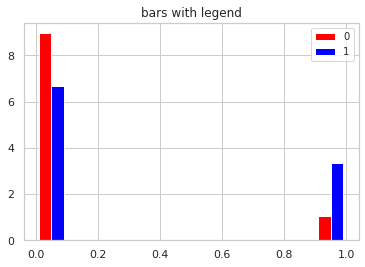

ensemble: auc_score: 0.6146267630238264


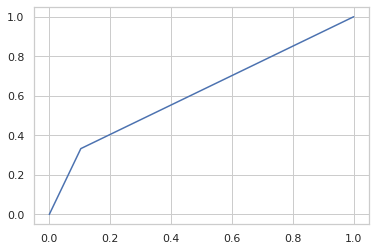

[[11897  1375]
 [  465   232]]
const          1.000000e+00
5_liver        1.141944e+06
age            6.500000e+01
sex            0.000000e+00
bmi_numeric    3.166210e+01
Name: 4, dtype: float64
[0 0 1 ... 0 0 1] [0. 0. 0. ... 0. 0. 0.]


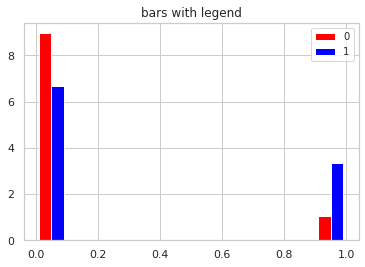

ensemble: auc_score: 0.6145890897266594


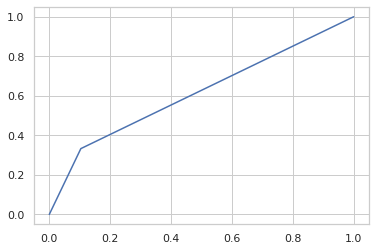

[[11896  1376]
 [  465   232]]
const          1.000000e+00
6_liver        1.143576e+06
age            6.500000e+01
sex            0.000000e+00
bmi_numeric    3.166210e+01
Name: 4, dtype: float64
[0 0 1 ... 0 0 1] [0. 0. 0. ... 0. 0. 0.]


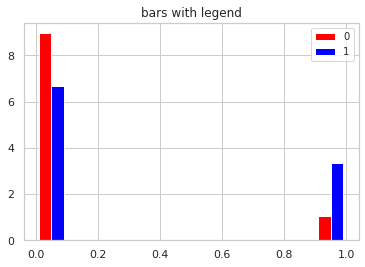

ensemble: auc_score: 0.6145890897266594


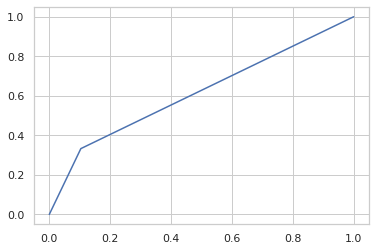

[[11896  1376]
 [  465   232]]
const          1.000000e+00
7_liver        1.142556e+06
age            6.500000e+01
sex            0.000000e+00
bmi_numeric    3.166210e+01
Name: 4, dtype: float64
[0 0 1 ... 0 0 1] [0. 0. 0. ... 0. 0. 0.]


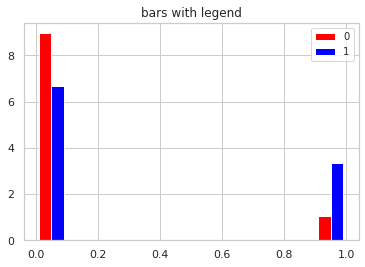

ensemble: auc_score: 0.6145890897266594


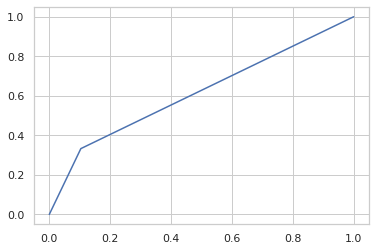

[[11896  1376]
 [  465   232]]
const          1.000000e+00
8_liver        1.141416e+06
age            6.500000e+01
sex            0.000000e+00
bmi_numeric    3.166210e+01
Name: 4, dtype: float64
[0 0 1 ... 0 0 1] [0. 0. 0. ... 0. 0. 0.]


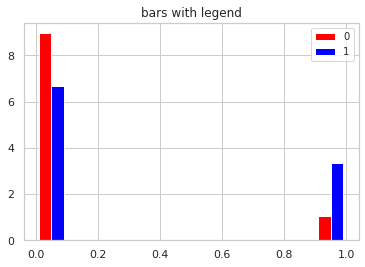

ensemble: auc_score: 0.6145890897266594


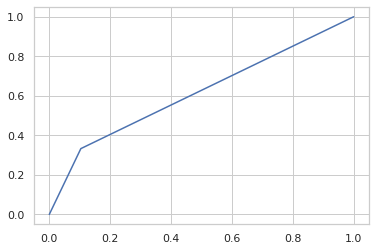

[[11896  1376]
 [  465   232]]
const          1.000000e+00
9_liver        1.144368e+06
age            6.500000e+01
sex            0.000000e+00
bmi_numeric    3.166210e+01
Name: 4, dtype: float64
[0 0 1 ... 0 0 1] [0. 0. 0. ... 0. 0. 0.]


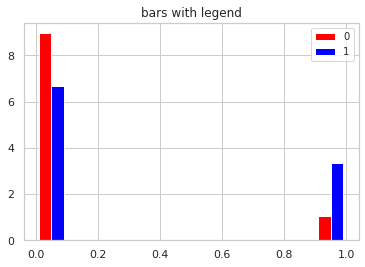

ensemble: auc_score: 0.6145890897266594


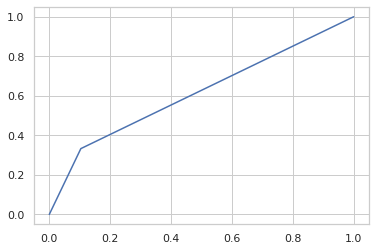

[[11896  1376]
 [  465   232]]
dataset_UKB_processed
dataset_KORA_processed
const           1.0000
age            65.0000
sex             1.0000
bmi_numeric    27.2146
Name: 2, dtype: float64
[1 0 0 0 0 0 1] [0. 0. 0. 0. 1. 0. 0.]


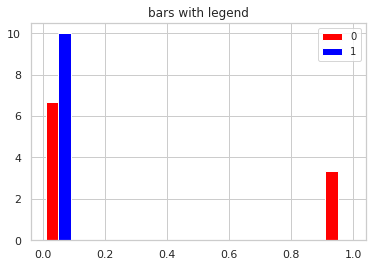

ensemble: auc_score: 0.33333333333333337


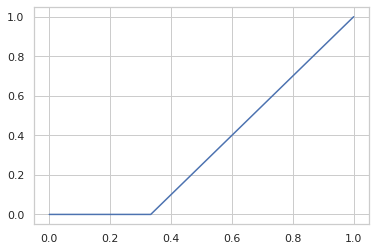

[[4 2]
 [1 0]]
const                    1.000000
seg_liver_normalised     0.389354
age                     65.000000
sex                      1.000000
bmi_numeric             27.214600
Name: 2, dtype: float64
[1 0 0 0 0 0 1] [0. 0. 0. 0. 1. 0. 0.]


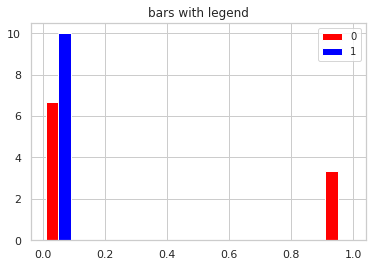

ensemble: auc_score: 0.33333333333333337


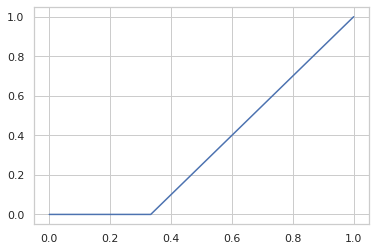

[[4 2]
 [1 0]]


In [30]:
# feats = []#basic_feats
dicts = {}
anova_test_dicts = {}
# basic_feats = normalised_basic_feats
for model, df in dfs_ukb.items():
#     
#     df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver'])
    df = df.fillna(0)
    print(model)
    if 'UKB' not in model:
#         print('dataset cannot be processed!')
        continue

        
    dicts[model] = {}
    k_mod = 'TEST' + model[3:]
    if 'dataset' in model:
        k_mod = 'dataset_KORA_processed'
    print(k_mod)
    target_col = 'diabetes_status'

#     Equation 1 process
#     p_values, statsmodel, y_yp = discrete_group_feature_stats(basic_feats, df, target_col, ['sex'], True)
#     auc_score, f1_score = auc_roc(y_yp, f'{model}_csv_feats')
    dicts[model][target_col] = {} # p_values
#     dicts[model][target_col]['auc'] = auc_score
#     dicts[model][target_col]['f1'] = f1_score
    dicts, _ = aggregate_model_outputs(df, target_col, basic_feats, dicts, model, target_col, global_kora_models[k_mod]['normal'])
    
#     Equation 2 process
    for organ in ['liver']:
        feats =  [ f'seg_{organ}_normalised'] + basic_feats
#         p_values, statsmodel, y_yp = discrete_group_feature_stats(feats, df, target_col, ['sex'], True)
#         auc_score, f1_score = auc_roc(y_yp, f'{model}_{organ}_seg')
        dicts[model][target_col+f'_{organ}_with_seg_volumes'] = {} # p_values
#         dicts[model][target_col+f'_{organ}_with_seg_volumes']['auc'] = auc_score
#         dicts[model][target_col+f'_{organ}_with_seg_volumes']['f1'] = f1_score
        dicts, _ = aggregate_model_outputs(df, target_col, feats, dicts, model, target_col+f'_{organ}_with_seg_volumes', global_kora_models[k_mod][f'{organ}_seg'])

        if 'dataset' in model:
            continue
            
        #     Equation 3 process
        feats = [ f'seg_{organ}_normalised', f'iou_{organ}'] + basic_feats
#         p_values, statsmodel, y_yp = discrete_group_feature_stats(feats, df, target_col, ['sex'], True)
#         auc_score, f1_score = auc_roc(y_yp, f'{model}_{organ}_with_seg_iou')
        dicts[model][target_col+f'_with_{organ}_seg_and_iou'] = {} # p_values
#         dicts[model][target_col+f'_with_{organ}_seg_and_iou']['auc'] = auc_score
#         dicts[model][target_col+f'_with_{organ}_seg_and_iou']['f1'] = f1_score
        dicts, _ = aggregate_model_outputs(df, target_col, feats, dicts, model,target_col+f'_with_{organ}_seg_and_iou', global_kora_models[k_mod][f'{organ}_seg_iou'])
    #     global_kora_models[model][f'{organ}_seg_iou'] = statsmodel
    
    #     Equation 3.1 process
        feats = [f'seg_{organ}_normalised', f'iou_dot_seg_{organ}_normalised'] +basic_feats
#         p_values, statsmodel, y_yp = discrete_group_feature_stats(feats, df, target_col, ['sex'], True)
#         auc_score, f1_score = auc_roc(y_yp, f'{model}_{organ}_with_seg_dot_iou')
        dicts[model][target_col+f'_with_{organ}_seg_dot_iou'] = {} # p_values
#         dicts[model][target_col+f'_with_{organ}_seg_dot_iou']['auc'] = auc_score
#         dicts[model][target_col+f'_with_{organ}_seg_dot_iou']['f1'] = f1_score
        dicts, _ = aggregate_model_outputs(df, target_col, feats, dicts, model, target_col+f'_with_{organ}_seg_dot_iou', global_kora_models[k_mod][f'{organ}_seg_dot_iou'])
    #     global_kora_models[model][f'{organ}_seg_dot_iou'] = statsmodel


        #     Equation 4.0 process
        feats = [ f'seg_{organ}']+ basic_feats
#         p_values, statsmodel, y_yp = discrete_weighted_group_feats(df, target_col, feats, f'iou_{organ}')
#         auc_score, f1_score = auc_roc(y_yp, f'{model}_{organ}_csv_feats')
        dicts[model][target_col+f'_{organ}_seg_reg_iou'] = {} # p_values
#         dicts[model][target_col+f'_{organ}_seg_reg_iou']['auc'] = auc_score
#         dicts[model][target_col+f'_{organ}_seg_reg_iou']['f1'] = f1_score
        dicts, _ = aggregate_model_outputs(df, target_col, feats, dicts, model, target_col+f'_{organ}_seg_reg_iou', global_kora_models[k_mod][f'{organ}_seg_reg_iou'], f'iou_{organ}')

        aucs = []
        for i in range(10):

            feats =  [ f'{i}_{organ}'] + basic_feats
        #         p_values, statsmodel, y_yp = discrete_weighted_group_feats(df, target_col, feats, f'iou_mean')
        #         auc_score, f1_score = auc_roc(y_yp, f'{model}_{organ}_csv_feats')
            dicts[model][target_col+f'_{organ}_seg_reg_iou_sampled'] = {} #p_values
        #         dicts[model][target_col+f'_{organ}_seg_reg_iou']['auc'] = auc_score
        #         dicts[model][target_col+f'_{organ}_seg_reg_iou']['f1'] = f1_score
            dicts, _ = aggregate_model_outputs(df, target_col, feats, dicts, model, target_col+f'_{organ}_seg_reg_iou_sampled', global_kora_models[k_mod][f'{organ}_seg_reg_iou'], f'iou_{organ}')
            aucs = aucs+ [dicts[model][target_col+f'_{organ}_seg_reg_iou_sampled']['v_auc']]
        dicts[model][target_col+f'_{organ}_seg_reg_iou_sampled']['v_auc'] = np.mean(aucs)
    
        
p_value_df = df_from_nested_dicts(dicts).T
# p_value_df_styler = highlight_significance(p_value_df, 0.05)
# p_value_df_styler

In [31]:
p_value_df[['v_auc']]

,,,v_auc
UKB_full_bayesian_0dot01_diabetes_status,diabetes_status,0,0.648925
UKB_full_bayesian_0dot01_diabetes_status_liver_with_seg_volumes,diabetes_status_liver_with_seg_volumes,0,0.666473
UKB_full_bayesian_0dot01_diabetes_status_with_liver_seg_and_iou,diabetes_status_with_liver_seg_and_iou,0,0.665831
UKB_full_bayesian_0dot01_diabetes_status_with_liver_seg_dot_iou,diabetes_status_with_liver_seg_dot_iou,0,0.646325
UKB_full_bayesian_0dot01_diabetes_status_liver_seg_reg_iou,diabetes_status_liver_seg_reg_iou,0,0.613271
UKB_full_bayesian_0dot01_diabetes_status_liver_seg_reg_iou_sampled,diabetes_status_liver_seg_reg_iou_sampled,0,0.613478
UKB_MC_dropout_quicknat_diabetes_status,diabetes_status,0,0.638668
UKB_MC_dropout_quicknat_diabetes_status_liver_with_seg_volumes,diabetes_status_liver_with_seg_volumes,0,0.664963
UKB_MC_dropout_quicknat_diabetes_status_with_liver_seg_and_iou,diabetes_status_with_liver_seg_and_iou,0,0.664173
UKB_MC_dropout_quicknat_diabetes_status_with_liver_seg_dot_iou,diabetes_status_with_liver_seg_dot_iou,0,0.666633


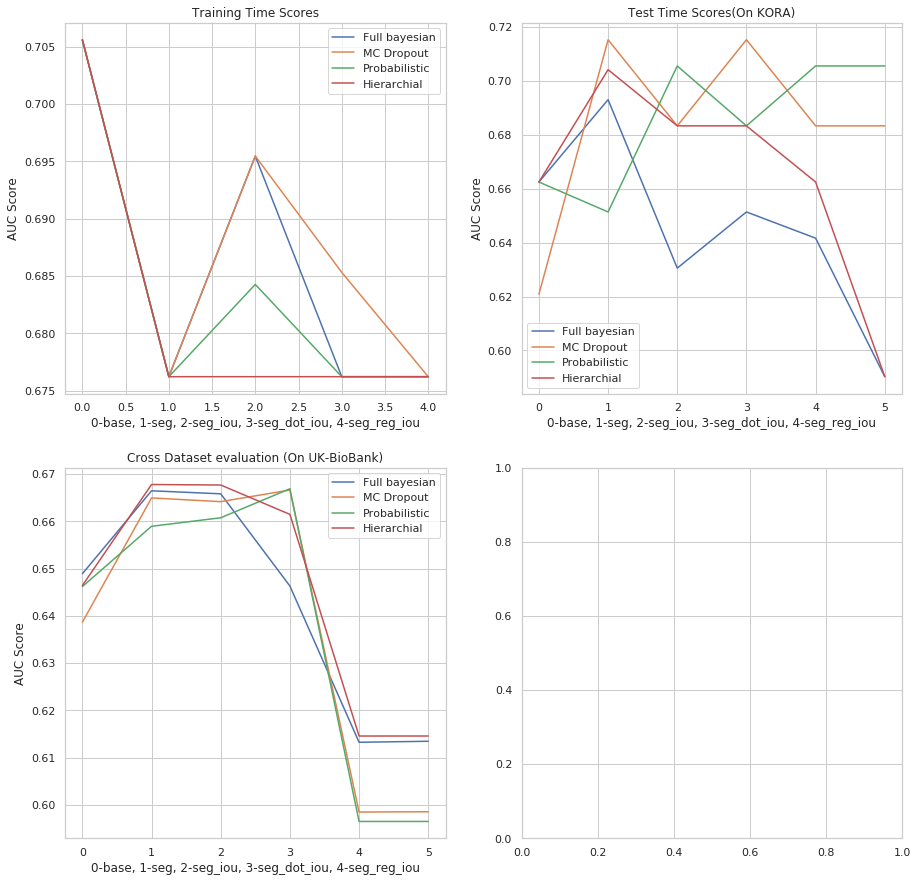

In [32]:
fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15))


vals = p_value_df_ka[['auc']].values[:-2].reshape(4,-1)
vals = vals.T

ax1.plot(vals[:, 0], label='Full bayesian')
ax1.plot(vals[:, 1], label='MC Dropout')
ax1.plot(vals[:, 2], label='Probabilistic')
ax1.plot(vals[:, 3], label='Hierarchial')

ax1.set_xlabel('0-base, 1-seg, 2-seg_iou, 3-seg_dot_iou, 4-seg_reg_iou')
ax1.set_ylabel('AUC Score')
ax1.set_title(r'Training Time Scores')
ax1.legend()
# plt.show()

#0-base, 1-seg, 2-seg_iou, 3-seg_dot_iou, 4-seg_reg_iou


valk = p_value_df_a[['v_auc']].values[:-2].reshape(4,-1)
valk = valk.T
# print(valk[:, 0])
# plt.Axes.set_xlabel='0-base, 1-seg, 2-seg_iou, 3-seg_dot_iou, 4-seg_reg_iou'
ax2.plot(valk[:, 0], label='Full bayesian')
ax2.plot(valk[:, 1], label='MC Dropout')
ax2.plot(valk[:, 2], label='Probabilistic')
ax2.plot(valk[:, 3], label='Hierarchial')

ax2.set_xlabel('0-base, 1-seg, 2-seg_iou, 3-seg_dot_iou, 4-seg_reg_iou')
ax2.set_ylabel('AUC Score')
ax2.set_title(r'Test Time Scores(On KORA)')

ax2.legend()
# plt.show()

#0-base, 1-seg, 2-seg_iou, 3-seg_dot_iou, 4-seg_reg_iou

vali = p_value_df[['v_auc']].values[:-2].reshape(4,-1)
vali = vali.T

ax3.plot(vali[:, 0], label='Full bayesian')
ax3.plot(vali[:, 1], label='MC Dropout')
ax3.plot(vali[:, 2], label='Probabilistic')
ax3.plot(vali[:, 3], label='Hierarchial')

ax3.set_xlabel('0-base, 1-seg, 2-seg_iou, 3-seg_dot_iou, 4-seg_reg_iou')
ax3.set_ylabel('AUC Score')
ax3.set_title(r'Cross Dataset evaluation (On UK-BioBank)')
ax3.legend()

# plt.show()

# #0-base, 1-seg, 2-seg_iou, 3-seg_dot_iou, 4-seg_reg_iou

# vali = p_value_df[['v_auc']].values[:-2].reshape(4,-1)
# vali = vali.T

# ax4.plot(vali[:, 0], label='Full bayesian')
# ax4.plot(vali[:, 1], label='MC Dropout')
# ax4.plot(vali[:, 2], label='Probabilistic')
# ax4.plot(vali[:, 3], label='Hierarchial')

# ax4.legend()
plt.savefig('./phase_2/expt_plot.png')
plt.show()

#0-base, 1-seg, 2-seg_iou, 3-seg_dot_iou, 4-seg_reg_iou



# Regression

In [21]:
# feats = basic_feats
# dicts = {}
# anova_test_dicts = {}
# for model, df in dfs.items():
# #     
# #     df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver'])
# #     df = df.fillna(0)

        
#     dicts[model] = {}
#     target_cols = ['seg_spleen_normalised', 'seg_liver_normalised']
#     for target_col in target_cols:
# #     #     Equation 1 process
# #         feats_string = make_feature_string(basic_feats, ['sex', 'diabetes_status'])
# #         p_values, statsmodel = normal_group_fit(df, target_col, feats_string)
# #         dicts[model][target_col] = p_values

#     #     Equation 2 process
#         feats = basic_feats + ['diabetes_status']
#         feats_string = make_feature_string(feats, ['sex', 'diabetes_status'])
#         p_values, statsmodel, y_yp = normal_group_fit(df, target_col, feats_string)
#         regression_plot(y_yp, f'{model}_{target_col}_csv-feats')
#         dicts[model][target_col+'_with_csv_feats'] = p_values

#         if 'dataset' in model:
# #             print('dataset cannot be processed!')
#             continue
    
#     #     Equation 3 process
#         if target_col == 'seg_spleen_normalised':
#             iou_feat = ['iou_spleen']
#         else:
#             iou_feat = ['iou_liver']
#         feats = basic_feats + [ 'diabetes_status'] + iou_feat
#         feats_string = make_feature_string(feats, ['sex', 'diabetes_status'])
#         p_values, statsmodel, y_yp = normal_group_fit(df, target_col, feats_string)
#         regression_plot(y_yp, f'{model}_{target_col}_seg_iou')
#         dicts[model][target_col+'_with_seg_and_iou'] = p_values

#     #     Equation 4 process
#         feats = basic_feats + [ 'diabetes_status']
#         feats_string = make_feature_string(feats, ['sex', 'diabetes_status'])
#         p_values, statsmodel, y_yp = weighted_group_feats(df, target_col, feats_string, iou_feat[0])
#         regression_plot(y_yp, f'{model}_{target_col}_seg_reg_iou')
#         dicts[model][target_col+'_with_regularised_seg_volumes'] = p_values

# p_value_df = df_from_nested_dicts(dicts).T
# p_value_df.to_csv('to_seg.csv')
# p_value_df_styler = highlight_significance(p_value_df, 0.05)
# p_value_df_styler

In [22]:
# p_value_df_styler = highlight_significance(p_value_df[['C(diabetes_status, Treatment)[T.1]', 'psuedo_r2']], 0.05)
# p_value_df_styler

In [23]:
# feats = basic_feats
# dicts = {}
# anova_test_dicts = {}
# for model, df in dfs_ukb.items():
# #     
# #     df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver'])
# #     df = df.fillna(0)

    

#     if 'UKB' not in model:
# #         print('dataset cannot be processed!')
#         continue
        
#     dicts[model] = {}
#     target_cols = ['seg_spleen_normalised', 'seg_liver_normalised']
#     for target_col in target_cols:
#     #     Equation 1 process
#         feats = basic_feats + ['diabetes_status']
#         feats_string = make_feature_string(feats, ['sex', 'diabetes_status'])
#         p_values, statsmodel, y_yp = normal_group_fit(df, target_col, feats_string)
#         regression_plot(y_yp, f'{model}_{target_col}')
#         dicts[model][target_col] = p_values

# #     #     Equation 2 process
# #         feats = basic_feats + ['diabetes_status']
# #         feats_string = make_feature_string(feats, ['sex', 'diabetes_status'])
# #         p_values, statsmodel = normal_group_fit(df, target_col, feats_string)
# #         dicts[model][target_col+'_with_seg_volumes'] = p_values

#     #     Equation 3 process
#         if 'dataset' in model:
#             print('dataset cannot be processed!')
#             continue
#         if target_col == 'seg_spleen_normalised':
#             iou_feat = ['iou_spleen']
#         else:
#             iou_feat = ['iou_liver']
#         feats = basic_feats + [ 'diabetes_status'] + iou_feat
#         feats_string = make_feature_string(feats, ['sex', 'diabetes_status'])
#         p_values, statsmodel, y_yp = normal_group_fit(df, target_col, feats_string)
#         regression_plot(y_yp, f'{model}_{target_col}_seg_iou')
#         dicts[model][target_col+'_with_iou'] = p_values

#     #     Equation 4 process
#         feats = basic_feats + [ 'diabetes_status']
#         feats_string = make_feature_string(feats, ['sex', 'diabetes_status'])
#         p_values, statsmodel, y_yp = weighted_group_feats(df, target_col, feats_string, iou_feat[0])
#         regression_plot(y_yp, f'{model}_{target_col}_seg_reg_iou')
#         dicts[model][target_col+'_with_regularised_seg_volumes'] = p_values

# p_value_df = df_from_nested_dicts(dicts).T
# p_value_df.to_csv('to_seg.csv')
# p_value_df_styler = highlight_significance(p_value_df, 0.05)
# p_value_df_styler